Please run those two cells before running the Notebook!

As those plotting settings are standard throughout the book, we do not show them in the book every time we plot something.

In [1]:
# %matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

In [3]:
import matplotlib.pyplot as plt


def get_font_family():
    import platform
    system_name = platform.system()
    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    elif system_name == "Linux":
        font_family = "NanumGothic"
    return font_family


font_family = get_font_family()
plt.rc("font", family=font_family)
plt.rc('axes', unicode_minus=False)

# Chapter 15 - Deep Learning in Finance

최근 몇 년 동안, 딥러닝 기술로 인해 이루어진 놀라운 성과를 많이 목격해 왔습니다. 딥러닝 네트워크는 기존의 머신러닝 알고리즘으로는 성공하기 어려웠던 대규모 이미지 분류, 자율주행, 전통적인 게임(예: Super Mario, StarCraft II)에서의 초인적인 성과와 같은 작업에 성공적으로 적용되었습니다. 거의 매년, 새로운 유형의 네트워크가 등장하여 최첨단(SOTA) 성과를 달성하고 새로운 성능 기록을 경신하고 있습니다.

상업적으로 사용 가능한 그래픽 처리 장치(GPU)의 지속적인 발전, CPU/GPU(예: Google Colab, Kaggle 등)를 포함한 무료 사용 가능 환경의 등장, 다양한 프레임워크의 급속한 발전으로 인해 딥러닝은 비즈니스 사례에 적용하려는 연구자와 실무자들 사이에서 점점 더 많은 관심을 받고 있습니다.

이 장에서는 금융 분야에서 딥러닝의 두 가지 사용 사례(신용카드 채무불이행 예측 - 분류 작업, 시계열 예측)를 소개할 것입니다. 딥러닝은 음성, 오디오, 비디오와 같은 순차적 데이터에 대해 뛰어난 결과를 제공한다는 점에서 자연스럽게 적합합니다. 금융 시계열 데이터는 불규칙하고 복잡한 경우가 많아 모델링이 어려운데, 딥러닝 접근 방식은 이러한 데이터를 효과적으로 처리할 수 있습니다. 이는 기저 데이터의 분포에 대한 가정을 하지 않으며 노이즈에 대해 상당히 강건하기 때문입니다.

이 책의 첫 번째 에디션에서는 CNN, RNN, LSTM, GRU와 같은 전통적인 신경망 아키텍처를 사용한 시계열 예측과 PyTorch 구현에 초점을 맞췄습니다. 이번 에디션에서는 보다 복잡한 아키텍처와 전용 Python 라이브러리의 도움을 받을 것입니다. 덕분에 신경망의 논리를 새로 만들 필요 없이 예측 문제 자체에 집중할 수 있습니다.

이 장에서 다룰 내용은 다음과 같습니다:
- fastai의 Tabular Learner 탐구  
- Google의 TabNet 탐구  
- Amazon의 DeepAR로 시계열 예측  
- NeuralProphet으로 시계열 예측  

## 15.1 fastai의 Tabular Learner 탐구

딥러닝은 종종 테이블 형식 데이터나 구조화된 데이터와 관련이 없는 것으로 여겨지며, 이러한 종류의 데이터는 다음과 같은 몇 가지 질문을 동반합니다:

- 신경망이 이해할 수 있는 방식으로 특징을 어떻게 표현해야 할까? 테이블 형식 데이터에서는 수치형 및 범주형 특징을 자주 다루기 때문에 두 유형의 입력을 모두 올바르게 표현해야 합니다.
- 특징 간의 상호작용, 특히 특징 간과 타깃 간의 상호작용을 어떻게 사용할까?
- 데이터를 효과적으로 샘플링하려면 어떻게 해야 할까? 테이블 형식 데이터셋은 이미지나 NLP 문제를 해결하기 위해 사용되는 전형적인 데이터셋보다 작을 때가 많습니다. 이미지의 경우처럼 랜덤 크롭이나 회전과 같은 증강(Augmentation)을 적용할 쉬운 방법도 없습니다. 또한 일반적인 대규모 데이터셋도 없습니다.
- 신경망의 예측을 어떻게 해석해야 할까?

이 때문에 실무자들은 종종 구조화된 데이터를 다루기 위해 전통적인 머신러닝 접근 방식(대개 Gradient-Boosted Trees 기반)을 사용합니다. 하지만 딥러닝을 사용하면 특징 엔지니어링과 도메인 지식이 훨씬 덜 필요하다는 점에서 잠재적인 이점이 있습니다.

이 레시피에서는 테이블 형식 데이터에 딥러닝을 성공적으로 적용하는 방법을 제시합니다. 이를 위해 PyTorch를 기반으로 하는 인기 있는 fastai 라이브러리를 사용합니다.

**fastai 라이브러리를 사용할 때의 몇 가지 장점:**
- 데이터를 로딩하고 배치(batch) 처리하는 작업부터 모델 학습까지 인공 신경망(ANN) 작업을 크게 단순화하는 다양한 API를 제공합니다.
- 이미지 분류, NLP, 테이블 데이터(분류 및 회귀 문제 포함)와 같은 다양한 작업에서 딥러닝을 사용하는 데 있어 경험적으로 검증된 최상의 접근 방식을 포함합니다.
- 데이터 전처리를 자동으로 처리합니다. 우리는 단지 적용하려는 작업만 정의하면 됩니다.

fastai의 독특한 특징은 범주형 데이터에 대해 **엔티티 임베딩(entity embedding)**(또는 임베딩 레이어)을 사용하는 점입니다. 이를 통해 모델은 범주형 특징의 관찰 간에 잠재적으로 의미 있는 관계를 학습할 수 있습니다. 임베딩을 잠재적 특징으로 생각할 수 있습니다. 각 범주형 열에 대해 훈련 가능한 임베딩 행렬이 있으며, 각 고유 값은 이에 매핑된 지정된 벡터를 가집니다. 다행히 fastai는 이러한 과정을 모두 자동으로 처리합니다.

**엔티티 임베딩의 주요 장점:**
1. 메모리 사용량을 줄이고 원-핫 인코딩을 사용하는 경우에 비해 신경망 학습 속도를 크게 향상시킵니다.
2. 임베딩 공간에서 서로 비슷한 값을 매핑함으로써 범주형 변수의 고유한 속성을 드러냅니다.
3. 다른 접근 방식이 과적합(overfitting)으로 이어지는 경우가 많은 고카디널리티(high-cardinality) 특징을 가진 데이터셋에 특히 유용합니다.

이 레시피에서는 딥러닝을 신용카드 채무불이행 데이터셋 분류 문제에 적용합니다. 이 데이터셋은 **Chapter 13, Applied Machine Learning: Identifying Credit Default**에서 이미 사용되었습니다.

### How to do it...

1. Import the libraries:

In [38]:
from fastai.tabular.all import *
from sklearn.model_selection import train_test_split
from chapter_15_utils import performance_evaluation_report_fastai
import pandas as pd

2. Load the dataset from a CSV file:

**2단계**에서는 `read_csv` 함수를 사용해 데이터셋을 Python에 로드합니다. 이 과정에서 누락된 값을 나타내는 기호를 명시합니다.

In [39]:
df = pd.read_csv("./datasets/credit_card_default.csv", 
                 na_values="")
df.head()

limit_bal     sex   education marriage   age        payment_status_sep  \
0      20000  Female  University  Married  24.0  Payment delayed 2 months   
1     120000  Female  University   Single  26.0                Payed duly   
2      90000  Female  University   Single  34.0                   Unknown   
3      50000  Female  University  Married  37.0                   Unknown   
4      50000    Male  University  Married  57.0                Payed duly   

         payment_status_aug payment_status_jul payment_status_jun  \
0  Payment delayed 2 months         Payed duly         Payed duly   
1  Payment delayed 2 months            Unknown            Unknown   
2                   Unknown            Unknown            Unknown   
3                   Unknown            Unknown            Unknown   
4                   Unknown         Payed duly            Unknown   

  payment_status_may  ... bill_statement_jun  bill_statement_may  \
0            Unknown  ...                  0                   0   
1            Unknown  ...               3272                3455   
2            Unknown  ...              14331               14948   
3            Unknown  ...              28314               28959   
4            Unknown  ...              20940               19146   

   bill_statement_apr  previous_payment_sep  previous_payment_aug  \
0                   0                     0                   689   
1                3261                     0                  1000   
2               15549                  1518                  1500   
3               29547                  2000                  2019   
4               19131                  2000                 36681   

   previous_payment_jul  previous_payment_jun  previous_payment_may  \
0                     0                     0                     0   
1                  1000                  1000                     0   
2                  1000                  1000                  1000   
3                  1200                  1100                  1069   
4                 10000                  9000                   689   

   previous_payment_apr  default_payment_next_month  
0                     0                           1  
1                  2000                           1  
2                  5000                           0  
3                  1000                           0  
4                   679                           0  

[5 rows x 24 columns]

In [40]:
# as a reminder, where the possible missing values are
df.isna().any()

limit_bal                     False
sex                            True
education                      True
marriage                       True
age                            True
payment_status_sep            False
payment_status_aug            False
payment_status_jul            False
payment_status_jun            False
payment_status_may            False
payment_status_apr            False
bill_statement_sep            False
bill_statement_aug            False
bill_statement_jul            False
bill_statement_jun            False
bill_statement_may            False
bill_statement_apr            False
previous_payment_sep          False
previous_payment_aug          False
previous_payment_jul          False
previous_payment_jun          False
previous_payment_may          False
previous_payment_apr          False
default_payment_next_month    False
dtype: bool

3. Define the target, lists of categorical/numerical features, and the preprocessing steps:

**3단계**에서는 종속 변수(목표 변수)와 숫자형 및 범주형 특성을 식별합니다. 이를 위해 `select_dtypes` 메서드를 사용해 추출할 데이터 유형을 지정하고, 특성을 리스트에 저장합니다. 종속 변수는 리스트에서 제거합니다. 또한, 데이터에 적용할 변환 리스트를 작성합니다. 적용된 변환은 다음과 같습니다:
   - **FillMissing**: 누락된 값은 특성 유형에 따라 채워집니다. 범주형 변수의 경우, 누락된 값은 별도의 범주로 처리됩니다. 연속형 변수의 경우, 기본적으로 특성 값의 중앙값으로 채워지며, 모드 또는 일정한 값으로 채우는 옵션도 있습니다. 추가로, 값이 누락되었는지를 나타내는 플래그가 포함됩니다.
   - **Categorify**: 범주형 특성을 정수 표현으로 매핑합니다.
   - **Normalize**: 특성 값이 평균 0, 분산 1을 가지도록 변환됩니다. 이 과정은 신경망 훈련을 더 쉽게 만듭니다.

   훈련 세트와 검증 세트 모두 동일한 변환이 적용됩니다. 데이터 누출을 방지하기 위해, 변환은 훈련 세트에서만 기준을 바탕으로 수행됩니다.

In [41]:
TARGET = "default_payment_next_month"

cat_features = list(df.select_dtypes("object").columns)
num_features = list(df.select_dtypes("number").columns)
num_features.remove(TARGET)

preprocessing = [FillMissing, Categorify, Normalize]

4. Define the splitter used to create training and validation sets:

**4단계**에서는 훈련 및 검증 세트를 생성하기 위한 분할 방식을 정의합니다. `RandomSplitter` 클래스를 사용해 후드 아래에서 계층적 분할을 수행합니다. 데이터를 80:20 비율로 분할하도록 설정하며, `range_of` 함수를 사용해 DataFrame의 모든 인덱스를 리스트로 반환합니다.

In [42]:
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(df))
splits

((#24000) [27362,16258,19716,9066,1258,23042,18939,24443,4328,4976...],
 (#6000) [7542,10109,19114,5209,9270,15555,12970,10207,13694,1745...])

5. Create the `TabularPandas` dataset:

 **5단계**에서는 `TabularPandas` 데이터셋을 생성합니다. 이는 원본 pandas DataFrame에 몇 가지 편리한 유틸리티를 추가한 래퍼입니다. 전처리 단계, 목표 변수, 범주형 및 연속형 특성, 분할 객체를 처리합니다. 분류 문제를 다룰 경우, 목표 변수가 이미 이진 표현(0과 1의 컬럼)으로 인코딩되어 있어야 한다는 점을 유의해야 합니다. 그렇지 않으면 회귀 문제로 혼동될 수 있습니다.

   `TabularPandas` 객체를 일반 pandas DataFrame으로 쉽게 변환할 수 있습니다. `xs` 메서드를 사용해 목표 변수를 추출할 수 있습니다. 또한, 범주형 특성은 `cats`, 연속형 특성은 `conts` 메서드를 통해 추출할 수 있습니다. `TabularPandas` 객체에서 훈련 세트나 검증 세트만 추출하려면 `train` 및 `valid` 접근자를 사용합니다. 예를 들어, `tabular_df`라는 `TabularPandas` 객체에서 검증 세트의 특성을 추출하려면 다음 코드를 사용합니다:
   ```python
   tabular_df.valid.xs
   ```

In [43]:
tabular_df = TabularPandas(
    df, 
    procs=preprocessing,
    cat_names=cat_features,
    cont_names=num_features,
    y_names=TARGET,
    y_block=CategoryBlock(),
    splits=splits
)

PREVIEW_COLS = ["sex", "education", "marriage", 
                "payment_status_sep", "age_na", "limit_bal",
                "age", "bill_statement_sep"]
tabular_df.xs.iloc[:5][PREVIEW_COLS]

sex  education  marriage  payment_status_sep  age_na  limit_bal  \
27362    2          4         3                  10       1  -0.290227   
16258    1          4         1                  10       1  -0.443899   
19716    1          1         3                   2       1   2.014862   
9066     1          2         3                   3       1  -0.674408   
1258     2          1         3                   1       1   0.324464   

            age  bill_statement_sep  
27362 -0.919919           -0.399403  
16258 -0.266960            0.731335  
19716 -0.158134           -0.493564  
9066  -0.919919           -0.646319  
1258  -0.266960           -0.692228

Figure 15.1: The preview of the encoded dataset 

We printed only a small selection of columns to keep the DataFrame readable. We can observe the following: 
- The categorical columns are encoded using a label encoder 
- The continuous columns are normalized 
- The continuous column that had missing values (age) has an extra column with an encoding indicating whether the particular value was missing before imputation

In [44]:
tabular_df.xs.columns

Index(['sex', 'education', 'marriage', 'payment_status_sep',
       'payment_status_aug', 'payment_status_jul', 'payment_status_jun',
       'payment_status_may', 'payment_status_apr', 'age_na', 'limit_bal',
       'age', 'bill_statement_sep', 'bill_statement_aug', 'bill_statement_jul',
       'bill_statement_jun', 'bill_statement_may', 'bill_statement_apr',
       'previous_payment_sep', 'previous_payment_aug', 'previous_payment_jul',
       'previous_payment_jun', 'previous_payment_may', 'previous_payment_apr'],
      dtype='object')

6. Define a `DataLoaders` object from the `TabularPandas` dataset:

 **6단계**에서는 `TabularPandas` 객체를 DataLoaders 객체로 변환합니다. 이를 위해 `TabularPandas` 데이터셋의 `dataloaders` 메서드를 사용합니다. 배치 크기를 64로 설정하며, 마지막 불완전한 배치를 제거하길 원한다는 점을 명시합니다. 또한, `show_batch` 메서드를 사용해 샘플 배치를 표시합니다.

In [45]:
data_loader = tabular_df.dataloaders(bs=64, drop_last=True)
data_loader.show_batch()

그림 15.2: DataLoaders 객체의 배치 미리보기
 
그림 15.2에서 볼 수 있듯이, 여기서 특성들은 원래의 표현 형태를 유지하고 있습니다.

7. Define the metrics of choice and the tabular learner:

**7단계**에서는 `tabular_learner`를 사용해 학습기를 정의합니다. 먼저 추가적인 평가 지표인 정확도와 재현율(Recall)을 추가로 설정합니다. `fastai`를 사용할 때, 이러한 지표는 클래스 형태로 표현되며, 학습기에 전달하기 전에 반드시 초기화해야 합니다.

   그런 다음, 학습기를 초기화합니다. 여기에서 네트워크의 아키텍처를 정의합니다. 두 개의 숨겨진 레이어(hidden layer)를 가진 네트워크를 선택했으며, 각각 500개와 200개의 뉴런을 포함합니다. 네트워크 아키텍처를 선택하는 것은 종종 과학보다는 예술에 가깝다고 할 수 있습니다. 이는 이전에 성공적인 사례(논문, Kaggle 대회, 블로그 등)를 기반으로 선택하거나 실험적 접근을 통해 결정될 수 있습니다. 평가 지표로는 정확도, 재현율을 포함하여 다양한 지표를 고려합니다.

   신경망의 과적합(overfitting)을 방지하기 위해 새로운 데이터에 일반화(generalize)할 수 있는 모델을 만드는 것이 중요합니다. 과적합 방지를 위해 일반적으로 사용되는 기술은 다음과 같습니다:
   - **가중치 감쇠(Weight Decay)**: 매번 가중치를 업데이트할 때, 1보다 작은 계수(일반적으로 0.01~0.1 사이 값)를 곱합니다.
   - **드롭아웃(Dropout)**: 신경망 훈련 중에 일부 활성화 값이 무작위로 제거됩니다. 이는 배치 단위뿐만 아니라 범주형 특성의 임베딩 벡터에도 적용될 수 있습니다.
   - **배치 정규화(Batch Normalization)**: 입력 데이터의 일부 이상치(outliers)가 훈련된 네트워크에 과도한 영향을 미치지 않도록 합니다.

   모델 아키텍처를 점검합니다. 출력 결과에서 범주형 임베딩과 해당 드롭아웃(또는 부재)을 확인하고, `layers` 섹션에서는 입력 레이어(53개의 입력과 500개의 출력), ReLU 활성화 함수, 배치 정규화를 확인합니다. 이와 동일한 단계가 두 번째 숨겨진 레이어에도 적용되며, 마지막 선형 레이어(linear layer)에서는 클래스 확률을 생성합니다.

   `fastai`는 임베딩 크기를 결정하는 규칙을 사용합니다. 이 규칙은 경험적으로 선택되며, 임베딩 크기는 600 또는 특정 변수의 카디널리티(cardinality)에 0.56의 제곱을 곱한 값 중 작은 값을 선택합니다. 직접 크기를 계산하려면 `get_emb_sz` 함수를 사용할 수 있습니다. `tabular_learner`는 사용자가 직접 크기를 지정하지 않은 경우 이를 자동으로 처리합니다.

In [46]:
# 재현율(Recall) 지표 객체 생성 
recall = Recall()

# 정밀도(Precision) 지표 객체 생성
precision = Precision()

# 테이블 형태의 학습기(Tabular Learner) 생성
# - data_loader: 데이터 로더 객체
# - [500, 200]: 은닉층의 뉴런 수를 지정 (첫번째 층 500개, 두번째 층 200개)
# - metrics: 모델 평가를 위한 지표들 (정확도, 재현율, 정밀도)
learn = tabular_learner(
    data_loader, 
    [500, 200], 
    metrics=[accuracy, recall, precision]
)

# 생성된 모델의 구조 출력
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(5, 4)
    (2): Embedding(4, 3)
    (3-6): 4 x Embedding(11, 6)
    (7-8): 2 x Embedding(10, 6)
    (9): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=63, out_features=500, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=500, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=200, out_features=2, bias=True)
    )
  )
)

In [47]:
# 각 범주형 변수에 대한 임베딩 크기를 계산합니다
# get_emb_sz 함수는 각 범주형 변수의 고유값 개수와 그에 맞는 임베딩 차원을 반환합니다
# 반환값은 (입력 차원, 임베딩 차원) 형태의 튜플 리스트입니다
emb_szs = get_emb_sz(tabular_df)

# 계산된 임베딩 크기를 출력합니다
# 예: (3,3)은 3개의 고유값을 가진 변수를 3차원 벡터로 임베딩한다는 의미입니다
emb_szs

[(3, 3),
 (5, 4),
 (4, 3),
 (11, 6),
 (11, 6),
 (11, 6),
 (11, 6),
 (10, 6),
 (10, 6),
 (3, 3)]

`Embedding(11, 6)`은 11개의 입력값을 가진 범주형 변수를 6개의 잠재 특성으로 임베딩했다는 의미입니다.

8. Find the suggested learning rate:

**8단계**에서는 적절한 학습률을 결정하려고 합니다. `fastai`는 `lr_find`라는 헬퍼 메서드를 제공해 이 과정을 단순화합니다. 이 메서드는 네트워크를 훈련하며 학습률을 점진적으로 증가시키고, 학습률 대비 손실 값을 그래프로 나타냅니다. 그래프에서 최소 손실 직전의 값을 목표 학습률로 설정합니다.

In [48]:
learn.lr_find()

# plt.savefig("images/figure_15_3")

SuggestedLRs(valley=0.001737800776027143)

Figure 15.3: The suggested learning rate for our model

9. Train the Tabular learner:

**9단계**에서는 `fit` 메서드를 사용해 신경망을 훈련시킵니다. 훈련 알고리즘을 간단히 설명하면, 데이터 배치(batch) 단위로 네트워크 예측값과 목표값을 비교해 손실(error)을 계산합니다. 그런 다음 이 손실 값을 사용해 가중치를 업데이트합니다. 에포크(epoch)는 모든 배치를 한 번씩 처리하는 과정을 의미하며, 전체 데이터셋을 사용하는 훈련 과정입니다. 이번 실험에서는 네트워크를 25번의 에포크 동안 훈련했으며, 학습률과 가중치 감쇠를 추가로 설정했습니다.

   `fastai`는 기본적으로 교차 엔트로피 손실 함수와 Adam 옵티마이저를 사용합니다. 보고된 훈련 및 검증 손실은 손실 함수 기준으로 제공되며, 재현율과 같은 평가 지표는 훈련 과정에 포함되지 않습니다.


In [49]:
learn.fit(n_epoch=25, lr=1e-3, wd=0.2)

10. Plot the losses:

**10단계**에서는 훈련 및 검증 손실 값을 그래프로 시각화합니다.

In [50]:
learn.recorder.plot_loss()

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_15_5")

11. Define the validation `DataLoaders`:

 **11단계**에서는 검증 데이터로더를 정의합니다. 검증 세트의 인덱스를 식별하기 위해 분할기를 사용한 다음, 해당 검증 데이터를 데이터로더에 전달합니다.

In [51]:
valid_data_loader = learn.dls.test_dl(df.loc[list(splits[1])])
valid_data_loader.show_batch()

12. Evaluate the performance on the validation set:

**12단계**에서는 `get_preds` 메서드를 사용해 검증 세트의 예측값을 얻습니다. 이때 `preds` 객체에서 예측값을 추출하려면 추가 작업이 필요합니다.

In [52]:
learn.validate(dl=valid_data_loader)

(#4) [0.4214607775211334,0.8270000219345093,0.38341158059467917,0.6621621621621622]

13. Get predictions for the validation set:

 마지막으로, 약간 수정된 헬퍼 함수를 사용해 평가 지표(정확도, 재현율 등)를 계산하며, `argmax` 메서드를 활용해 결과를 도출합니다.


In [53]:
preds, y_true = learn.get_preds(dl=valid_data_loader)

In [54]:
preds

tensor([[0.7482, 0.2518],
        [0.9371, 0.0629],
        [0.7998, 0.2002],
        ...,
        [0.9406, 0.0594],
        [0.9341, 0.0659],
        [0.8811, 0.1189]])

In [55]:
preds.argmax(dim=-1)

tensor([0, 0, 0,  ..., 0, 0, 0])

In [56]:
y_true

tensor([[1],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]], dtype=torch.int8)

14. Inspect the performance evaluation metrics:

In [57]:
perf = performance_evaluation_report_fastai(
    learn, valid_data_loader, show_plot=True
)

sns.despine()
# plt.savefig("images/figure_15_6", dpi=200)

In [58]:
perf

{'accuracy': 0.827,
 'precision': 0.6621621621621622,
 'recall': 0.38341158059467917,
 'specificity': 0.9470563320626854,
 'f1_score': 0.48562933597621405,
 'cohens_kappa': 0.3904014658554348,
 'matthews_corr_coeff': 0.4114802392231939,
 'roc_auc': 0.7775157936181256,
 'pr_auc': 0.543726445646239,
 'average_precision': 0.5441104396938267}

### There's more

`fastai`의 테이블형 데이터셋에 대한 몇 가지 주목할 만한 기능은 다음과 같습니다:

- **콜백(Callback)을 사용해 신경망을 훈련**합니다. 콜백은 훈련 루프의 다양한 시점(예: 에포크 시작 시점이나 맞춤화된 과정 시작 시점)에 사용자 정의 코드나 로직을 삽입하는 데 사용됩니다.
- **`fastai`는 `add_datepart`라는 헬퍼 함수**를 제공합니다. 이 함수는 날짜를 포함한 열(예: 구매 날짜)에서 다양한 특성을 추출합니다. 추출된 특성에는 요일, 달의 날짜, 월/분기/연도의 시작/끝 여부를 나타내는 Boolean 값 등이 포함될 수 있습니다.
- **훈련된 테이블형 학습기의 `predict` 메서드**를 사용해 소스 DataFrame의 단일 행에 대해 직접 클래스를 예측할 수 있습니다.
- **`fit` 메서드 대신 `fit_one_cycle` 메서드**를 사용할 수 있습니다. 이 메서드는 '슈퍼 컨버전스(super-convergence)' 정책을 채택하며, 네트워크를 가변 학습률로 훈련하는 아이디어를 기반으로 합니다. 낮은 학습률로 시작해 최대값으로 증가한 후 다시 낮은 값으로 돌아가는 방식으로 동작합니다.
- **상대적으로 작은 데이터셋과 간단한 모델**을 사용하고 있기 때문에, CPU에서 신경망을 쉽게 훈련할 수 있습니다. `fastai`는 GPU 사용을 자연스럽게 지원합니다. GPU 사용 방법에 대한 자세한 내용은 `fastai` 문서를 참조하세요.
- **훈련 및 검증 세트를 사용자 정의 인덱스로 나누기**: 이 기능은 클래스 불균형 문제를 다룰 때, 훈련 및 검증 세트에 유사한 클래스 비율을 유지하고자 할 때 유용합니다. 이를 위해 `IndexSplitter`를 scikit-learn의 `StratifiedKFold`와 결합해 사용할 수 있습니다. 구현 예시는 다음 코드 조각에서 확인할 수 있습니다.

We can also be more specific when creating the training/validation split. Below, we use the `sklearn` funcitonalities and pass indices to the `IndexSplitter` class.

In [59]:
from sklearn.model_selection import StratifiedKFold

X = df.copy()
y = X.pop(TARGET)

strat_split = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_ind, test_ind = next(strat_split.split(X, y))
ind_splits = IndexSplitter(valid_idx=list(test_ind))(range_of(df))

tabular_df = TabularPandas(
    df, 
    procs=preprocessing,
    cat_names=cat_features,
    cont_names=num_features,
    y_names=TARGET,
    y_block=CategoryBlock(),
    splits=ind_splits
)

We can look into the example results.

In [60]:
learn.show_results()

Or create predictions for a single row:

In [61]:
row, clas, probs = learn.predict(df.iloc[0])

In [62]:
row

   sex  education  marriage  payment_status_sep  payment_status_aug  \
0  1.0        4.0       1.0                 3.0                 3.0   

   payment_status_jul  payment_status_jun  payment_status_may  \
0                 1.0                 1.0                 9.0   

   payment_status_apr  age_na  ...  bill_statement_jun  bill_statement_may  \
0                 9.0     1.0  ...           -0.672893           -0.663007   

   bill_statement_apr  previous_payment_sep  previous_payment_aug  \
0           -0.651923             -0.339855              -0.22516   

   previous_payment_jul  previous_payment_jun  previous_payment_may  \
0             -0.298697             -0.304028             -0.318804   

   previous_payment_apr  default_payment_next_month  
0             -0.296031                         1.0  

[1 rows x 25 columns]

In [63]:
clas

tensor(1)

In [64]:
probs

tensor([0.3939, 0.6061])

### See also

`fastai`에 대한 추가 정보를 위해 다음을 추천합니다:

- **fastai 강의 웹사이트**: [https://course.fast.ai/](https://course.fast.ai/)
- Howard, J., & Gugger, S. (2020). **Deep Learning for Coders with fastai and PyTorch**. O'Reilly Media. [https://github.com/fastai/fastbook](https://github.com/fastai/fastbook)

추가 자료는 아래에서 확인할 수 있습니다:

- Guo, C., & Berkahn, F. (2016). **Entity Embeddings of Categorical Variables**. arXiv preprint arXiv:1604.06737.
- Ioffe, S., & Szegedy, C. (2015). **Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift**. arXiv preprint arXiv:1502.03167.
- Krogh, A., & Hertz, J. A. (1991). **A simple weight decay can improve generalization**. *Advances in Neural Information Processing Systems*, 4, 950-957.
- Ryan, M. (2020). **Deep Learning with Structured Data**. Simon and Schuster.
- Shwartz-Ziv, R., & Armon, A. (2022). **Tabular data: Deep learning is not all you need**. *Information Fusion*, 81, 84-90.
- Smith, L. N. (2018). **A disciplined approach to neural network hyperparameters: Part 1 – learning rate, batch size, momentum, and weight decay**. arXiv preprint arXiv:1803.09820.
- Smith, L. N., & Topin, N. (2019, May). **Super-convergence: Very fast training of neural networks using large learning rates**. *Artificial Intelligence and Machine Learning for Multi-Domain Operations Applications* (11006). International Society for Optics and Photonics.
- Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). **Dropout: A simple way to prevent neural networks from overfitting**. *The Journal of Machine Learning Research*, 15(1), 1929-1958.

## 15.2 Exploring Google's TabNet

Google의 TabNet 탐구

테이블형 데이터를 신경망으로 모델링할 수 있는 또 다른 접근 방식으로 Google의 **TabNet**이 있습니다. TabNet은 복잡한 모델이므로, 여기서는 아키텍처를 깊이 설명하지 않습니다. 자세한 내용은 **참고 자료(See also)** 섹션에서 원 논문을 참조하세요. 대신, TabNet의 주요 특징을 간략히 소개합니다:

- **TabNet은 별도의 전처리 없이 원시 테이블형 데이터를 사용합니다.**
- TabNet의 최적화 절차는 **그래디언트 하강법(Gradient Descent)** 을 기반으로 합니다.
- TabNet은 신경망의 복잡한 함수 적합 능력과 트리 기반 알고리즘의 특성 선택 기능을 결합합니다.
- TabNet의 아키텍처는 두 가지 중요한 구성 요소를 사용합니다: **특성 변환기(Feature Transformer)** 와 **어텐션 변환기(Attentive Transformer)** . 전자는 특성을 더 유용한 표현으로 변환하며, 후자는 다음 단계에서 처리할 가장 관련성 높은 특성을 선택합니다.
- TabNet은 입력 특성의 학습 가능한 마스크(mask)를 사용하는 또 다른 흥미로운 요소를 포함합니다. 이 마스크는 희소해야 하며, 즉, 예측 작업을 해결하기 위해 작은 특성 집합을 선택하도록 설계됩니다. 이는 트리 기반 모델과 달리 단일 임계값 대신 더 넓은 값 범위에서의 **소프트 결정(Soft Decision)** 을 가능하게 합니다.
- TabNet의 특성 선택은 **인스턴스 단위(Instance-wise)** 로 수행됩니다. 즉, 훈련 데이터의 각 관측값(행)에 대해 다른 특성이 선택됩니다.
- TabNet은 **단일 딥러닝 아키텍처** 로 특성 선택과 추론(reasoning)을 동시에 수행한다는 점에서 독특합니다.
- 대부분의 딥러닝 모델과 달리, TabNet은 어느 정도 해석 가능성을 제공합니다. TabNet은 설계 구조 덕분에 **지역(Local)** 및 **전체(Global) 해석 가능성** 을 모두 제공합니다. 지역 해석 가능성을 통해 개별 행의 특성 중요도를 시각화할 수 있으며, 전체 해석 가능성은 전체 데이터셋에서 각 특성이 학습된 모델에 기여한 정도를 종합적으로 평가할 수 있습니다.

이 레시피에서는 이전 예제에서 사용했던 신용카드 채무 불이행 데이터셋에 PyTorch 구현을 통해 TabNet을 적용하는 방법을 보여줍니다.

### How to do it...

1. Import the libraries:

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score

from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric
import torch

import pandas as pd
import numpy as np

2. Load the dataset from a CSV file:

In [37]:
df = pd.read_csv("./datasets/credit_card_default.csv", 
                 na_values="")
df.head()

limit_bal     sex   education marriage   age        payment_status_sep  \
0      20000  Female  University  Married  24.0  Payment delayed 2 months   
1     120000  Female  University   Single  26.0                Payed duly   
2      90000  Female  University   Single  34.0                   Unknown   
3      50000  Female  University  Married  37.0                   Unknown   
4      50000    Male  University  Married  57.0                Payed duly   

         payment_status_aug payment_status_jul payment_status_jun  \
0  Payment delayed 2 months         Payed duly         Payed duly   
1  Payment delayed 2 months            Unknown            Unknown   
2                   Unknown            Unknown            Unknown   
3                   Unknown            Unknown            Unknown   
4                   Unknown         Payed duly            Unknown   

  payment_status_may  ... bill_statement_jun  bill_statement_may  \
0            Unknown  ...                  0                   0   
1            Unknown  ...               3272                3455   
2            Unknown  ...              14331               14948   
3            Unknown  ...              28314               28959   
4            Unknown  ...              20940               19146   

   bill_statement_apr  previous_payment_sep  previous_payment_aug  \
0                   0                     0                   689   
1                3261                     0                  1000   
2               15549                  1518                  1500   
3               29547                  2000                  2019   
4               19131                  2000                 36681   

   previous_payment_jul  previous_payment_jun  previous_payment_may  \
0                     0                     0                     0   
1                  1000                  1000                     0   
2                  1000                  1000                  1000   
3                  1200                  1100                  1069   
4                 10000                  9000                   689   

   previous_payment_apr  default_payment_next_month  
0                     0                           1  
1                  2000                           1  
2                  5000                           0  
3                  1000                           0  
4                   679                           0  

[5 rows x 24 columns]

3. Separate the target from the features and create lists with numerical/categorical features:

라이브러리를 가져온 후, CSV 파일에서 데이터를 로드합니다. 그런 다음, 타겟을 데이터에서 분리하고 범주형 및 수치형 특징들의 이름을 추출합니다. 이들을 각각 리스트로 저장합니다.

In [38]:
X = df.copy()
y = X.pop("default_payment_next_month")

cat_features = list(X.select_dtypes("object").columns)
num_features = list(X.select_dtypes("number").columns)

In [39]:
# as a reminder, where the possible missing values are
X.isna().any()

limit_bal               False
sex                      True
education                True
marriage                 True
age                      True
payment_status_sep      False
payment_status_aug      False
payment_status_jul      False
payment_status_jun      False
payment_status_may      False
payment_status_apr      False
bill_statement_sep      False
bill_statement_aug      False
bill_statement_jul      False
bill_statement_jun      False
bill_statement_may      False
bill_statement_apr      False
previous_payment_sep    False
previous_payment_aug    False
previous_payment_jul    False
previous_payment_jun    False
previous_payment_may    False
previous_payment_apr    False
dtype: bool

4. Impute missing values in the categorical features, encode them using `LabelEncoder` and store the number of unique categories per feature:

**Step 4**에서는 범주형 특징들에 대해 몇 가지 작업을 수행합니다. 먼저, 누락된 값을 새로운 카테고리인 `Missing`으로 대체합니다. 이후, **scikit-learn**의 LabelEncoder를 사용해 각 범주형 컬럼을 인코딩합니다. 이 과정에서, 범주형 특징의 고유 카테고리 수(누락된 값이나 새로 생성된 카테고리를 포함)를 저장하는 사전을 생성합니다.

In [40]:
cat_dims = {}

for col in cat_features:
    label_encoder = LabelEncoder()
    X[col] = X[col].fillna("Missing")
    X[col] = label_encoder.fit_transform(X[col].values)
    cat_dims[col] = len(label_encoder.classes_)

cat_dims

{'sex': 3,
 'education': 5,
 'marriage': 4,
 'payment_status_sep': 10,
 'payment_status_aug': 10,
 'payment_status_jul': 10,
 'payment_status_jun': 10,
 'payment_status_may': 9,
 'payment_status_apr': 9}

5. Create a train/valid/test split using the 70-15-15 ratio:

**Step 5**에서는, **train_test_split** 함수를 사용해 학습/검증/테스트 데이터를 만듭니다. 데이터셋이 불균형(소수 클래스가 약 22% 정도의 관측치임)하므로, 데이터 분할 시 계층화(stratification)를 사용했습니다. 데이터셋은 70-15-15 비율로 분할하기로 결정합니다.

In [41]:
# create the initial split - training and temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.3, 
    stratify=y, 
    random_state=42
)

# create the valid and test sets
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.5, 
    stratify=y_temp, 
    random_state=42
)

In [42]:
print("Percentage of data in each set ----")
print(f"Train: {100 * len(X_train) / len(X):.2f}%")
print(f"Valid: {100 * len(X_valid) / len(X):.2f}%")
print(f"Test: {100 * len(X_test) / len(X):.2f}%")
print("")
print("Class distribution in each set ----")
print(f"Train: {y_train.value_counts(normalize=True).values}")
print(f"Valid: {y_valid.value_counts(normalize=True).values}")
print(f"Test: {y_test.value_counts(normalize=True).values}")

Percentage of data in each set ----
Train: 70.00%
Valid: 15.00%
Test: 15.00%

Class distribution in each set ----
Train: [0.77880952 0.22119048]
Valid: [0.77888889 0.22111111]
Test: [0.77866667 0.22133333]


6. Impute the missing values in the numerical features across all the sets:

**Step 6**에서는, 수치형 특징의 누락된 값을 대체합니다. 학습 세트에서 계산된 평균 값을 사용해 누락된 값을 채웁니다.

In [43]:
for col in num_features:
    imp_mean = X_train[col].mean()
    X_train[col] = X_train[col].fillna(imp_mean)
    X_valid[col] = X_valid[col].fillna(imp_mean)
    X_test[col] = X_test[col].fillna(imp_mean)

7. Prepare lists with the indices of categorical features and the number of unique categories:

**Step 7**에서는 두 개의 리스트를 준비합니다. 첫 번째는 범주형 특징의 수치화된 인덱스를 포함하며, 두 번째는 각 범주형 특징당 고유 카테고리 수를 포함합니다. 이 두 리스트는 서로 정렬되어야 하며, 특징의 인덱스가 고유 카테고리 수와 정확히 대응됩니다.

In [44]:
features = X.columns.to_list()
cat_ind = [features.index(feat) for feat in cat_features] 
cat_dims = list(cat_dims.values())
cat_ind

[1, 2, 3, 5, 6, 7, 8, 9, 10]

8. Define a custom recall metric:

**Step 8**에서는, 사용자 정의 평가 지표를 만듭니다. **pytorch-tabnet**은 (분류 문제에서) 정확도, ROC AUC, 균형 정확도와 같은 몇 가지 기본 지표를 제공합니다. 하지만 새로운 지표를 쉽게 정의할 수도 있습니다. 사용자 정의 지표를 생성하기 위해, 다음을 수행합니다:

- **Metric** 클래스를 상속하는 클래스를 정의합니다.
- `__init__` 메서드에서, (훈련 로그에서 볼 수 있는) 지표의 이름을 정의하고, 지표의 목표가 무엇인지 명시합니다. 여기서는 **재현율(recall)**을 최적화 목표로 설정합니다.
- `__call__` 메서드에서, **scikit-learn**의 `recall_score` 함수를 사용해 재현율 값을 계산합니다. 이때 먼저 예측된 각 클래스의 확률 배열을 변환해 예측된 클래스를 포함한 배열로 만듭니다. 이를 위해 **np.argmax**를 사용합니다.

In [45]:
class Recall(Metric):
    def __init__(self):
        self._name = "recall"
        self._maximize = True

    def __call__(self, y_true, y_score):
        y_pred = np.argmax(y_score, axis=1)
        return recall_score(y_true, y_pred)

9. Define TabNet's parameters and instantiate the classifier:

**Step 9**에서는, TabNet의 일부 하이퍼파라미터를 정의하고 모델을 초기화합니다. **pytorch-tabnet**은 친숙한 **scikit-learn** API를 제공하여 TabNet을 분류 또는 회귀 작업에 사용할 수 있습니다. 이를 통해 PyTorch를 직접 다루지 않고도 모델을 훈련할 수 있습니다. 먼저, 모델의 하이퍼파라미터를 포함하는 사전을 정의합니다.

일반적으로, 일부 하이퍼파라미터는 모델 수준에서 정의되며(클래스 초기화 시 전달), 나머지는 **fit** 단계에서 정의됩니다(모델을 훈련할 때 사용). 여기서는 다음과 같은 모델 하이퍼파라미터를 정의합니다:

- 범주형 특징의 인덱스 및 해당 고유 클래스 수
- 선택된 옵티마이저로 **ADAM**
- 학습률 스케줄러
- 마스킹 유형
- 랜덤 시드

위 항목 중, 학습률 스케줄러는 약간의 추가 설명이 필요합니다. TabNet 문서에 따르면, 학습률 스케줄러에는 학습률의 단계적 감소(stepwise decay)를 사용합니다. 이를 위해 **torch.optim.lr_scheduler.StepLR**을 스케줄러 함수로 지정합니다. 이후, 몇 가지 매개변수를 추가로 제공합니다. 초기 학습률은 **optimizer_params**에서 0.02로 설정합니다. 그런 다음, **scheduler_params**에서 단계적 감소 매개변수를 정의합니다. 20 에포크 이후 학습률을 0.9배 감소시키고자 했으므로, 최종 학습률은 0.018로 설정됩니다.

이제, 지정된 하이퍼파라미터를 사용해 **TabNetClassifier** 클래스를 초기화합니다. 기본적으로 TabNet은 분류 문제에서 **cross-entropy** 손실 함수를 사용하며, 회귀 작업에서는 **MSE**를 사용합니다.

In [46]:
tabnet_params = {
    "cat_idxs": cat_ind,
    "cat_dims": cat_dims,
    "optimizer_fn": torch.optim.Adam,
    "optimizer_params": dict(lr=2e-2),
    "scheduler_params": {
        "step_size":20,
        "gamma":0.9
    },
    "scheduler_fn": torch.optim.lr_scheduler.StepLR,
    "mask_type": "sparsemax",
    "seed": 42,
}

tabnet = TabNetClassifier(**tabnet_params)

/home/restful3/anaconda3/envs/nlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


10. Train the TabNet classifier:

**Step 10**에서는, **TabNetClassifier**의 `fit` 메서드를 사용해 모델을 훈련합니다. 이때 다음과 같은 매개변수를 제공합니다:

- 학습 데이터
- 평가 데이터 세트—여기서는 학습 및 검증 세트를 모두 사용하여, 각 에포크 후 두 세트의 메트릭을 계산합니다.
- 평가 세트의 이름
- 사용된 평가 지표—여기서는 ROC AUC 및 **Step 8**에서 정의한 사용자 정의 지표를 사용합니다.
- 최대 에포크 수
- **patience** 매개변수—연속된 X 에포크 동안 평가 메트릭이 개선되지 않으면 훈련을 중단하고, 최상의 에포크에서 가중치를 사용해 예측합니다.
- 배치 크기 및 가상 배치 크기(batch normalization에 사용됨)
- **weights** 매개변수—이는 분류 문제에서만 적용되며, 클래스 불균형 상황에서 유용합니다. 0으로 설정하면 샘플링을 사용하지 않으며, 1로 설정하면 클래스 빈도에 비례한 가중치를 사용합니다.

마지막으로, 클래스의 가중치를 맞춤 설정한 후 작업을 완료합니다.

TabNet의 훈련에서 주의할 점은, 제공하는 데이터셋이 **pandas** DataFrame이 아닌 **numpy** 배열이어야 한다는 것입니다. 따라서, **values** 메서드를 사용해 DataFrame에서 배열을 추출합니다. **numpy** 배열을 사용해야 하는 이유로 인해, 범주형 특징의 수치화된 인덱스를 정의해야 했으며, 특징 이름이 포함된 리스트를 제공할 수 없었습니다.

TabNet은 많은 신경망 구조와 비교했을 때, 비교적 큰 배치 크기를 사용합니다. 원본 논문에 따르면, 총 관측치의 최대 10%까지 배치 크기로 사용할 수 있습니다. 또한, 가상 배치 크기가 배치 크기보다 작고, 두 값이 나누어떨어지는 것이 권장됩니다.

In [47]:
tabnet.fit(
    X_train=X_train.values, 
    y_train=y_train.values,
    eval_set=[
        (X_train.values, y_train.values), 
        (X_valid.values, y_valid.values)
    ],
    eval_name=["train", "valid"],
    eval_metric=["auc", Recall],
    max_epochs=200, 
    patience=20,
    batch_size=1024, 
    virtual_batch_size=128,
    weights=1,
)

epoch 0  | loss: 0.69793 | train_auc: 0.63484 | train_recall: 0.56642 | valid_auc: 0.63706 | valid_recall: 0.57286 |  0:00:00s
epoch 1  | loss: 0.63042 | train_auc: 0.70037 | train_recall: 0.49451 | valid_auc: 0.69167 | valid_recall: 0.45829 |  0:00:01s
epoch 2  | loss: 0.60566 | train_auc: 0.72843 | train_recall: 0.5225  | valid_auc: 0.72568 | valid_recall: 0.50251 |  0:00:02s
epoch 3  | loss: 0.60066 | train_auc: 0.74596 | train_recall: 0.5225  | valid_auc: 0.73792 | valid_recall: 0.51156 |  0:00:02s
epoch 4  | loss: 0.5891  | train_auc: 0.74982 | train_recall: 0.52659 | valid_auc: 0.7497  | valid_recall: 0.52161 |  0:00:03s
epoch 5  | loss: 0.58311 | train_auc: 0.75542 | train_recall: 0.53541 | valid_auc: 0.75357 | valid_recall: 0.52362 |  0:00:04s
epoch 6  | loss: 0.58245 | train_auc: 0.76061 | train_recall: 0.54596 | valid_auc: 0.75539 | valid_recall: 0.53166 |  0:00:05s
epoch 7  | loss: 0.57981 | train_auc: 0.76472 | train_recall: 0.5253  | valid_auc: 0.76045 | valid_recall: 0.50

/home/restful3/anaconda3/envs/nlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


11. Prepare the history DataFrame and plot the scores over epochs:

**Step 11**에서는, 훈련된 TabNet 모델의 **history** 속성에서 훈련 정보를 추출합니다. 이 속성은 훈련 로그에서 확인할 수 있는 정보(예: 손실, 학습률, 에포크별 평가 지표)를 포함합니다. 이후, 손실 및 재현율(recall)의 에포크별 변화를 시각화합니다.

In [48]:
history_df = pd.DataFrame(tabnet.history.history)
history_df.head(10)

loss    lr  train_auc  train_recall  valid_auc  valid_recall
0  0.697926  0.02   0.634842      0.566416   0.637057      0.572864
1  0.630415  0.02   0.700366      0.494510   0.691674      0.458291
2  0.605658  0.02   0.728428      0.522497   0.725675      0.502513
3  0.600658  0.02   0.745959      0.522497   0.737924      0.511558
4  0.589102  0.02   0.749816      0.526588   0.749696      0.521608
5  0.583108  0.02   0.755417      0.535414   0.753570      0.523618
6  0.582454  0.02   0.760606      0.545963   0.755388      0.531658
7  0.579806  0.02   0.764717      0.525296   0.760446      0.504523
8  0.575452  0.02   0.760442      0.511948   0.749793      0.490452
9  0.575167  0.02   0.767376      0.538644   0.762856      0.516583

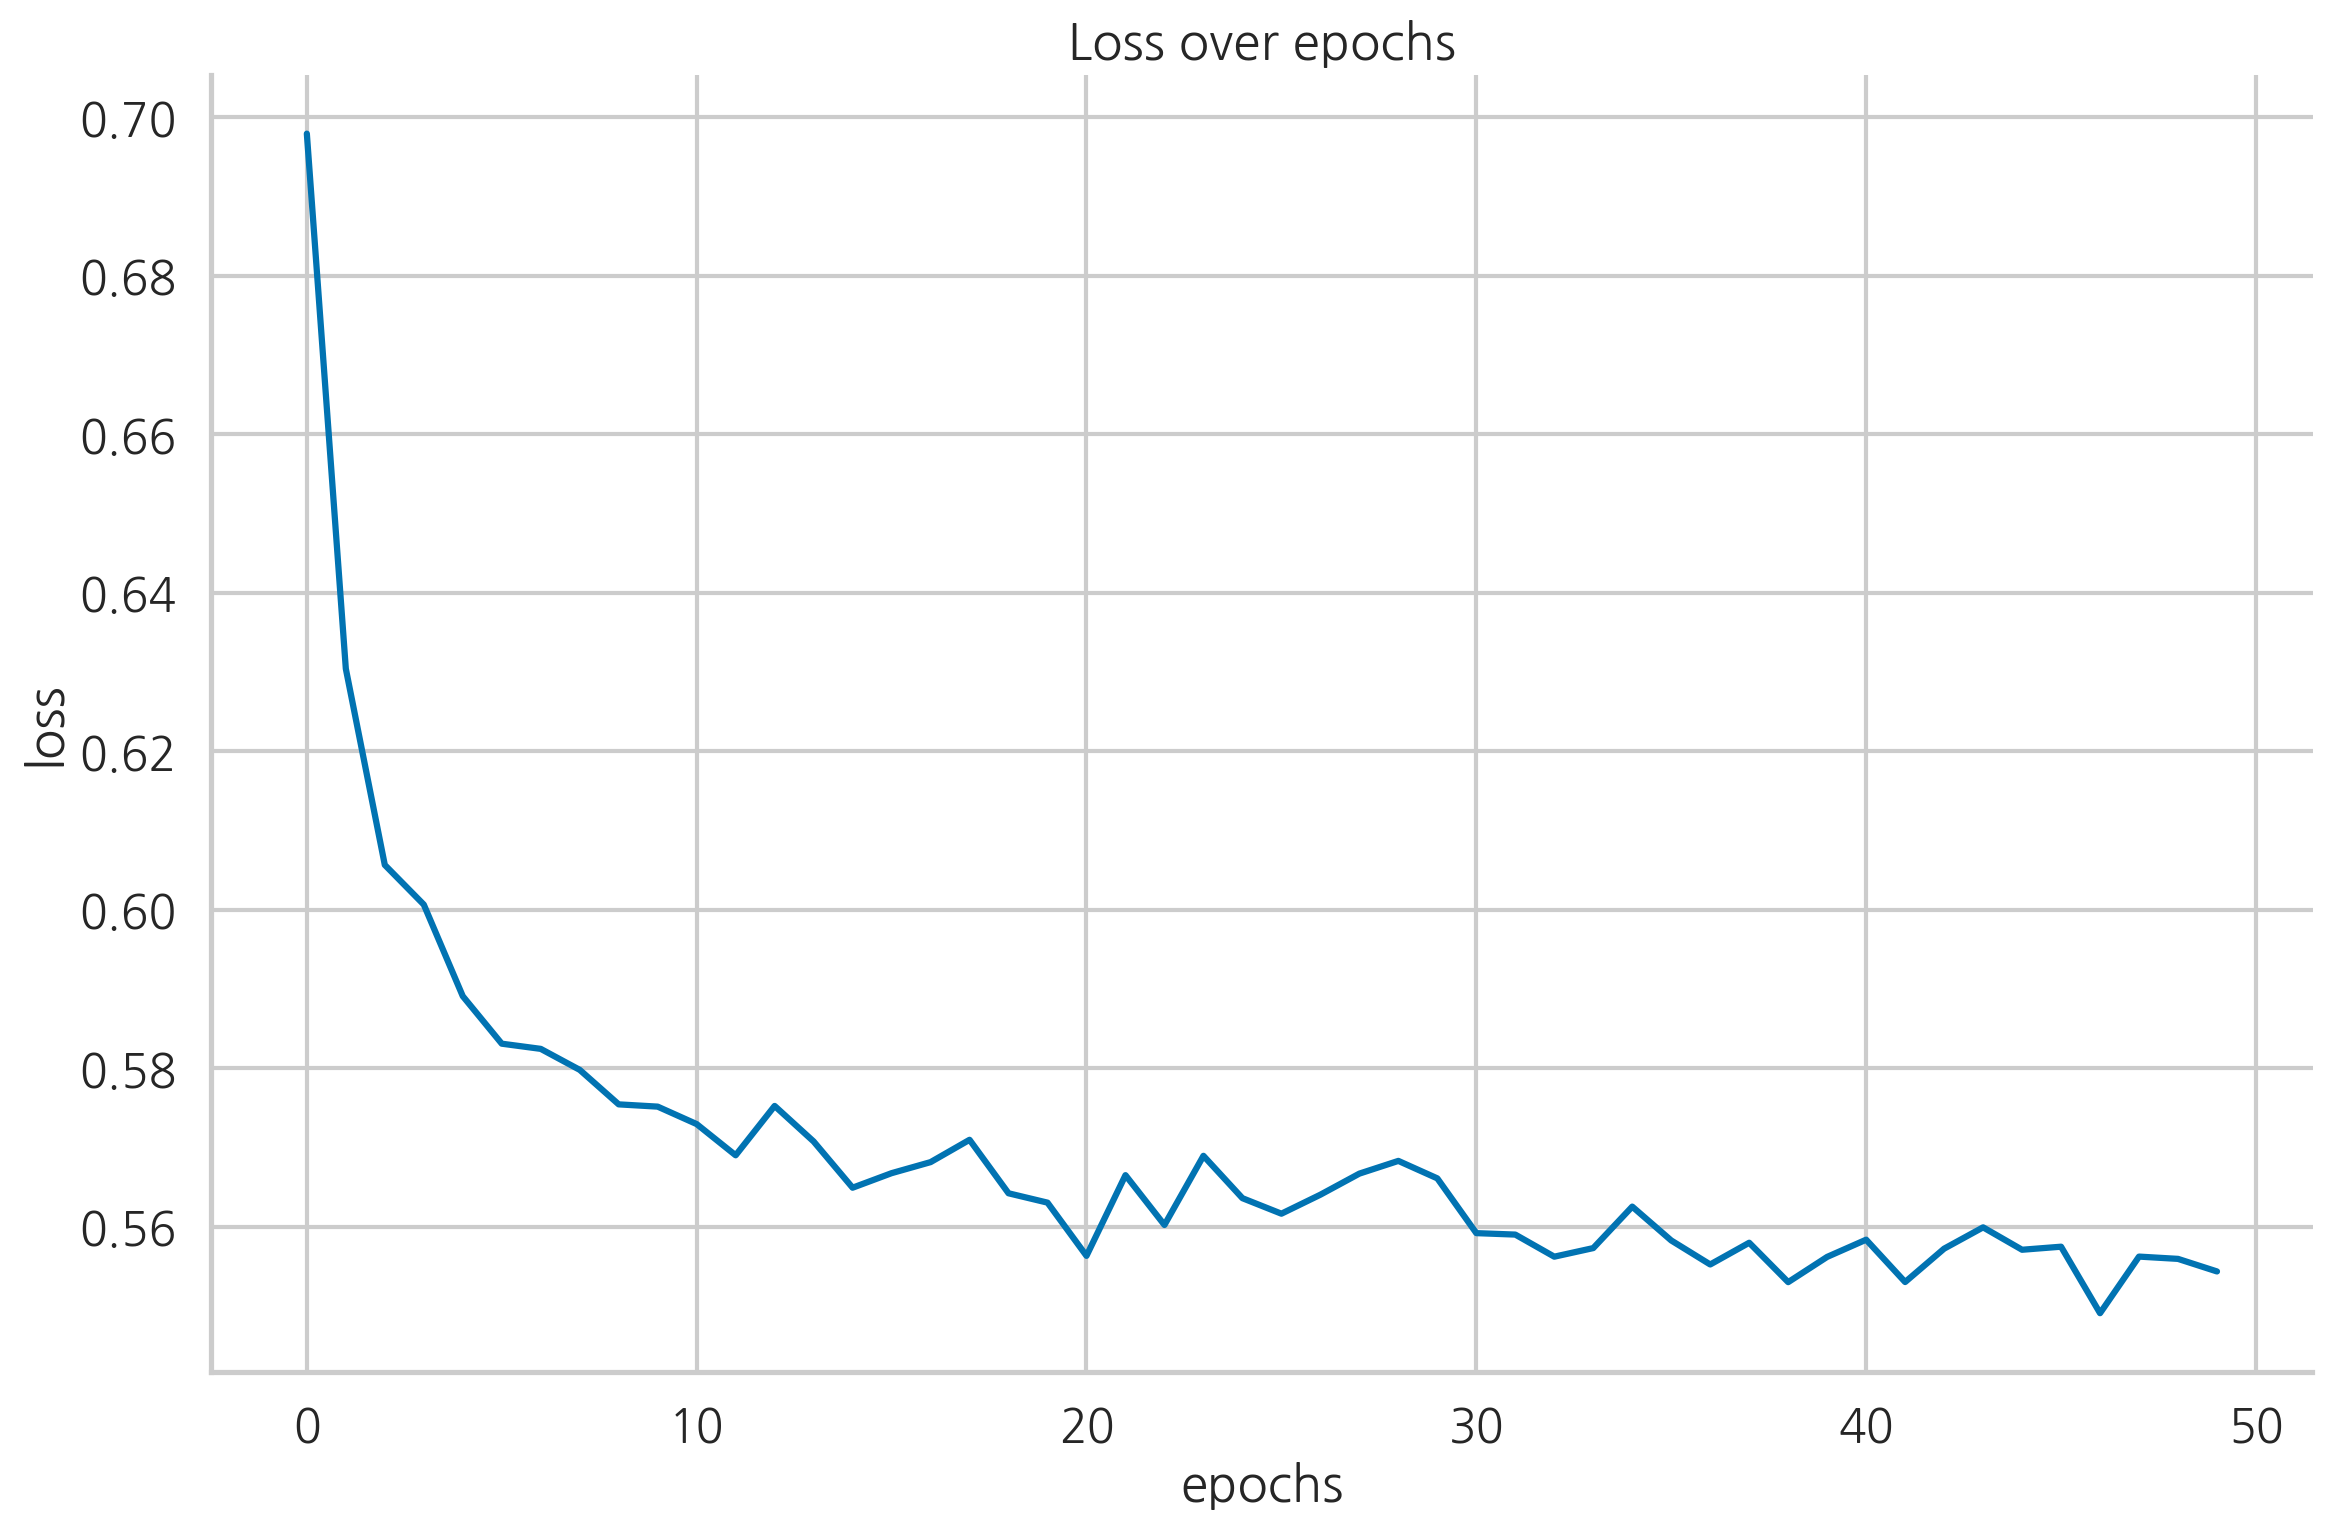

In [49]:
history_df["loss"].plot(
    title="Loss over epochs",
    xlabel="epochs",
    ylabel="loss"
)

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_15_7")

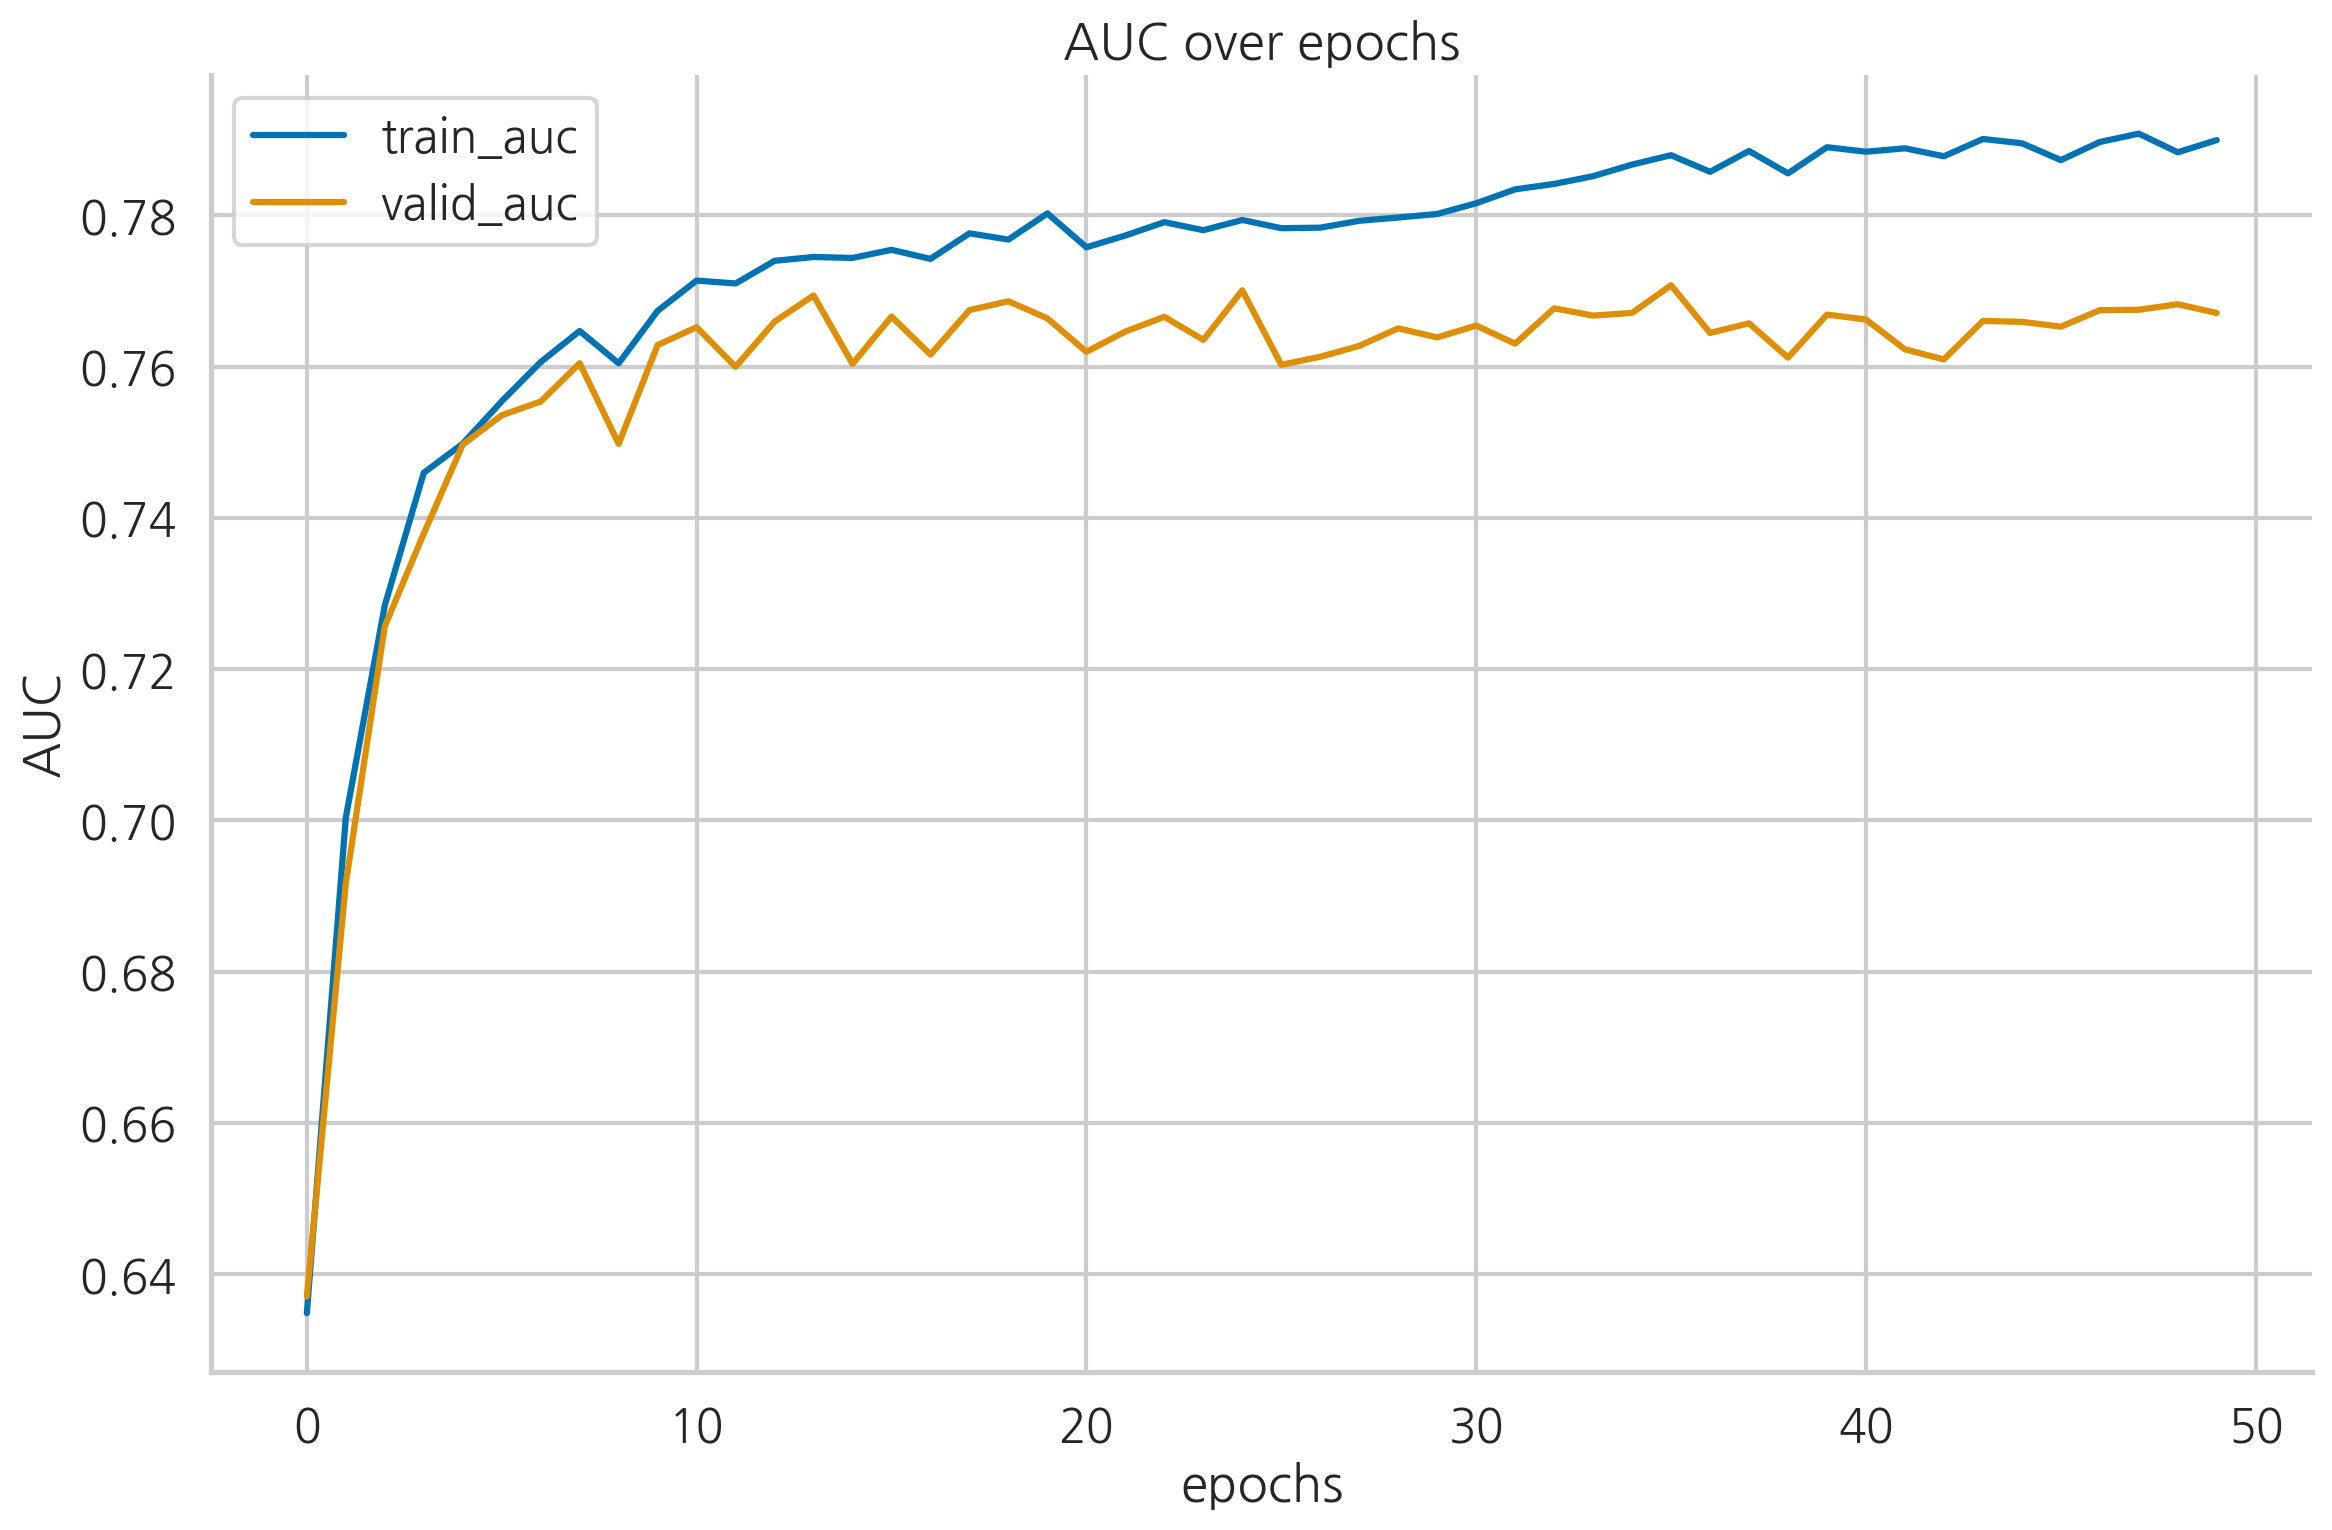

In [50]:
(
    history_df[["train_auc", "valid_auc"]]
    .plot(title="AUC over epochs",
          xlabel="epochs",
          ylabel="AUC")
);

plt.tight_layout()
sns.despine()

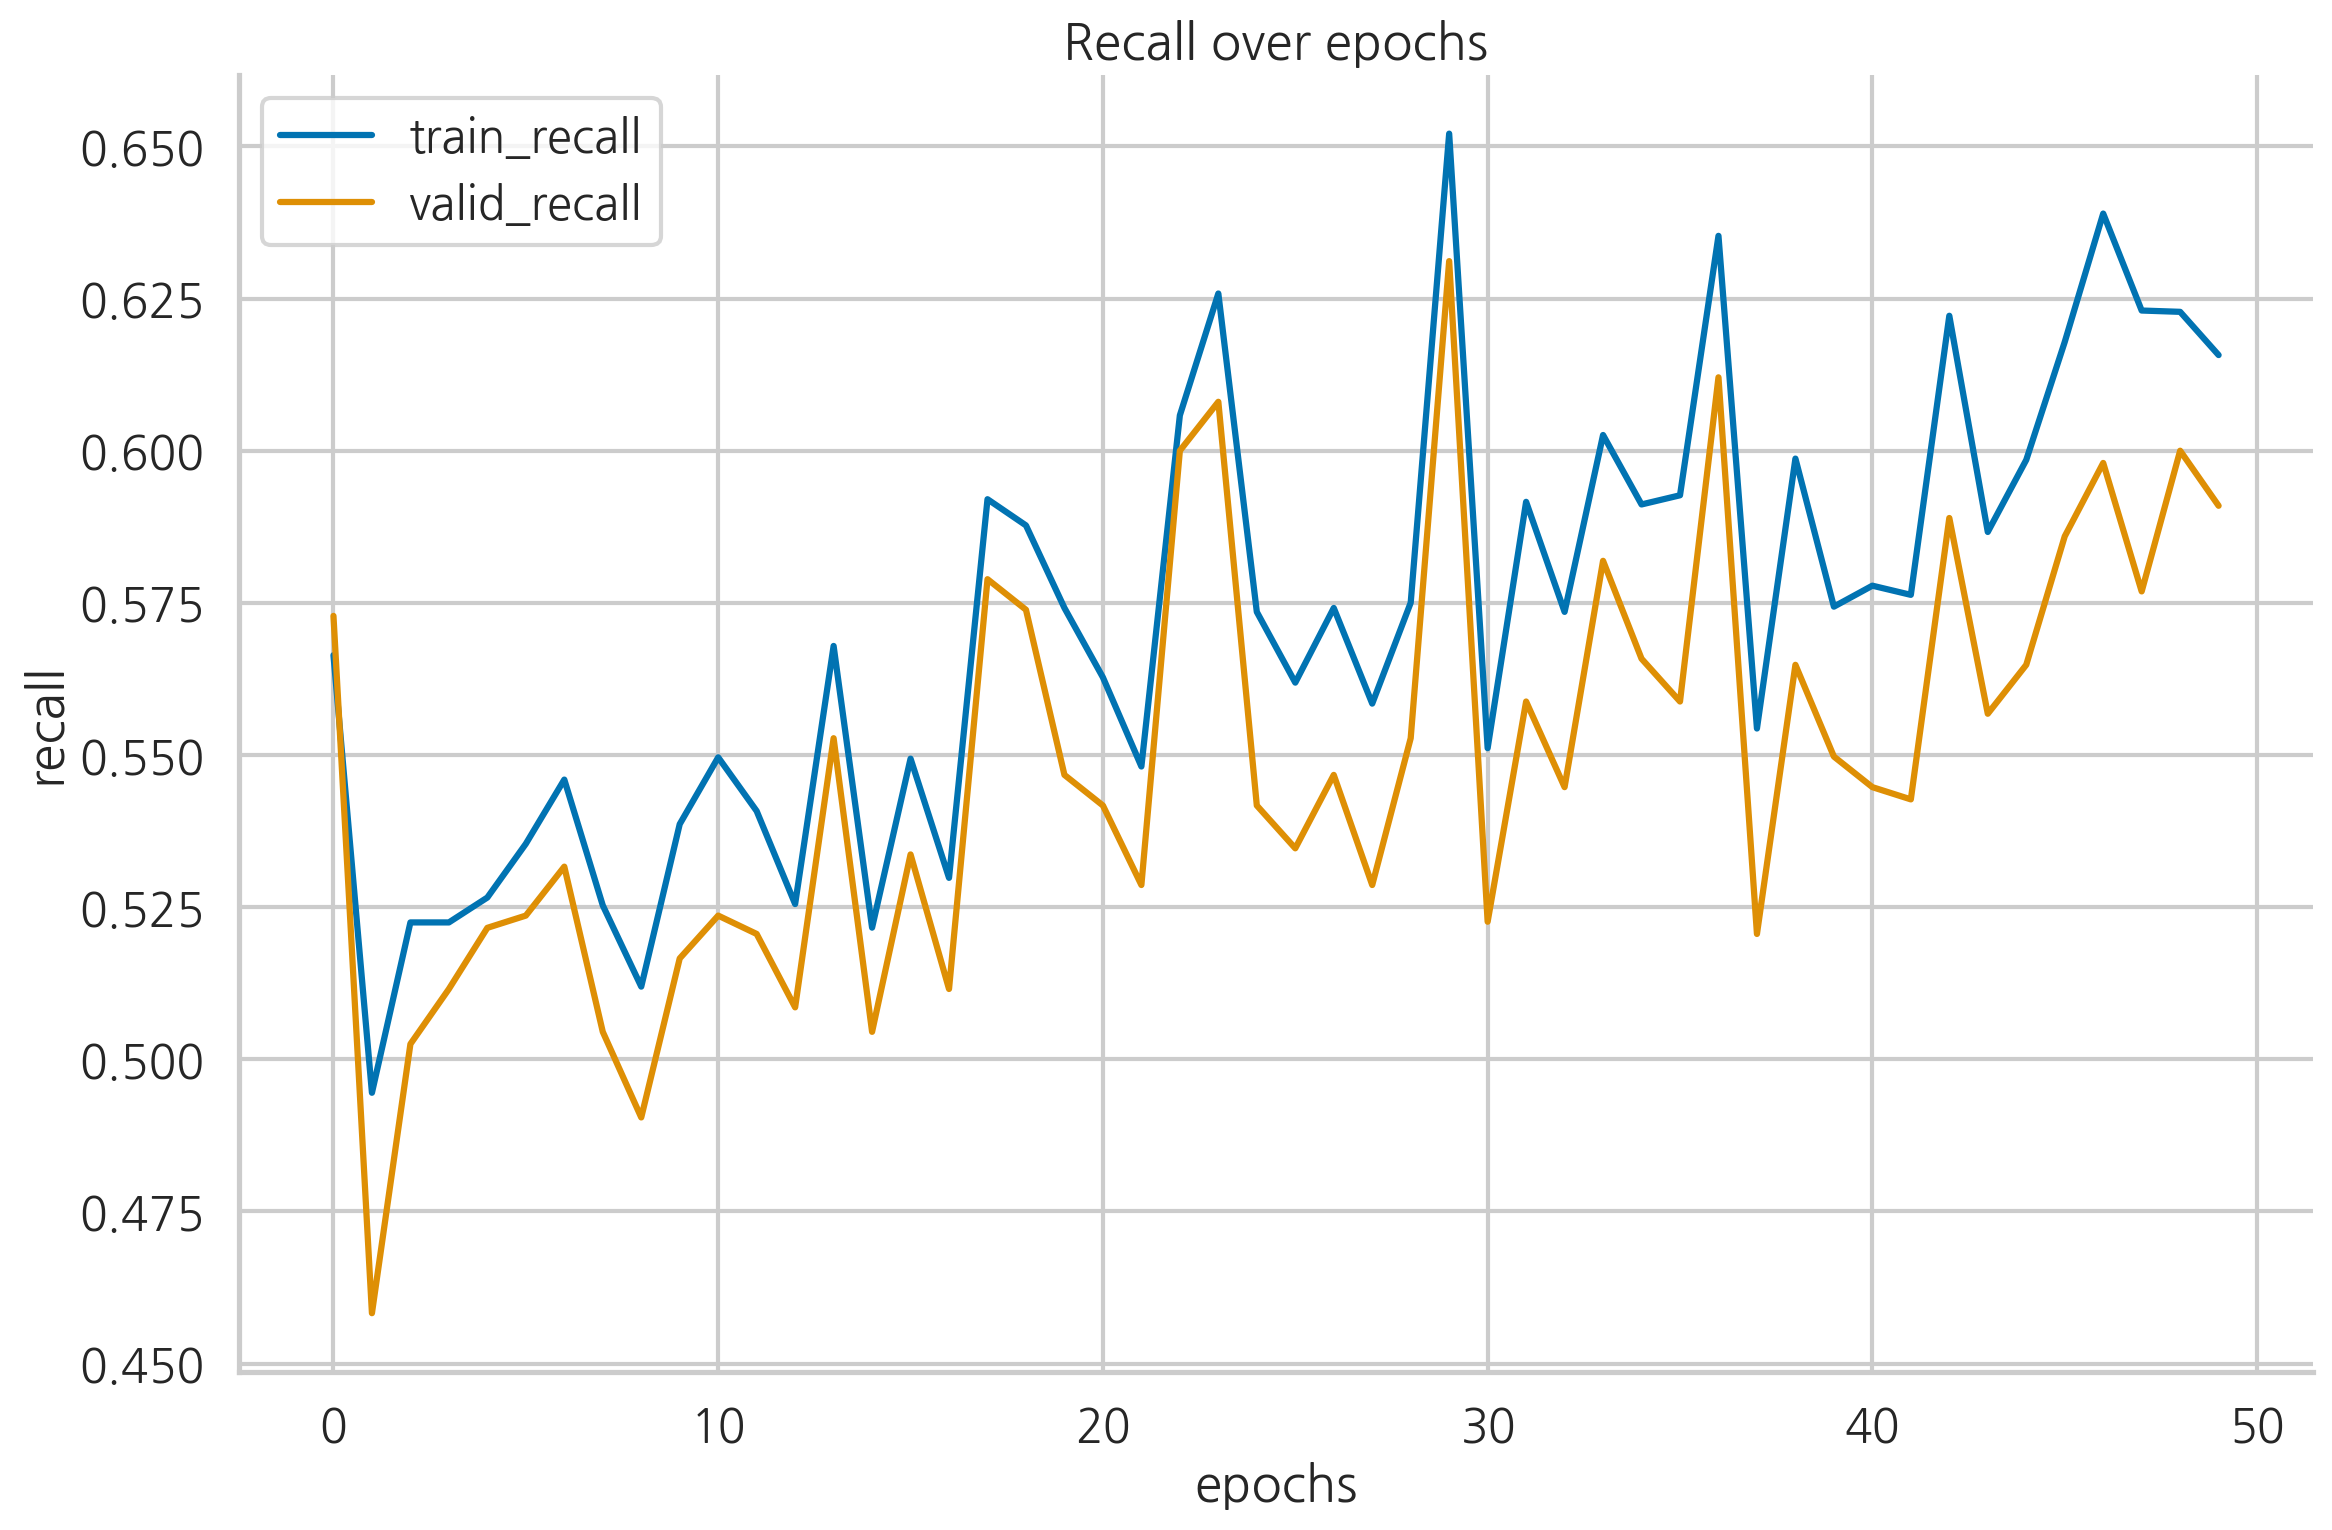

In [51]:
(
    history_df[["train_recall", "valid_recall"]]
    .plot(title="Recall over epochs",
          xlabel="epochs",
          ylabel="recall")
);

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_15_8")

12. Create predictions for the test set and evaluate their performance:

**Step 12**에서는, **predict** 메서드를 사용해 예측값을 생성합니다. 훈련 단계와 마찬가지로, 입력 특징을 **numpy** 배열 형태로 제공해야 합니다. **scikit-learn**에서와 같이, **predict** 메서드는 예측된 클래스를 반환하며, **predict_proba** 메서드를 사용해 클래스 확률을 얻을 수도 있습니다. 또한, **scikit-learn**의 `recall_score` 함수를 사용해 테스트 세트에서 재현율을 계산합니다.

In [52]:
y_pred = tabnet.predict(X_test.values)

print(f"Best validation score: {tabnet.best_cost:.4f}")
print(f"Test set score: {recall_score(y_test, y_pred):.4f}")

Best validation score: 0.6312
Test set score: 0.6466


13. Extract and plot the global feature importance:

마지막 단계에서는, 전역(feature importance) 특징 중요도 값을 추출합니다. **scikit-learn** 모델과 유사하게, 이 값들은 훈련된 모델의 **feature_importances_** 속성에 저장됩니다. 이후, 가장 중요한 20개의 특징을 시각화합니다. 전역 특징 중요도 값은 정규화되어 있으며, 합이 1이 된다는 점을 언급할 가치가 있습니다.

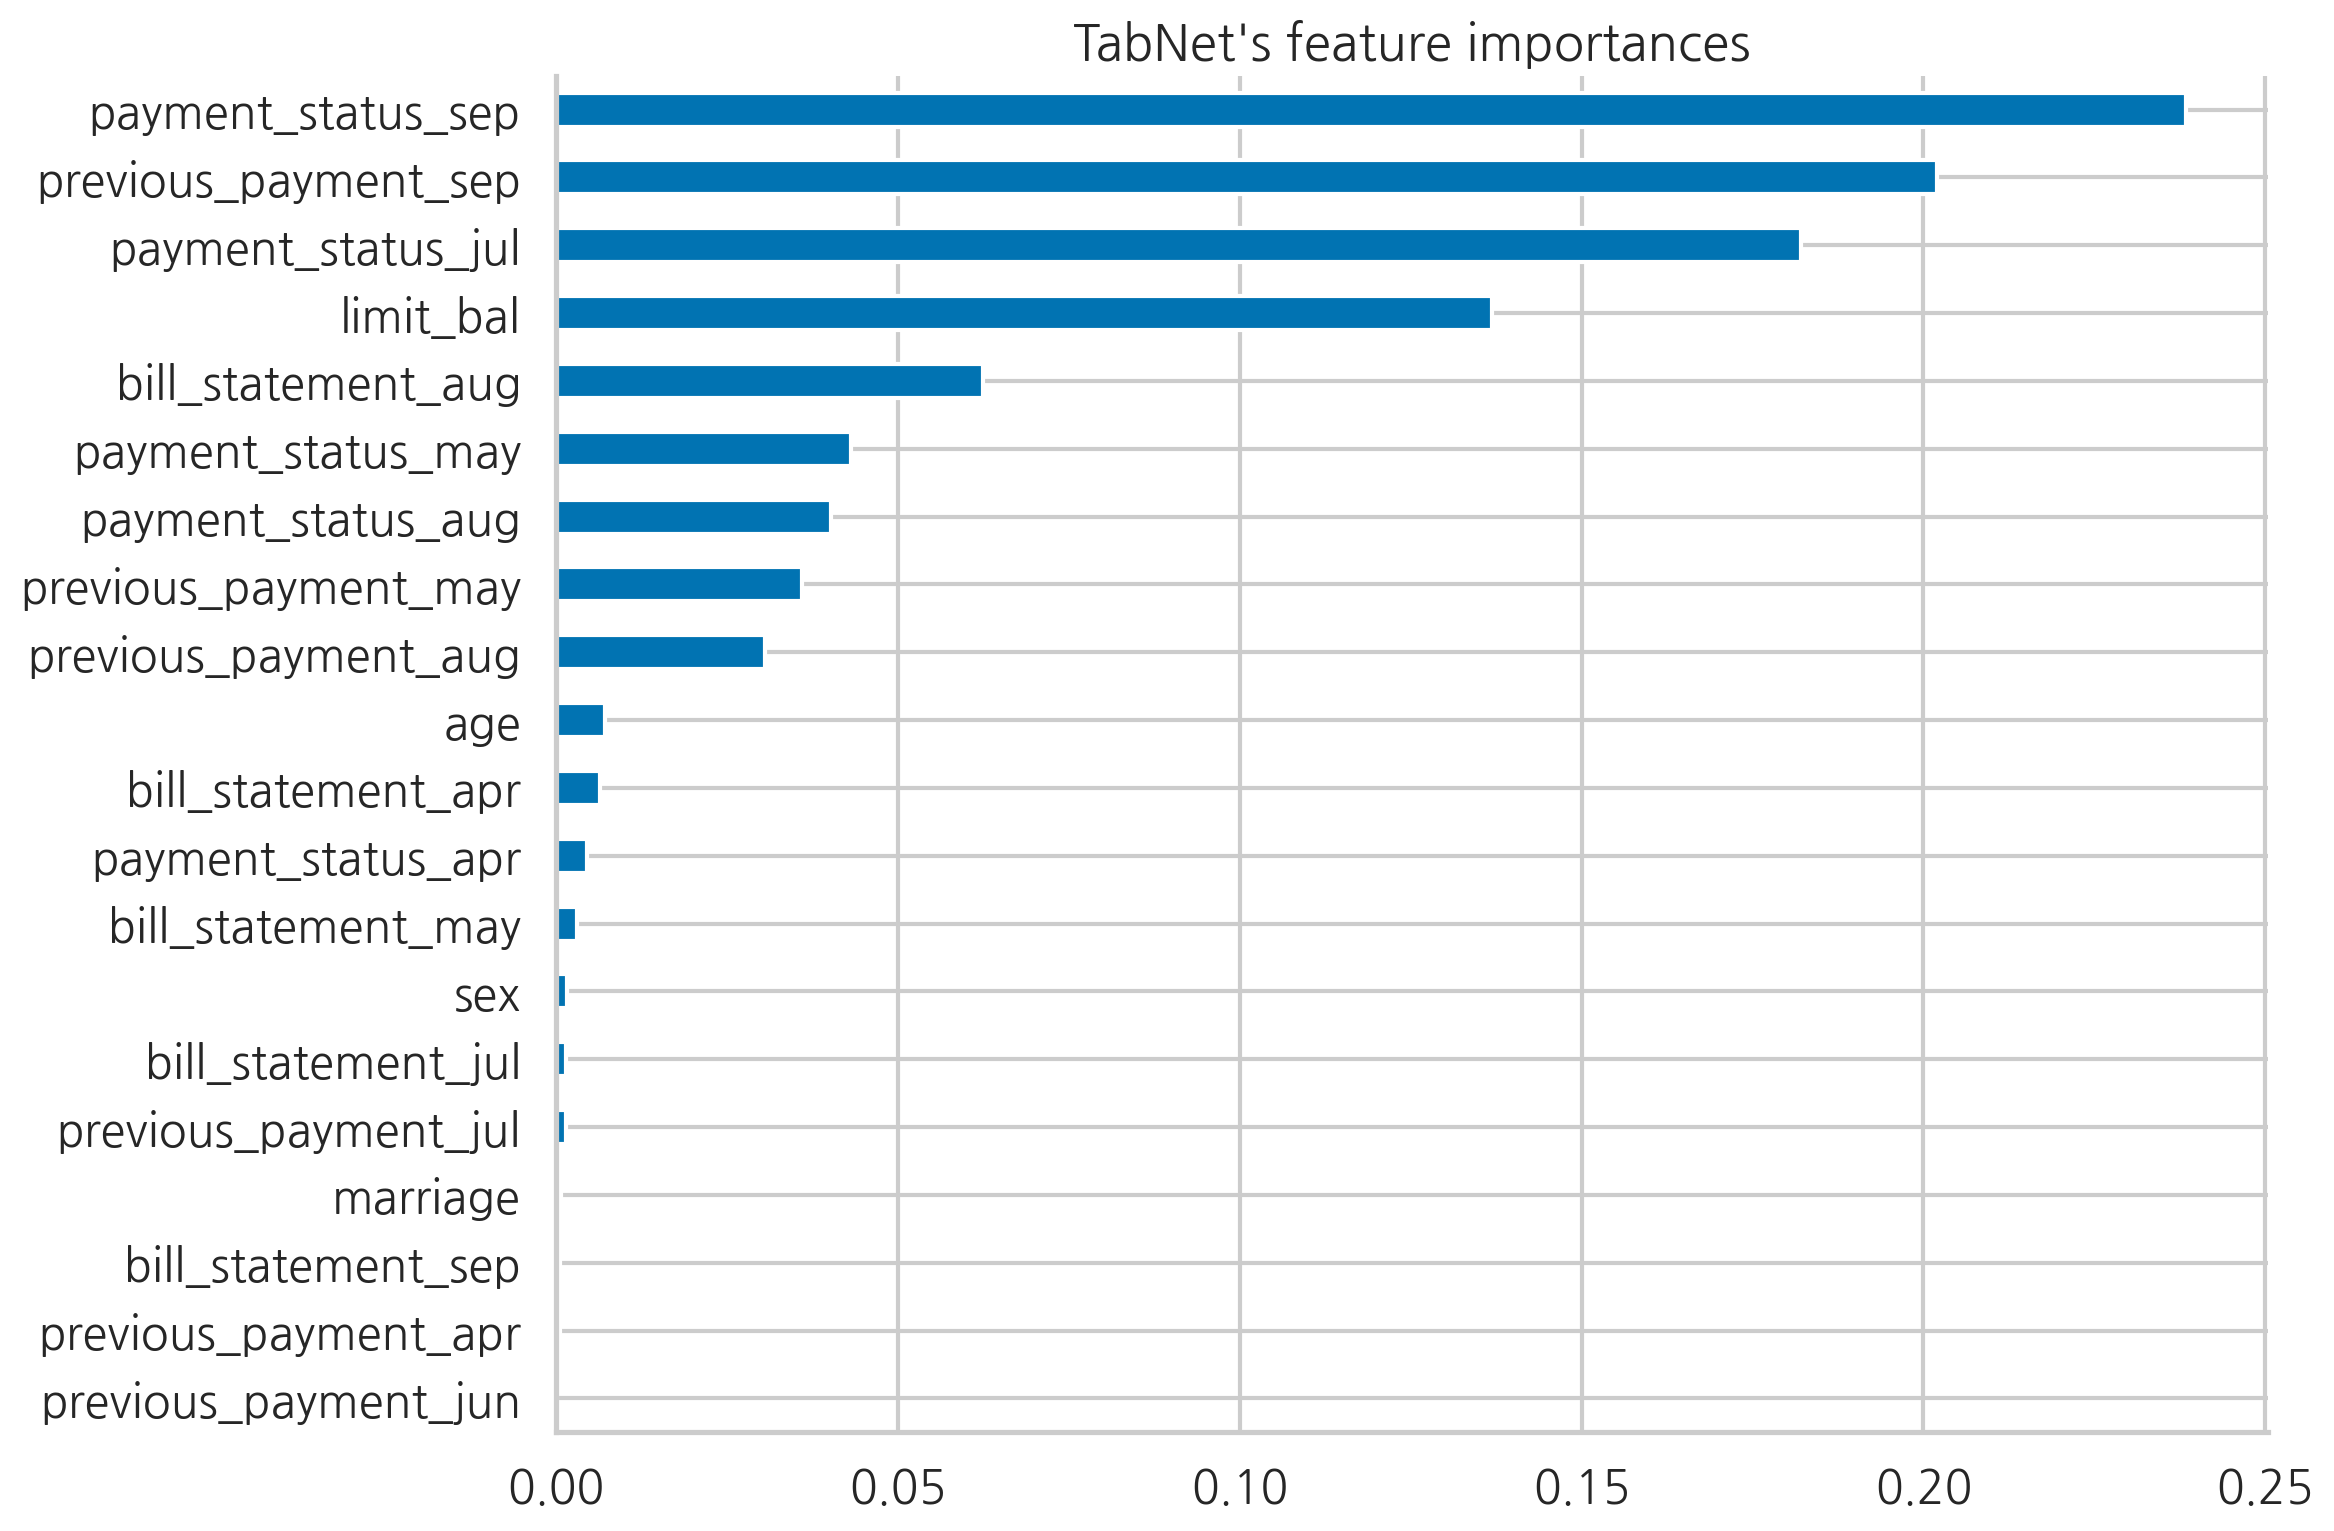

In [53]:
tabnet_feat_imp = pd.Series(tabnet.feature_importances_, 
                            index=X_train.columns)
(
    tabnet_feat_imp
    .nlargest(20)
    .sort_values()
    .plot(kind="barh",
          title="TabNet's feature importances")
)

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_15_9")

Figure 15.9: Global feature importance values extracted from the fitted TabNet classifier 

According to TabNet, the most important features for predicting defaults in October were the payment statuses in September, July, and May. Another important feature was the limit balance. 

Two things are worth mentioning at this point. First, the most important features are similar to the ones we identified in the Investigating feature importance recipe in Chapter 14, Advanced Concepts for Machine Learning Projects. Second, the feature importance is on a feature level, not on a feature and category level, as we could have seen while using one-hot encoding on categorical features.

In [54]:
np.sum(tabnet.feature_importances_)

0.9999999999999996

### There's more

다음은 TabNet 및 PyTorch에서의 구현과 관련된 몇 가지 흥미로운 점들입니다:

- TabNet은 **ghost batch normalization**을 사용해 대용량 데이터를 훈련하면서 동시에 일반화 성능을 개선합니다. 이 과정의 핵심은 입력 배치를 가상 배치 크기 파라미터에 따라 동일한 크기의 서브 배치로 나누는 것입니다. 그런 다음, 동일한 배치 정규화 계층을 이 서브 배치들에 적용합니다.

- **pytorch-tabnet**은 훈련 중 사용자 정의 데이터 증강 파이프라인을 적용할 수 있게 해줍니다. 현재, 이 라이브러리는 분류 및 회귀 작업 모두에서 SMOTE를 제공합니다.

- TabNet은 비지도 학습 모델로 사전 훈련될 수 있으며, 이를 통해 성능이 개선될 수 있습니다. 사전 훈련 중, 특정 셀들이 의도적으로 마스킹되고, 모델은 누락된(마스킹된) 값을 예측하며, 마스킹된 셀과 인접 열 간의 관계를 학습합니다. 이 비지도 표현 학습은 지도 학습 작업을 위한 개선된 인코더 모델로 작용합니다. 사전 훈련 시, 전체 특징 중 몇 퍼센트를 마스킹할지 결정할 수 있습니다.

- TabNet은 마스킹 함수로 **sparsemax**를 사용합니다. Sparsemax는 일반적인 softmax 함수보다 희소한 분포를 생성하는 비선형 정규화 함수입니다. 이 함수는 신경망이 더 중요한 특징을 효과적으로 선택할 수 있도록 도와줍니다. 또한, 이 함수는 희소성을 조절하는 정규화를 사용해 덜 희소한 마스크에 패널티를 부과합니다. **pytorch-tabnet** 라이브러리는 **EntMax** 마스킹 함수도 포함합니다.

- 이 문서에서는 전역(global) 특징 중요도를 추출하는 방법을 설명했습니다. 지역(local) 중요도를 추출하려면, 훈련된 TabNet 모델의 **explain** 메서드를 사용할 수 있습니다. 이 메서드는 두 가지 요소를 반환합니다: 각 관측치와 특징의 중요도를 포함하는 행렬과 특징 선택을 위해 모델에서 사용된 주의(attention) 마스크입니다.

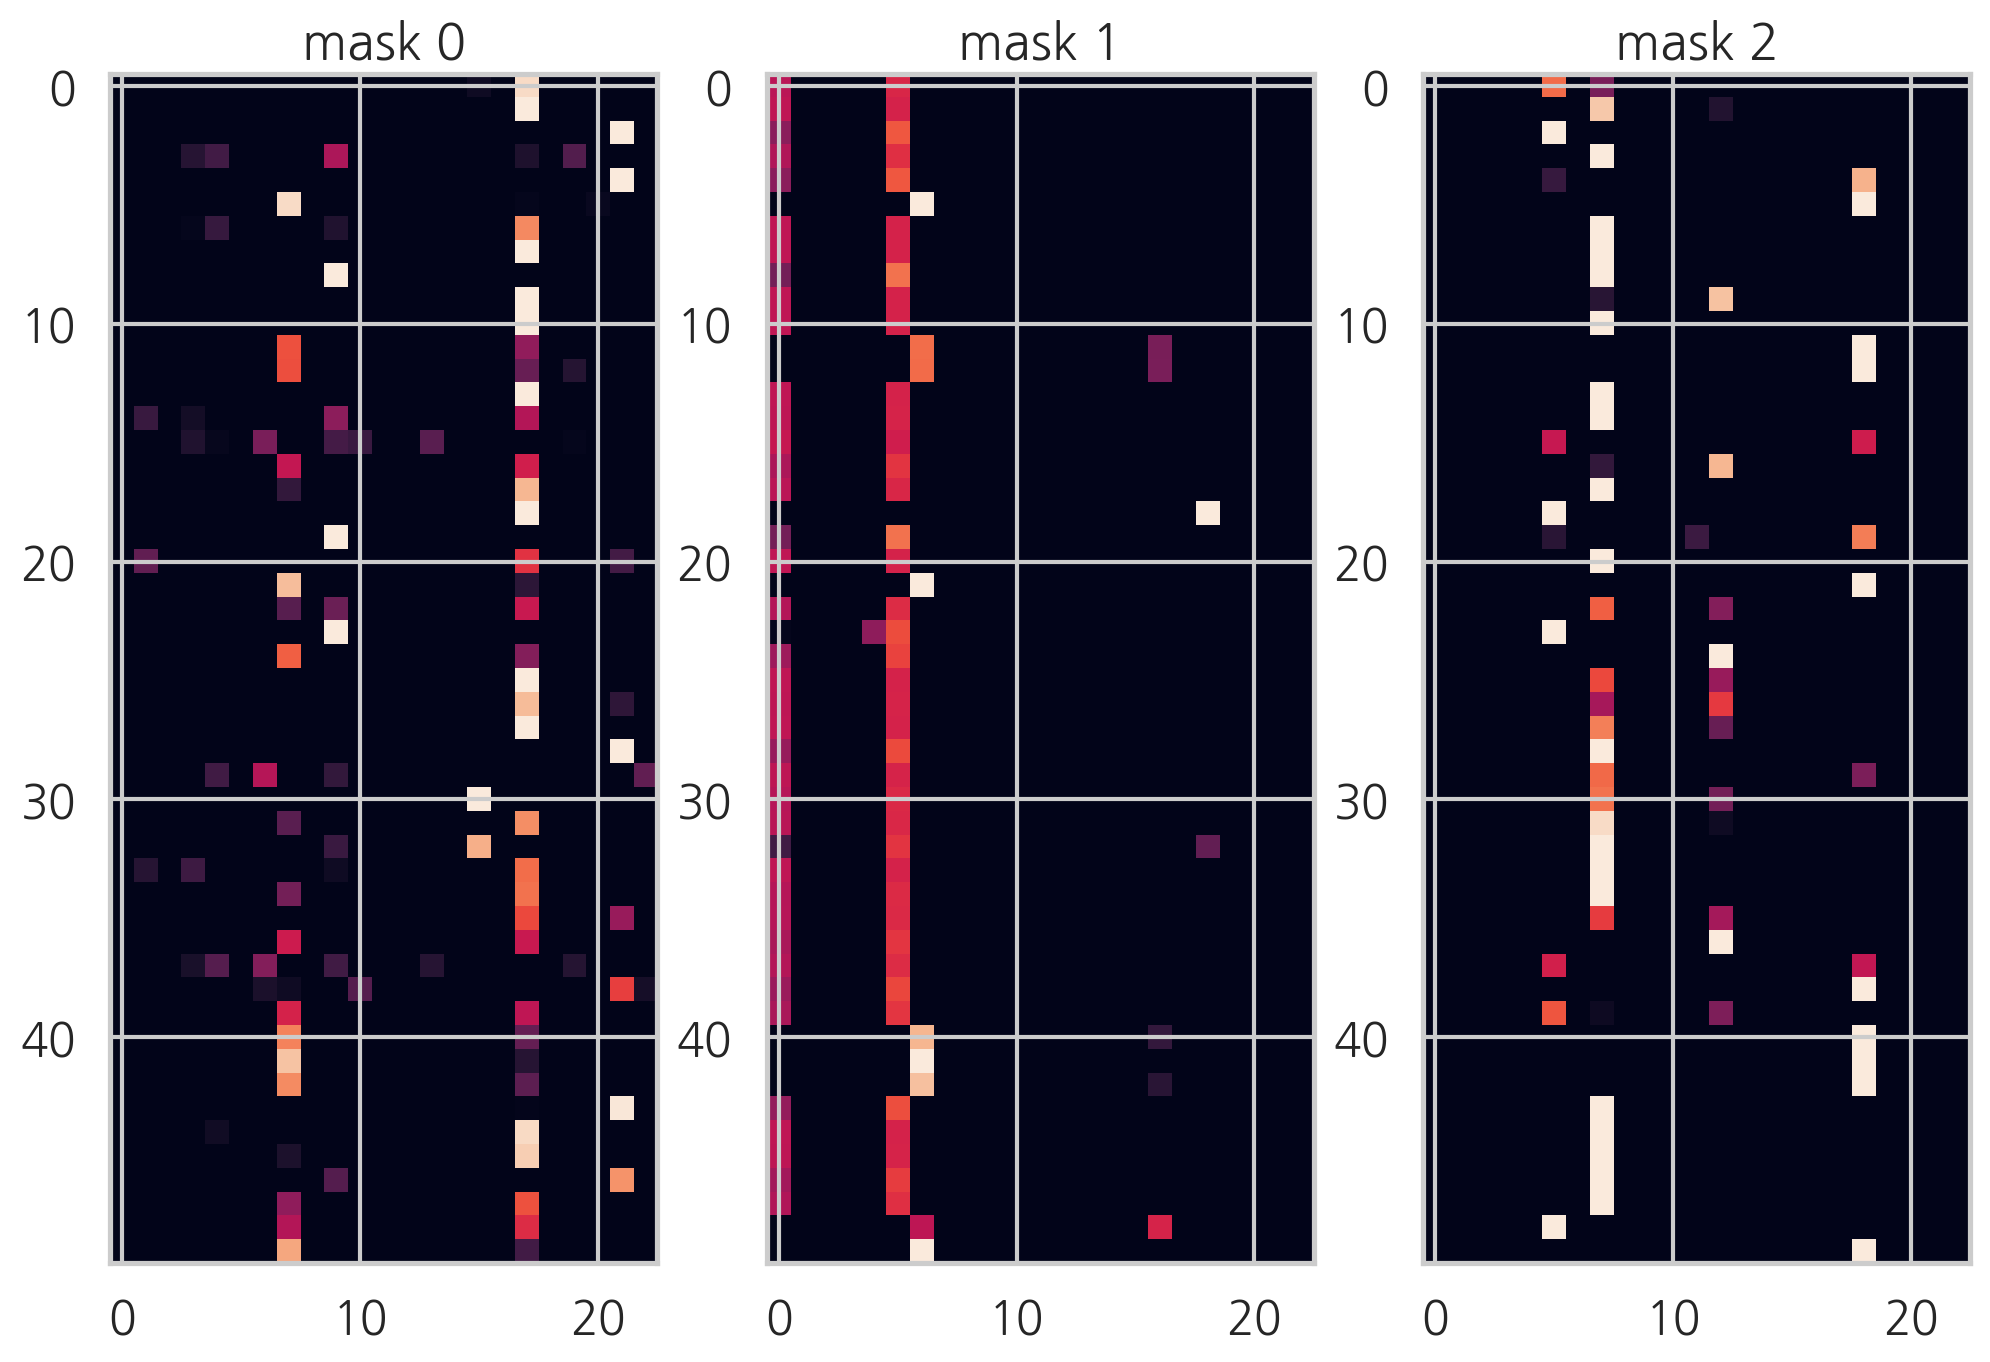

In [55]:
explain_matrix, masks = tabnet.explain(X_test.values)

fig, axs = plt.subplots(1, 3)

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

In [56]:
explain_matrix.shape

(4500, 23)

In [57]:
X_test.shape

(4500, 23)

In [58]:
# save tabnet model
MODEL_PATH = "models/tabnet_model"
saved_filepath = tabnet.save_model(MODEL_PATH)

# define new model with basic parameters and load state dict weights
loaded_tabnet = TabNetClassifier()
loaded_tabnet.load_model(saved_filepath)

Successfully saved model at models/tabnet_model.zip


/home/restful3/anaconda3/envs/nlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


### See also
- Arik, S. Ö., & Pfister, T. (2021, May). Tabnet: Attentive interpretable tabular learning. *Proceedings of the AAAI Conference on Artificial Intelligence*, 35(8), 6679-6687.
- TabNet의 구현을 포함하는 원본 저장소는 여기에서 확인할 수 있습니다: [https://github.com/google-research/google-research/tree/master/tabnet](https://github.com/google-research/google-research/tree/master/tabnet).

## 15.3 Time series forecasting with Amazon's DeepAR

**Amazon의 DeepAR을 사용한 시계열 예측**

우리는 이미 **Chapter 6, Time Series Analysis and Forecasting** 및 **Chapter 7, Machine Learning-Based Approaches to Time Series Forecasting**에서 시계열 분석과 예측을 다루었습니다. 이번에는 대규모 수요/판매 예측 도구로 개발된 Amazon의 DeepAR 모델을 사용한 시계열 예측 사례를 살펴봅니다. 특히 수백 개에서 수천 개의 **재고관리단위(SKU)** 를 다룹니다.

DeepAR의 아키텍처는 이 책의 범위를 넘어가므로, 우리는 모델의 주요 특성 몇 가지에만 초점을 맞춥니다. 주요 특성은 다음과 같습니다:

- DeepAR은 고려된 모든 시계열에 대해 글로벌 모델을 생성합니다. 이 모델은 LSTM 셀을 활용하며, 수백 개에서 수천 개의 시계열을 동시에 학습할 수 있는 아키텍처를 구현합니다. 또한, 시퀀스-투-시퀀스 작업에서 일반적으로 사용되는 인코더-디코더 설정을 사용합니다.

- DeepAR은 대상 시계열과 관련된 외부 회귀 변수(외부 설명 변수)를 사용하는 기능을 제공합니다.

- 이 모델은 최소한의 특징 엔지니어링만 요구합니다. 데이터를 기반으로 관련된 시계열 특징을 자동으로 생성하며(예: 월의 날짜, 연도의 날짜 등), 제공된 설명 변수(covariates)를 기반으로 계절 패턴을 학습합니다.

- DeepAR은 **Monte Carlo 샘플링**에 기반한 확률 예측을 제공합니다. 이를 통해 일관된 분위(quantile) 추정값을 계산합니다.

- 이 모델은 유사한 시계열로부터 학습해 데이터가 거의 없는 시계열에 대한 예측을 생성할 수 있습니다. 이는 **콜드 스타트 문제**에 대한 잠재적 해결책입니다.

- 이 모델은 다양한 가능도(likelihood) 함수를 사용할 수 있습니다.

이 레시피에서는 2020년과 2021년의 일별 주가를 포함한 약 100개의 시계열 데이터를 사용해 DeepAR 모델을 훈련합니다. 그런 다음, 2021년의 마지막 20 영업일을 포함하는 20일 뒤의 예측을 생성합니다.

진행하기 전에, 우리는 이 사례에서 주가 데이터를 단순히 설명 목적으로 사용하고 있음을 강조하고자 합니다. 딥러닝 모델은 수백 개에서 수천 개의 시계열로 훈련될 때 가장 우수한 성능을 발휘합니다. 이미 언급했듯이, 특히 긴 예측 기간에서는 주가를 정확히 예측하는 것이 매우 어렵거나 불가능할 수도 있습니다.

### How to do it...

1. Import the libraries:

**Step 1**에서는 필요한 라이브러리를 가져옵니다. DeepAR 모델을 사용하기 위해, 우리는 PyTorch Forecasting 라이브러리를 사용하기로 결정합니다. 이 라이브러리는 PyTorch Lightning 위에 구축되어 있으며, 시계열 예측을 위한 최첨단 딥러닝 모델을 쉽게 사용할 수 있도록 도와줍니다. 모델은 GPU로 훈련될 수 있으며, TensorBoard를 참조하여 훈련 로그를 검사할 수도 있습니다.


In [15]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import yfinance as yf
from random import sample, seed

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_forecasting import DeepAR, TimeSeriesDataSet


2. Download the tickers of the SP500 constituents and sample 100 random tickers from the list:

**Step 2**에서는 S&P 500 지수에 포함된 목록을 다운로드합니다. 그런 다음, 이 중 100개를 랜덤 샘플링하고 결과를 리스트에 저장합니다. 훈련 속도를 높이기 위해 티커를 샘플링하지만, 모델에 이득을 주기 위해 이 과정을 반복하거나 전체 종목을 사용하는 것도 흥미로울 수 있습니다.

In [17]:
df = pd.read_html(
    "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
)
df = df[0]

seed(44)
sampled_tickers = sample(df["Symbol"].to_list(), 100)

3. Download the historical stock prices of the selected stocks:

**Step 3**에서는, **yfinance** 라이브러리를 사용하여 2020년과 2021년의 과거 주가 데이터를 다운로드합니다. 다음 단계에서는 추가 전처리를 수행합니다. 조정 종가(Adjusted Close Price)만 유지하고, 누락된 값이 있는 종목은 제거합니다.

In [18]:
raw_df = yf.download(sampled_tickers,
                     start="2020-01-01",
                     end="2021-12-31")

[*********************100%***********************]  100 of 100 completed

1 Failed download:
['VLTO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2020-01-01 -> 2021-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1577854800, endDate = 1640926800")')


4. Keep the adjusted close price and remove the stocks with missing values:

In [19]:
df = raw_df["Adj Close"]
df = df.loc[:, ~df.isna().any()]
selected_tickers = df.columns
df.head()

Ticker                            ACN         ADI        ADSK        AEE  \
Date                                                                       
2020-01-02 00:00:00+00:00  195.263596  110.377762  187.830002  66.394997   
2020-01-03 00:00:00+00:00  194.938370  108.434715  184.949997  66.421181   
2020-01-06 00:00:00+00:00  193.665390  107.160736  187.119995  66.482292   
2020-01-07 00:00:00+00:00  189.484207  109.598694  187.500000  66.726753   
2020-01-08 00:00:00+00:00  189.855850  110.588554  189.949997  66.613258   

Ticker                           AES       AMZN         AON         ARE  \
Date                                                                      
2020-01-02 00:00:00+00:00  17.096724  94.900497  200.509705  136.561737   
2020-01-03 00:00:00+00:00  16.900404  93.748497  199.722290  137.339767   
2020-01-06 00:00:00+00:00  17.096724  95.143997  200.298447  137.673172   
2020-01-07 00:00:00+00:00  17.156475  95.343002  198.598679  133.167542   
2020-01-08 00:00:00+00:00  17.122334  94.598503  199.414902  134.937347   

Ticker                           ATO          AZO  ...        TAP         TDY  \
Date                                               ...                          
2020-01-02 00:00:00+00:00  97.846344  1189.739990  ...  48.128521  357.489990   
2020-01-03 00:00:00+00:00  98.493462  1187.979980  ...  47.984692  360.049988   
2020-01-06 00:00:00+00:00  98.360489  1165.709961  ...  49.108360  358.630005   
2020-01-07 00:00:00+00:00  99.016457  1145.380005  ...  48.982510  361.089996   
2020-01-08 00:00:00+00:00  98.165474  1147.489990  ...  49.458939  361.549988   

Ticker                           TEL         VMC        WAB        WEC  \
Date                                                                     
2020-01-02 00:00:00+00:00  88.929108  136.589920  78.508286  77.226128   
2020-01-03 00:00:00+00:00  87.878662  135.996582  77.907005  77.711601   
2020-01-06 00:00:00+00:00  87.270508  135.757309  77.586937  77.771225   
2020-01-07 00:00:00+00:00  89.076553  134.225998  77.557869  77.473122   
2020-01-08 00:00:00+00:00  89.997993  135.297928  76.229202  77.575333   

Ticker                             WM        WMB         WY        XEL  
Date                                                                    
2020-01-02 00:00:00+00:00  105.488960  17.642876  24.533123  54.000294  
2020-01-03 00:00:00+00:00  106.514107  17.717987  24.574862  54.259991  
2020-01-06 00:00:00+00:00  107.068237  17.950819  24.524773  54.182076  
2020-01-07 00:00:00+00:00  107.142128  17.950819  24.366180  54.069546  
2020-01-08 00:00:00+00:00  107.206787  17.672918  24.457994  54.017601  

[5 rows x 98 columns]

5. Convert the data's format from wide to long and add the time index:

**Step 5**에서는 전처리를 계속합니다. DataFrame을 와이드(wide) 포맷에서 롱(long) 포맷으로 변환한 후, 시계열의 타임 인덱스를 추가합니다. DeepAR 구현은 날짜 대신 정수형 타임 인덱스로 작동하므로, **cumcount** 메서드와 **groupby** 메서드를 결합해 타임 인덱스를 생성합니다.

In [20]:
df = df.reset_index(drop=False)
# df = (
#     pd.melt(df, 
#             id_vars=["Date"], 
#             value_vars=selected_tickers, 
#             value_name="price"
#     ).rename(columns={"variable": "ticker"})
# )
df = (
    pd.melt(df, 
            id_vars=["Date"], 
            value_vars=selected_tickers, 
            value_name="price"
    ).rename(columns={"Ticker": "ticker"})
)



# df["time_idx"] = df.groupby("ticker").cumcount()
df

Date ticker       price
0     2020-01-02 00:00:00+00:00    ACN  195.263596
1     2020-01-03 00:00:00+00:00    ACN  194.938370
2     2020-01-06 00:00:00+00:00    ACN  193.665390
3     2020-01-07 00:00:00+00:00    ACN  189.484207
4     2020-01-08 00:00:00+00:00    ACN  189.855850
...                         ...    ...         ...
49387 2021-12-23 00:00:00+00:00    XEL   60.842201
49388 2021-12-27 00:00:00+00:00    XEL   61.034019
49389 2021-12-28 00:00:00+00:00    XEL   61.764755
49390 2021-12-29 00:00:00+00:00    XEL   62.075306
49391 2021-12-30 00:00:00+00:00    XEL   62.321934

[49392 rows x 3 columns]

In [21]:
df["time_idx"] = df.groupby("ticker").cumcount()
df

Date ticker       price  time_idx
0     2020-01-02 00:00:00+00:00    ACN  195.263596         0
1     2020-01-03 00:00:00+00:00    ACN  194.938370         1
2     2020-01-06 00:00:00+00:00    ACN  193.665390         2
3     2020-01-07 00:00:00+00:00    ACN  189.484207         3
4     2020-01-08 00:00:00+00:00    ACN  189.855850         4
...                         ...    ...         ...       ...
49387 2021-12-23 00:00:00+00:00    XEL   60.842201       499
49388 2021-12-27 00:00:00+00:00    XEL   61.034019       500
49389 2021-12-28 00:00:00+00:00    XEL   61.764755       501
49390 2021-12-29 00:00:00+00:00    XEL   62.075306       502
49391 2021-12-30 00:00:00+00:00    XEL   62.321934       503

[49392 rows x 4 columns]

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49392 entries, 0 to 49391
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   Date      49392 non-null  datetime64[ns, UTC]
 1   ticker    49392 non-null  object             
 2   price     49392 non-null  float64            
 3   time_idx  49392 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(1)
memory usage: 1.5+ MB


6. Define constants used for setting up the model's training:

**Step 6**에서는 훈련 절차에 필요한 몇 가지 상수를 정의합니다. 예를 들어, 인코더 단계의 최대 길이, 미래 예측 관측값의 최대 개수, 훈련 에포크의 최대 수 등을 정의합니다. 또한, 타임 인덱스가 어느 지점에서 검증 세트와 훈련 세트를 나누는지 지정합니다.

In [23]:
MAX_ENCODER_LENGTH = 40
MAX_PRED_LENGTH = 20
BATCH_SIZE = 128
MAX_EPOCHS = 30
training_cutoff = df["time_idx"].max() - MAX_PRED_LENGTH

7. Define the training and validation datasets:

**Step 7**에서는 **TimeSeriesDataSet** 클래스를 사용해 훈련 및 검증 데이터세트를 정의합니다. 이 클래스의 주요 책임은 다음을 포함합니다:
- 변수 변환 처리
- 누락된 값 처리
- 정적 변수와 시변 변수(미래에 알려진 것과 알려지지 않은 것 모두) 저장
- 랜덤화된 서브샘플링

훈련 데이터세트를 정의할 때, 우리는 훈련 데이터(사전에 정의된 컷오프 지점으로 필터링됨), 타임 인덱스를 포함하는 컬럼 이름, 타겟, 그룹 ID(우리의 경우 티커), 인코더 길이, 예측 기간 등을 제공해야 합니다.

각 **TimeSeriesDataSet**에서 생성된 샘플은 전체 시계열의 부분 시퀀스입니다. 각 부분 시퀀스는 주어진 시계열에 대해 인코더와 예측 지점으로 구성됩니다. **TimeSeriesDataSet**은 샘플링 가능한 부분 시퀀스를 정의하는 인덱스를 생성합니다.

In [24]:
# train_set = TimeSeriesDataSet(
#     df[lambda x: x["time_idx"] <= training_cutoff],
#     time_idx="time_idx",
#     target="price",
#     group_ids=["ticker"],
#     time_varying_unknown_reals=["price"],
#     max_encoder_length=MAX_ENCODER_LENGTH,
#     max_prediction_length=MAX_PRED_LENGTH,
# )

# valid_set = TimeSeriesDataSet.from_dataset(
#     train_set, df, min_prediction_idx=training_cutoff+1
# )

# numpy float 타입을 명시적으로 지정
import numpy as np
np.float = np.float64  # numpy float 타입을 float64로 설정

train_set = TimeSeriesDataSet(
    df[lambda x: x["time_idx"] <= training_cutoff],
    time_idx="time_idx",
    target="price", 
    group_ids=["ticker"],
    time_varying_unknown_reals=["price"],
    max_encoder_length=MAX_ENCODER_LENGTH,
    max_prediction_length=MAX_PRED_LENGTH,
)

valid_set = TimeSeriesDataSet.from_dataset(
    train_set, df, min_prediction_idx=training_cutoff+1
)

8. Get the DataLoaders from the datasets:

**Step 8**에서는 **to_dataloader** 메서드를 사용해 데이터세트를 데이터로더로 변환합니다.

In [25]:
train_dataloader = train_set.to_dataloader(
    train=True, batch_size=BATCH_SIZE
)
valid_dataloader = valid_set.to_dataloader(
    train=False, batch_size=BATCH_SIZE
)

9. Define the DeepAR model and find the suggested learning rate:

**Step 9**에서는 **DeepAR** 클래스의 **from_dataset** 메서드를 사용해 DeepAR 모델을 정의합니다. 이를 통해 **TimeSeriesDataSet** 객체를 생성할 때 이미 지정한 내용을 반복하지 않을 수 있습니다. 또한, 학습률, 은닉층의 크기, RNN 계층 수와 같은 하이퍼파라미터를 설정합니다. 이 중 두 가지가 DeepAR 모델에서 가장 중요한 하이퍼파라미터이며, **Hyperopt**나 **Optuna**와 같은 HPO 프레임워크를 사용해 튜닝해야 합니다. 그런 다음, PyTorch Lightning의 **Trainer** 클래스를 사용해 모델의 최적 학습률을 찾습니다.

기본적으로 DeepAR 모델은 가우시안 손실 함수를 사용합니다. 그러나 작업에 따라 다른 옵션을 사용할 수도 있습니다. 예를 들어, 실수 값을 처리할 때는 가우시안 분포를, 0~1 범위의 데이터를 처리할 때는 베타 가능도(likelihood)를, 이진 데이터를 처리할 때는 베르누이 가능도를 사용할 수 있습니다.

In [34]:
# pl.seed_everything(42)

# deep_ar = DeepAR.from_dataset(
#     train_set, 
#     learning_rate=1e-2,
#     hidden_size=30, 
#     rnn_layers=4
# )

# trainer = pl.Trainer(gradient_clip_val=1e-1)
# res = trainer.tuner.lr_find(
#     deep_ar,
#     train_dataloaders=train_dataloader,
#     val_dataloaders=valid_dataloader,
#     min_lr=1e-5,
#     max_lr=1e0,
#     early_stop_threshold=100,
# )

# print(f"Suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)

# plt.tight_layout()
# sns.despine()
# # plt.savefig("images/figure_15_11")

10. Train the DeepAR model:

**Step 10**에서는 식별된 학습률을 사용해 DeepAR 모델을 훈련합니다. 추가적으로, 검증 손실에서 10 에포크 동안 의미 있는(우리가 정의한) 개선이 없을 경우 훈련을 중지하는 조기 종료 콜백(early stopping callback)을 지정합니다.

In [35]:
# pl.seed_everything(42)

# deep_ar.hparams.learning_rate = res.suggestion()

# early_stop_callback = EarlyStopping(
#     monitor="val_loss", 
#     min_delta=1e-4, 
#     patience=10
# )

# trainer = pl.Trainer(
#     max_epochs=MAX_EPOCHS,
#     gradient_clip_val=0.1,
#     callbacks=[early_stop_callback]
# )

# trainer.fit(
#     deep_ar,
#     train_dataloaders=train_dataloader,
#     val_dataloaders=valid_dataloader,
# )

In [31]:
pl.seed_everything(42)

deep_ar = DeepAR.from_dataset(
    train_set,
    learning_rate=1e-3,  # 학습률을 직접 지정
    hidden_size=30,
    rnn_layers=4
)

# EarlyStopping 콜백 정의
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=10,
    mode="min"
)

# Trainer 정의
trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    enable_progress_bar=True,
    accelerator='auto'  # GPU 사용 가능시 자동 선택
)

# 모델 학습
trainer.fit(
    deep_ar,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader
)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 26.3 K
4 | distribution_projector | Linear            

Epoch 23: 100%|██████████| 326/326 [00:15<00:00, 21.35it/s, loss=2.02, v_num=6, train_loss_step=1.990, val_loss=2.000, train_loss_epoch=2.000]


11. Extract the best DeepAR model from a checkpoint:

**Step 11**에서는 체크포인트에서 최상의 모델을 추출합니다. 그런 다음, **predict** 메서드를 사용해 검증 데이터로부터 100개 시퀀스에 대한 예측을 생성합니다. 우리는 원시 예측을 추출하기를 지정했으며(이 옵션은 분위 값, 입력으로 사용된 정보 등을 포함한 예측에 대한 추가 정보를 반환함), **plot_prediction** 메서드를 사용해 훈련된 DeepAR 모델의 예측을 시각화합니다.

In [32]:
best_model = DeepAR.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
)

12. Create the predictions for the validation set and plot 5 of them:

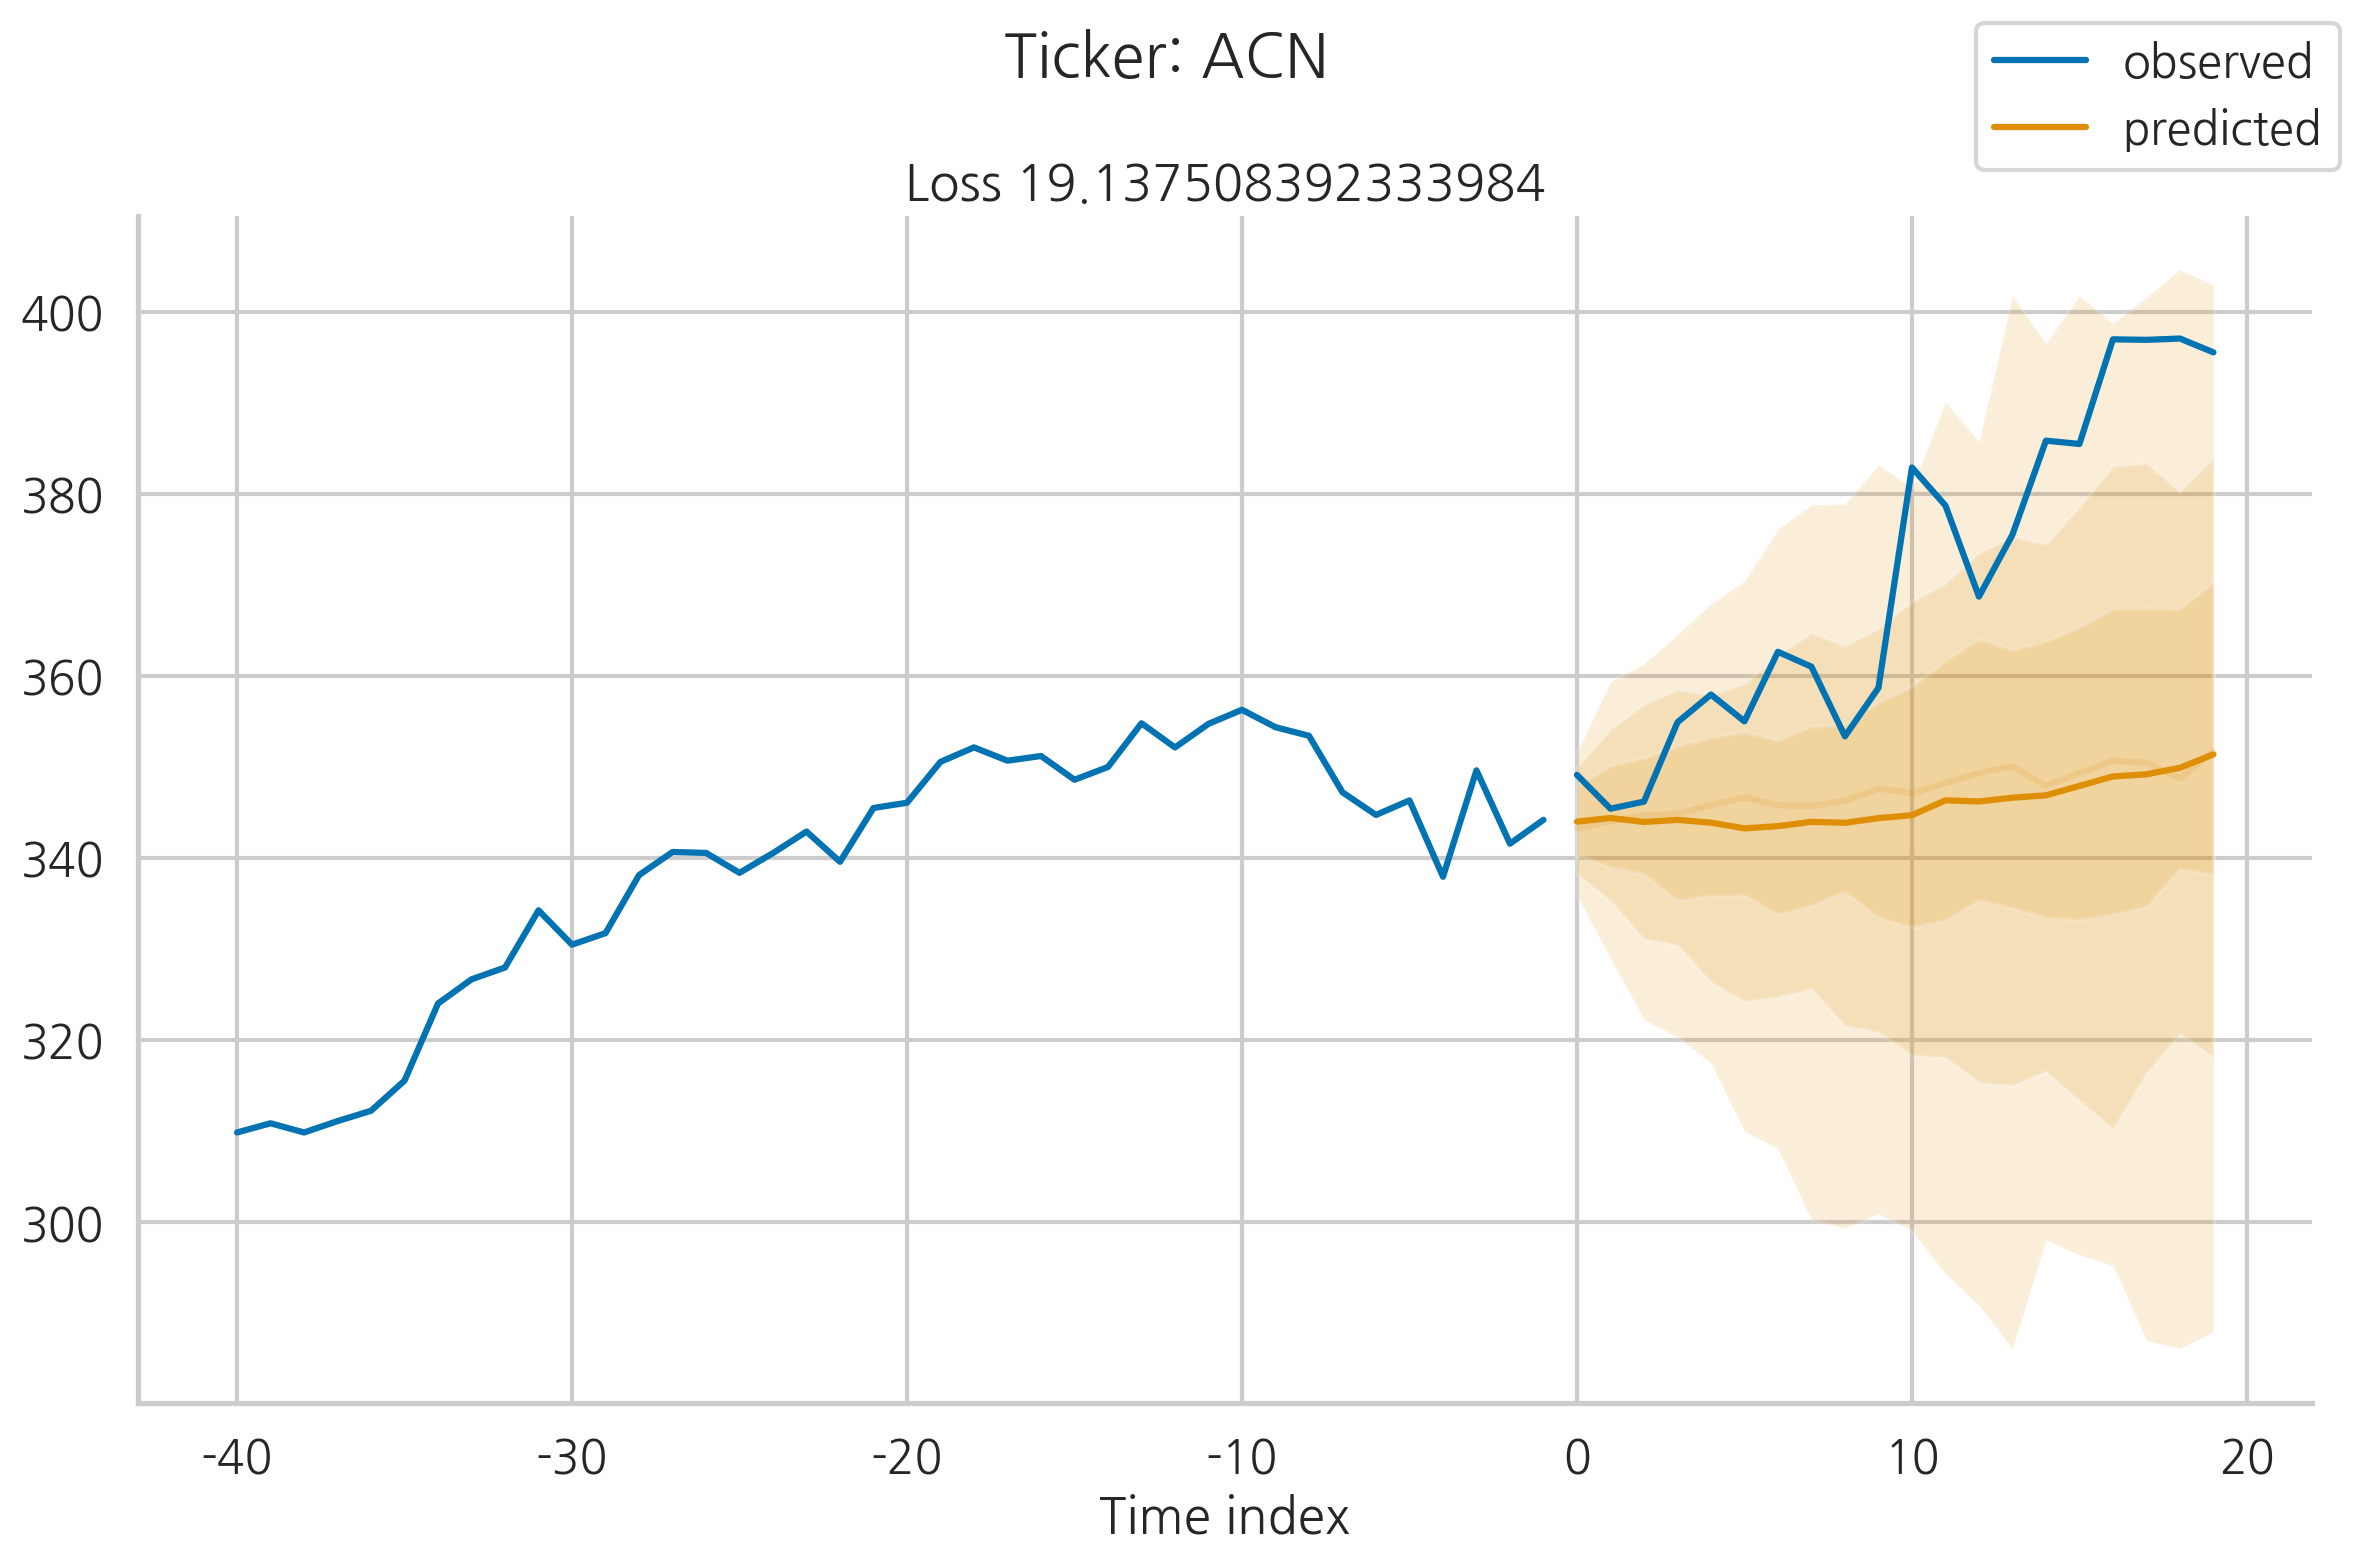

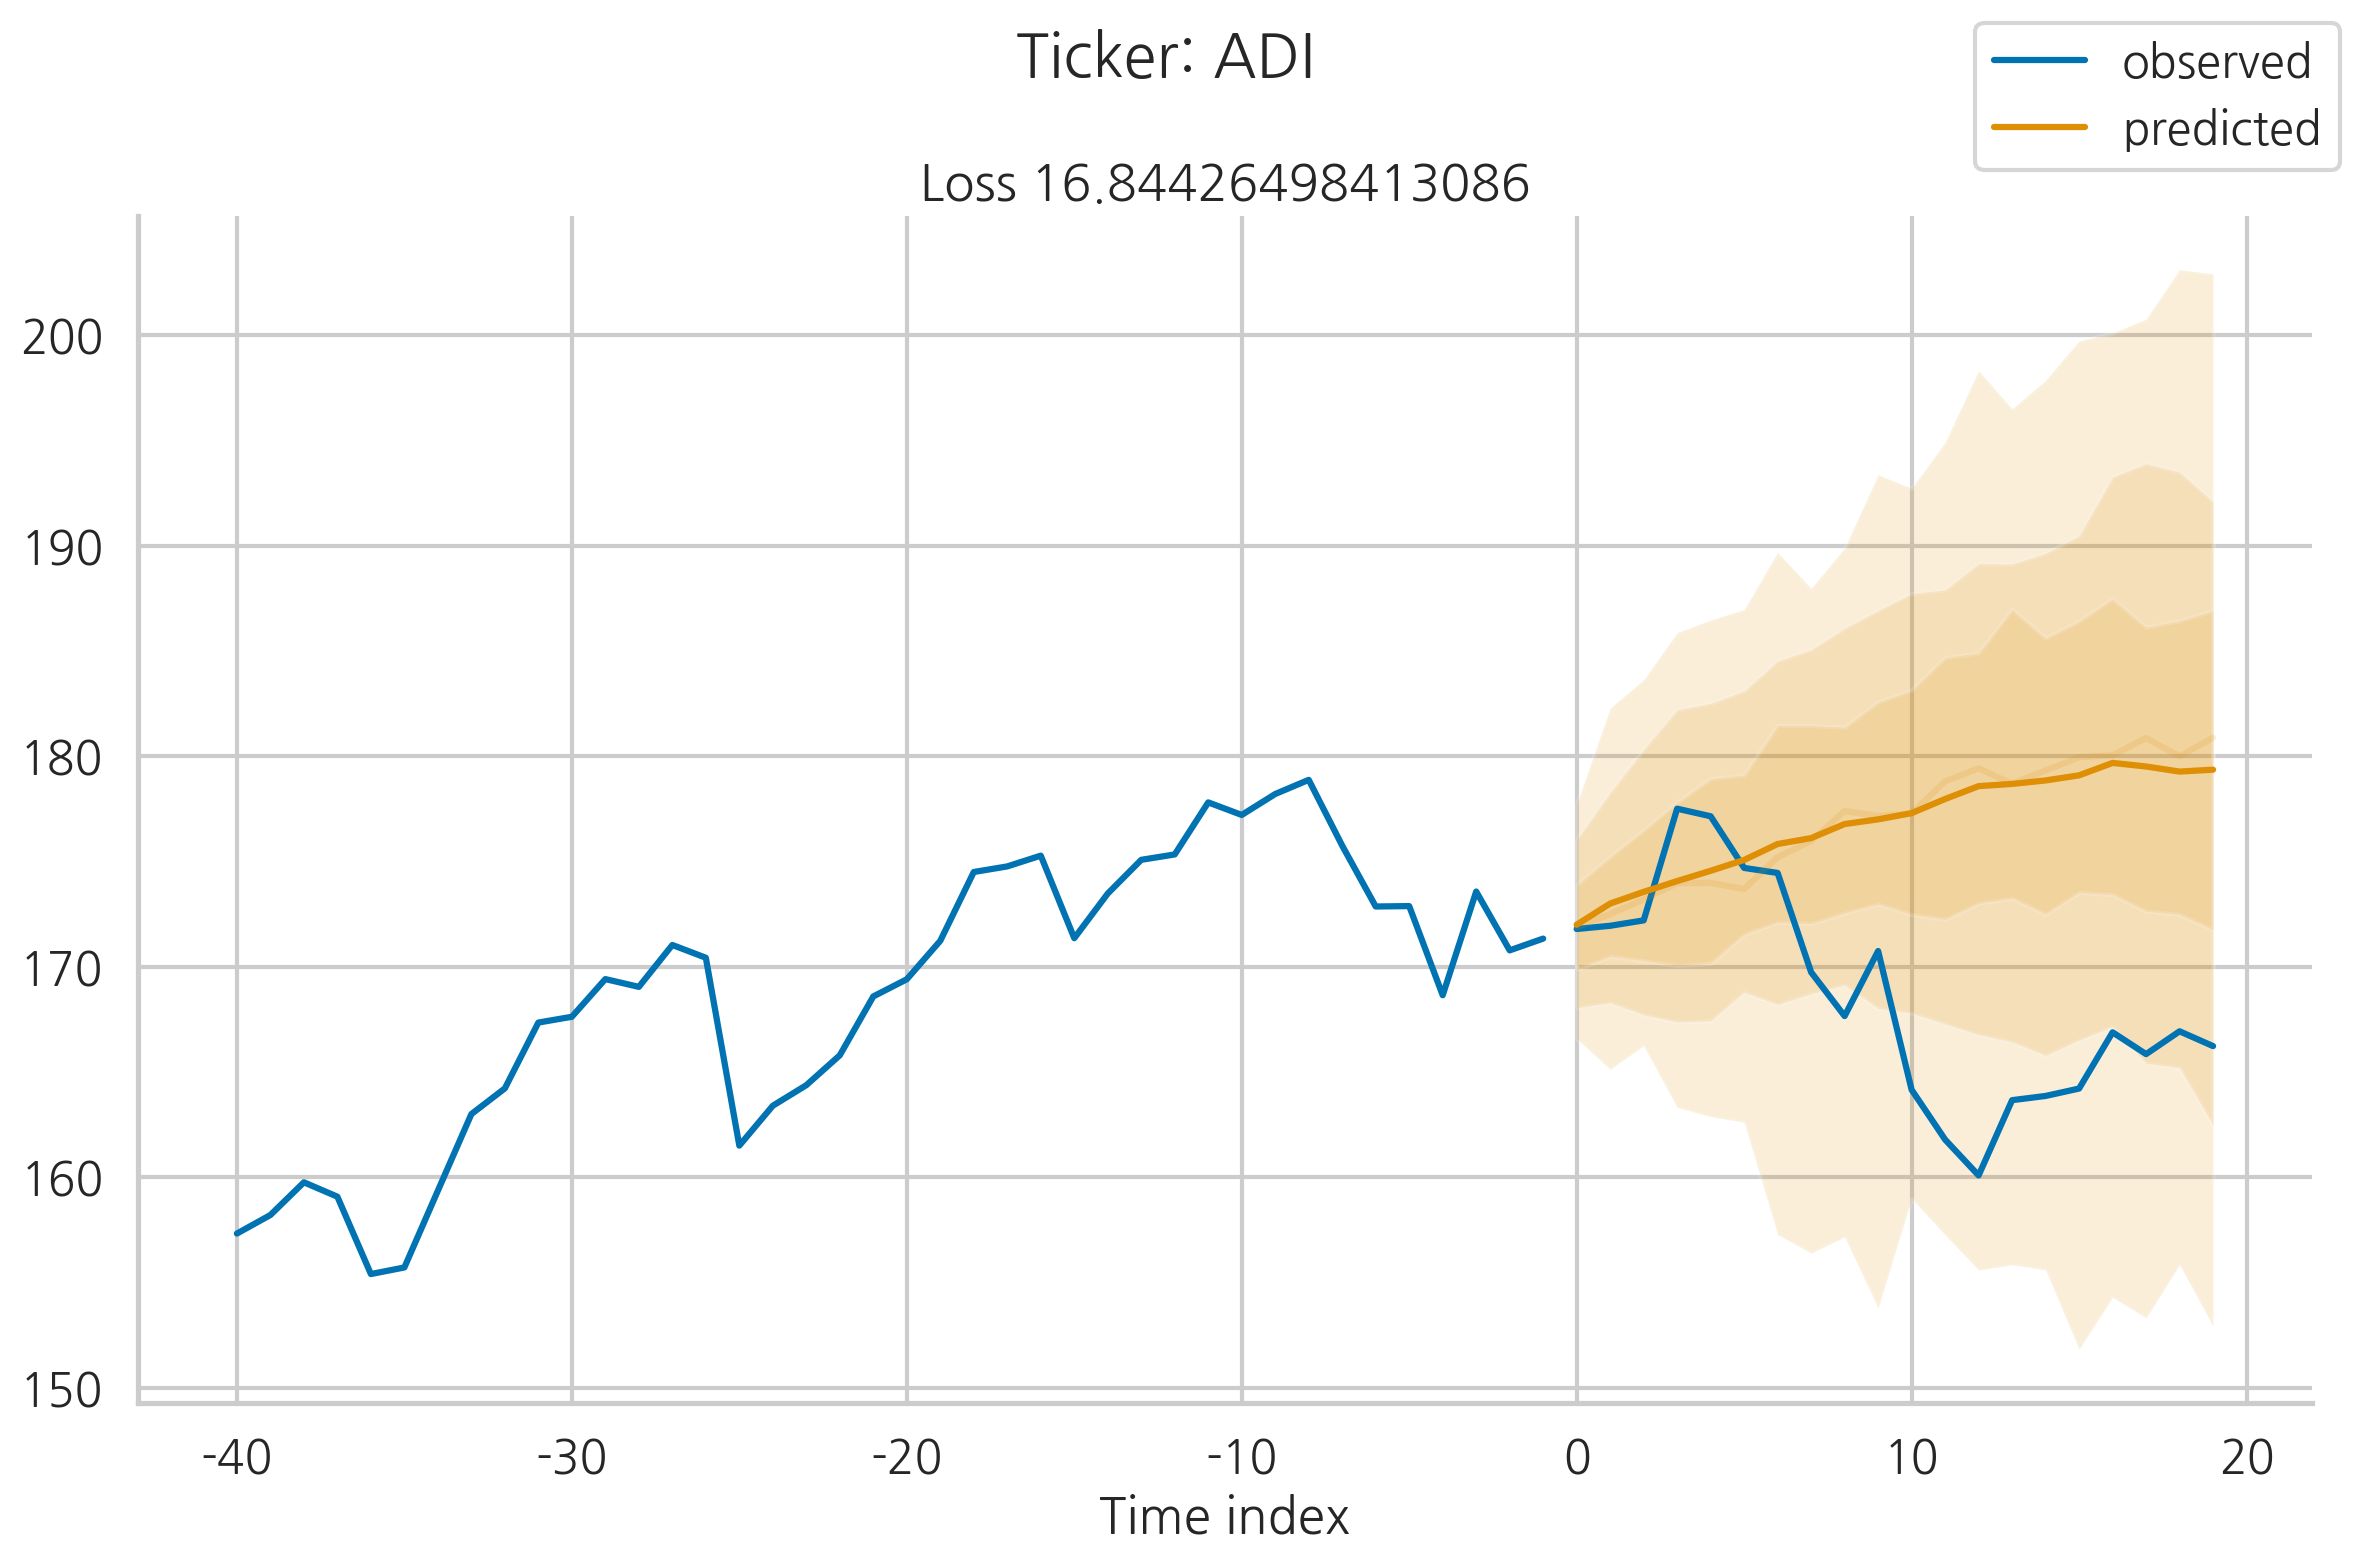

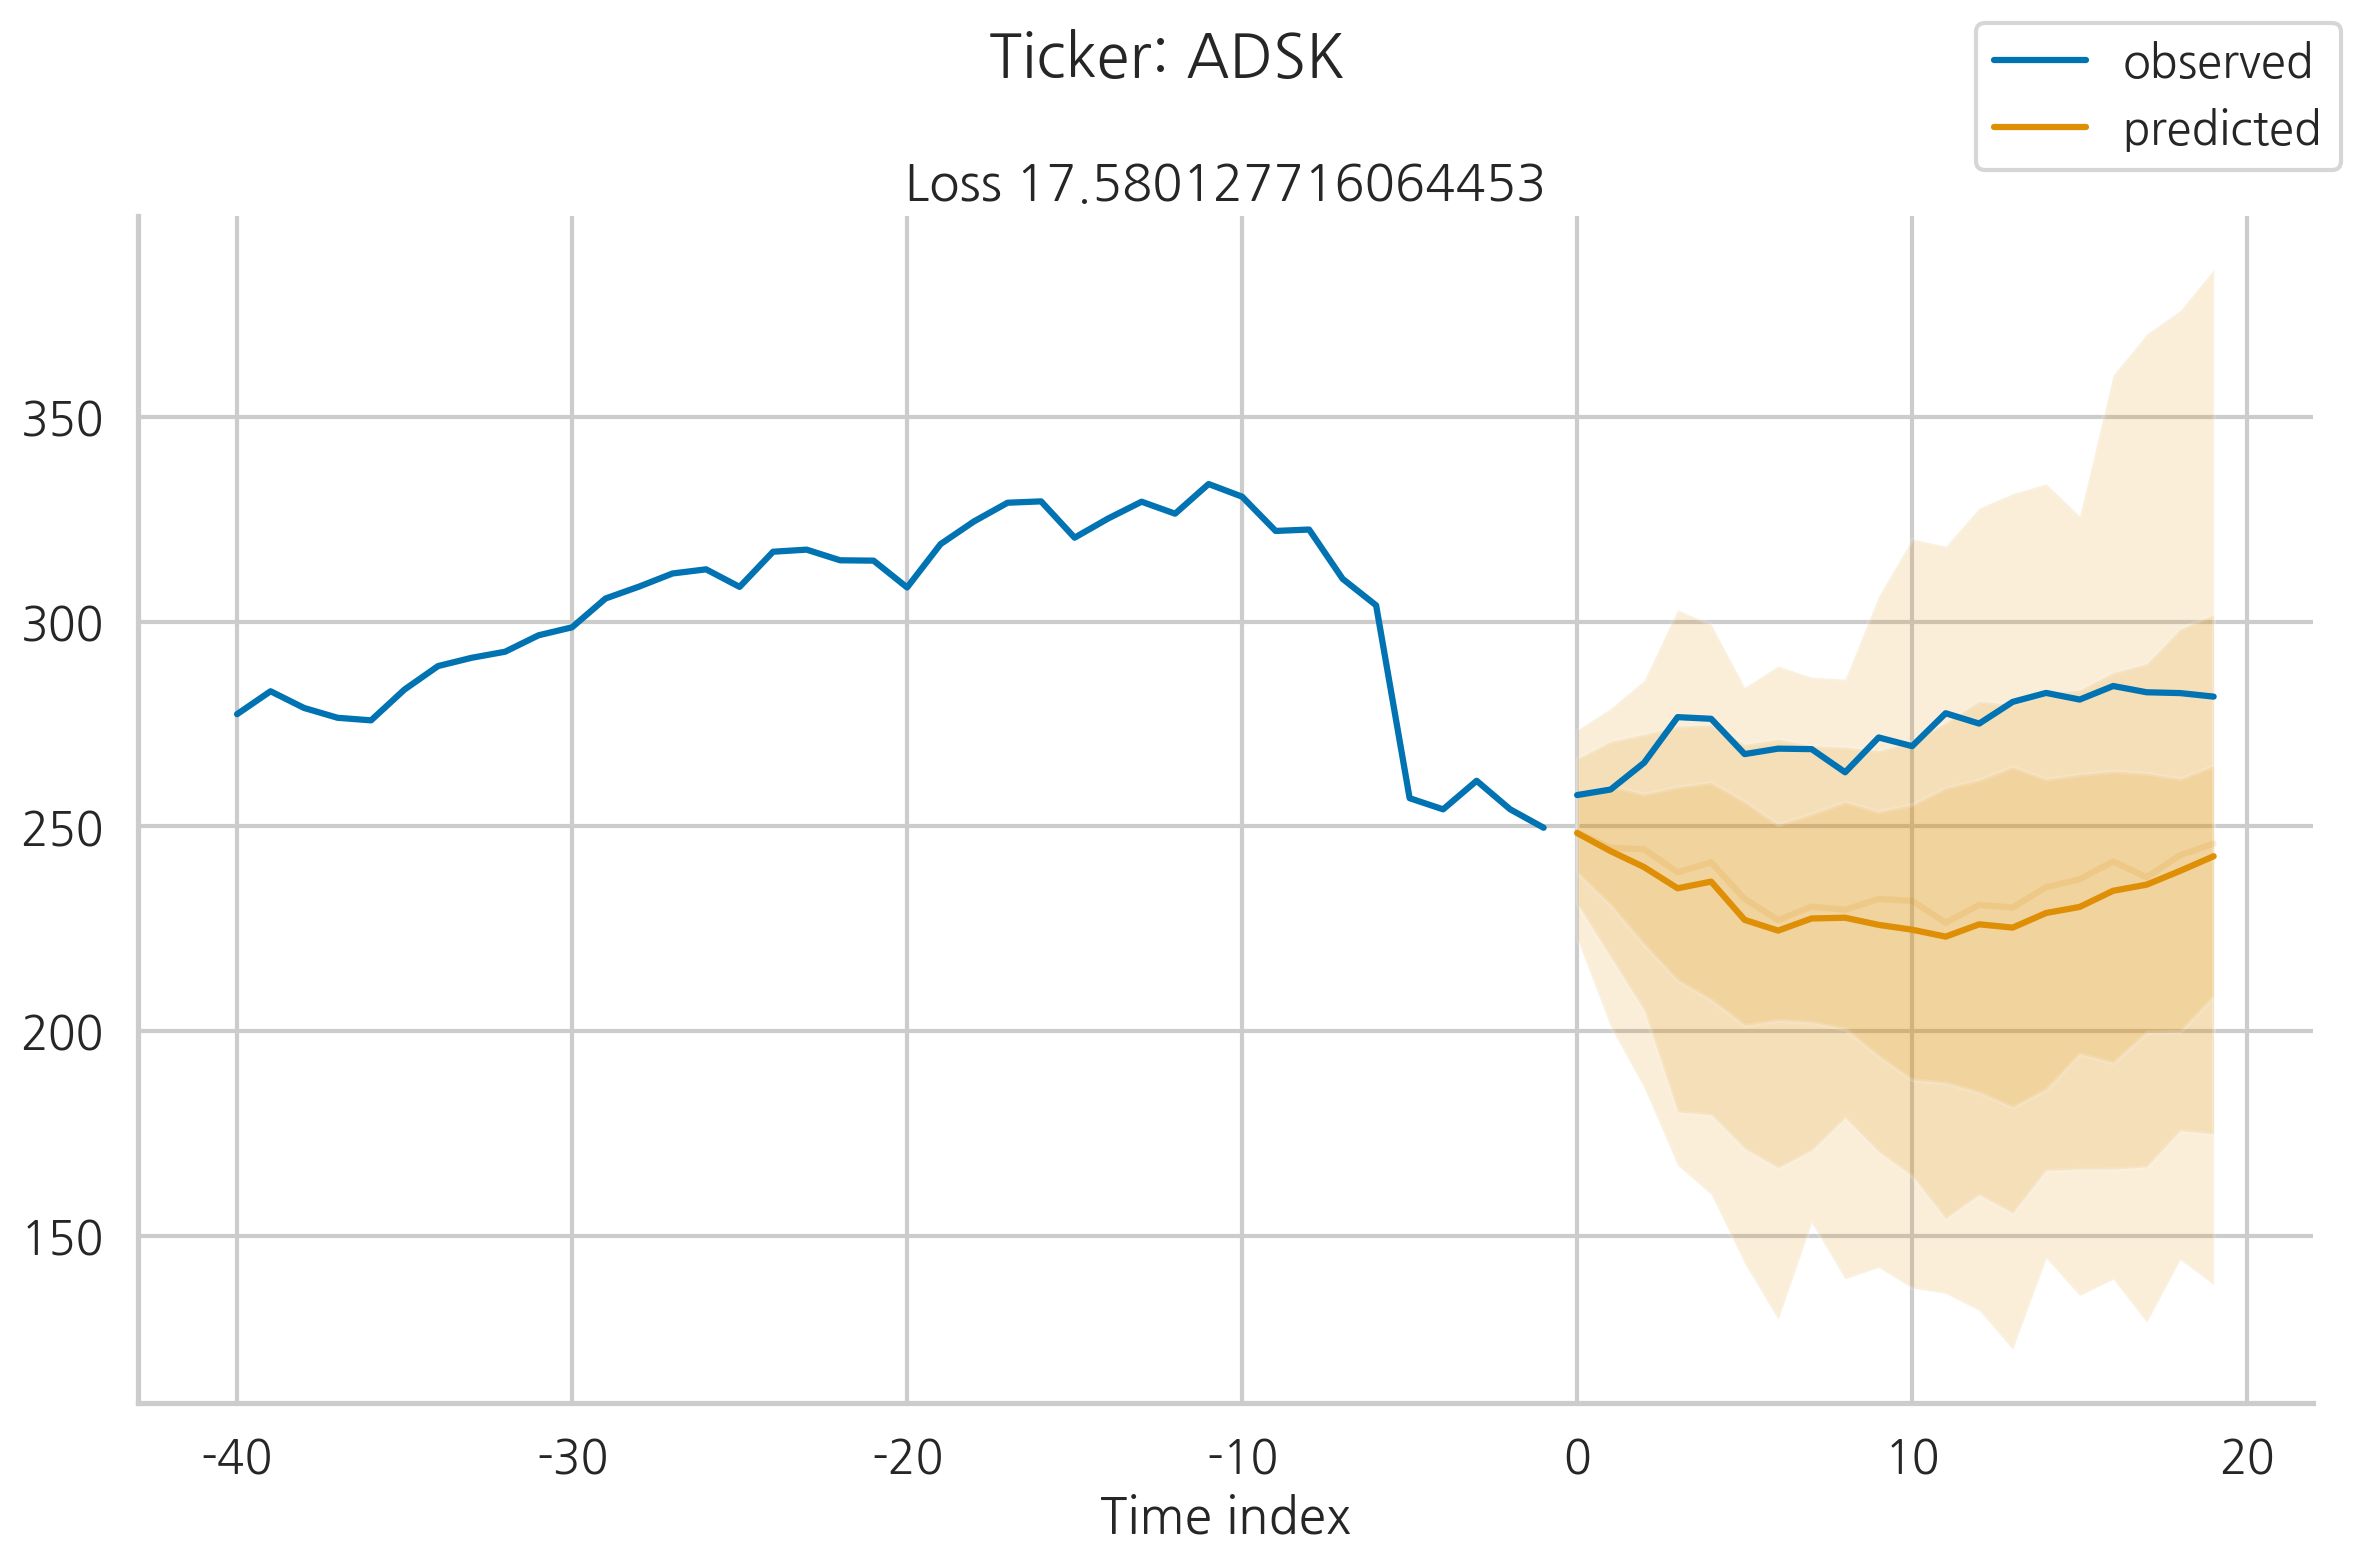

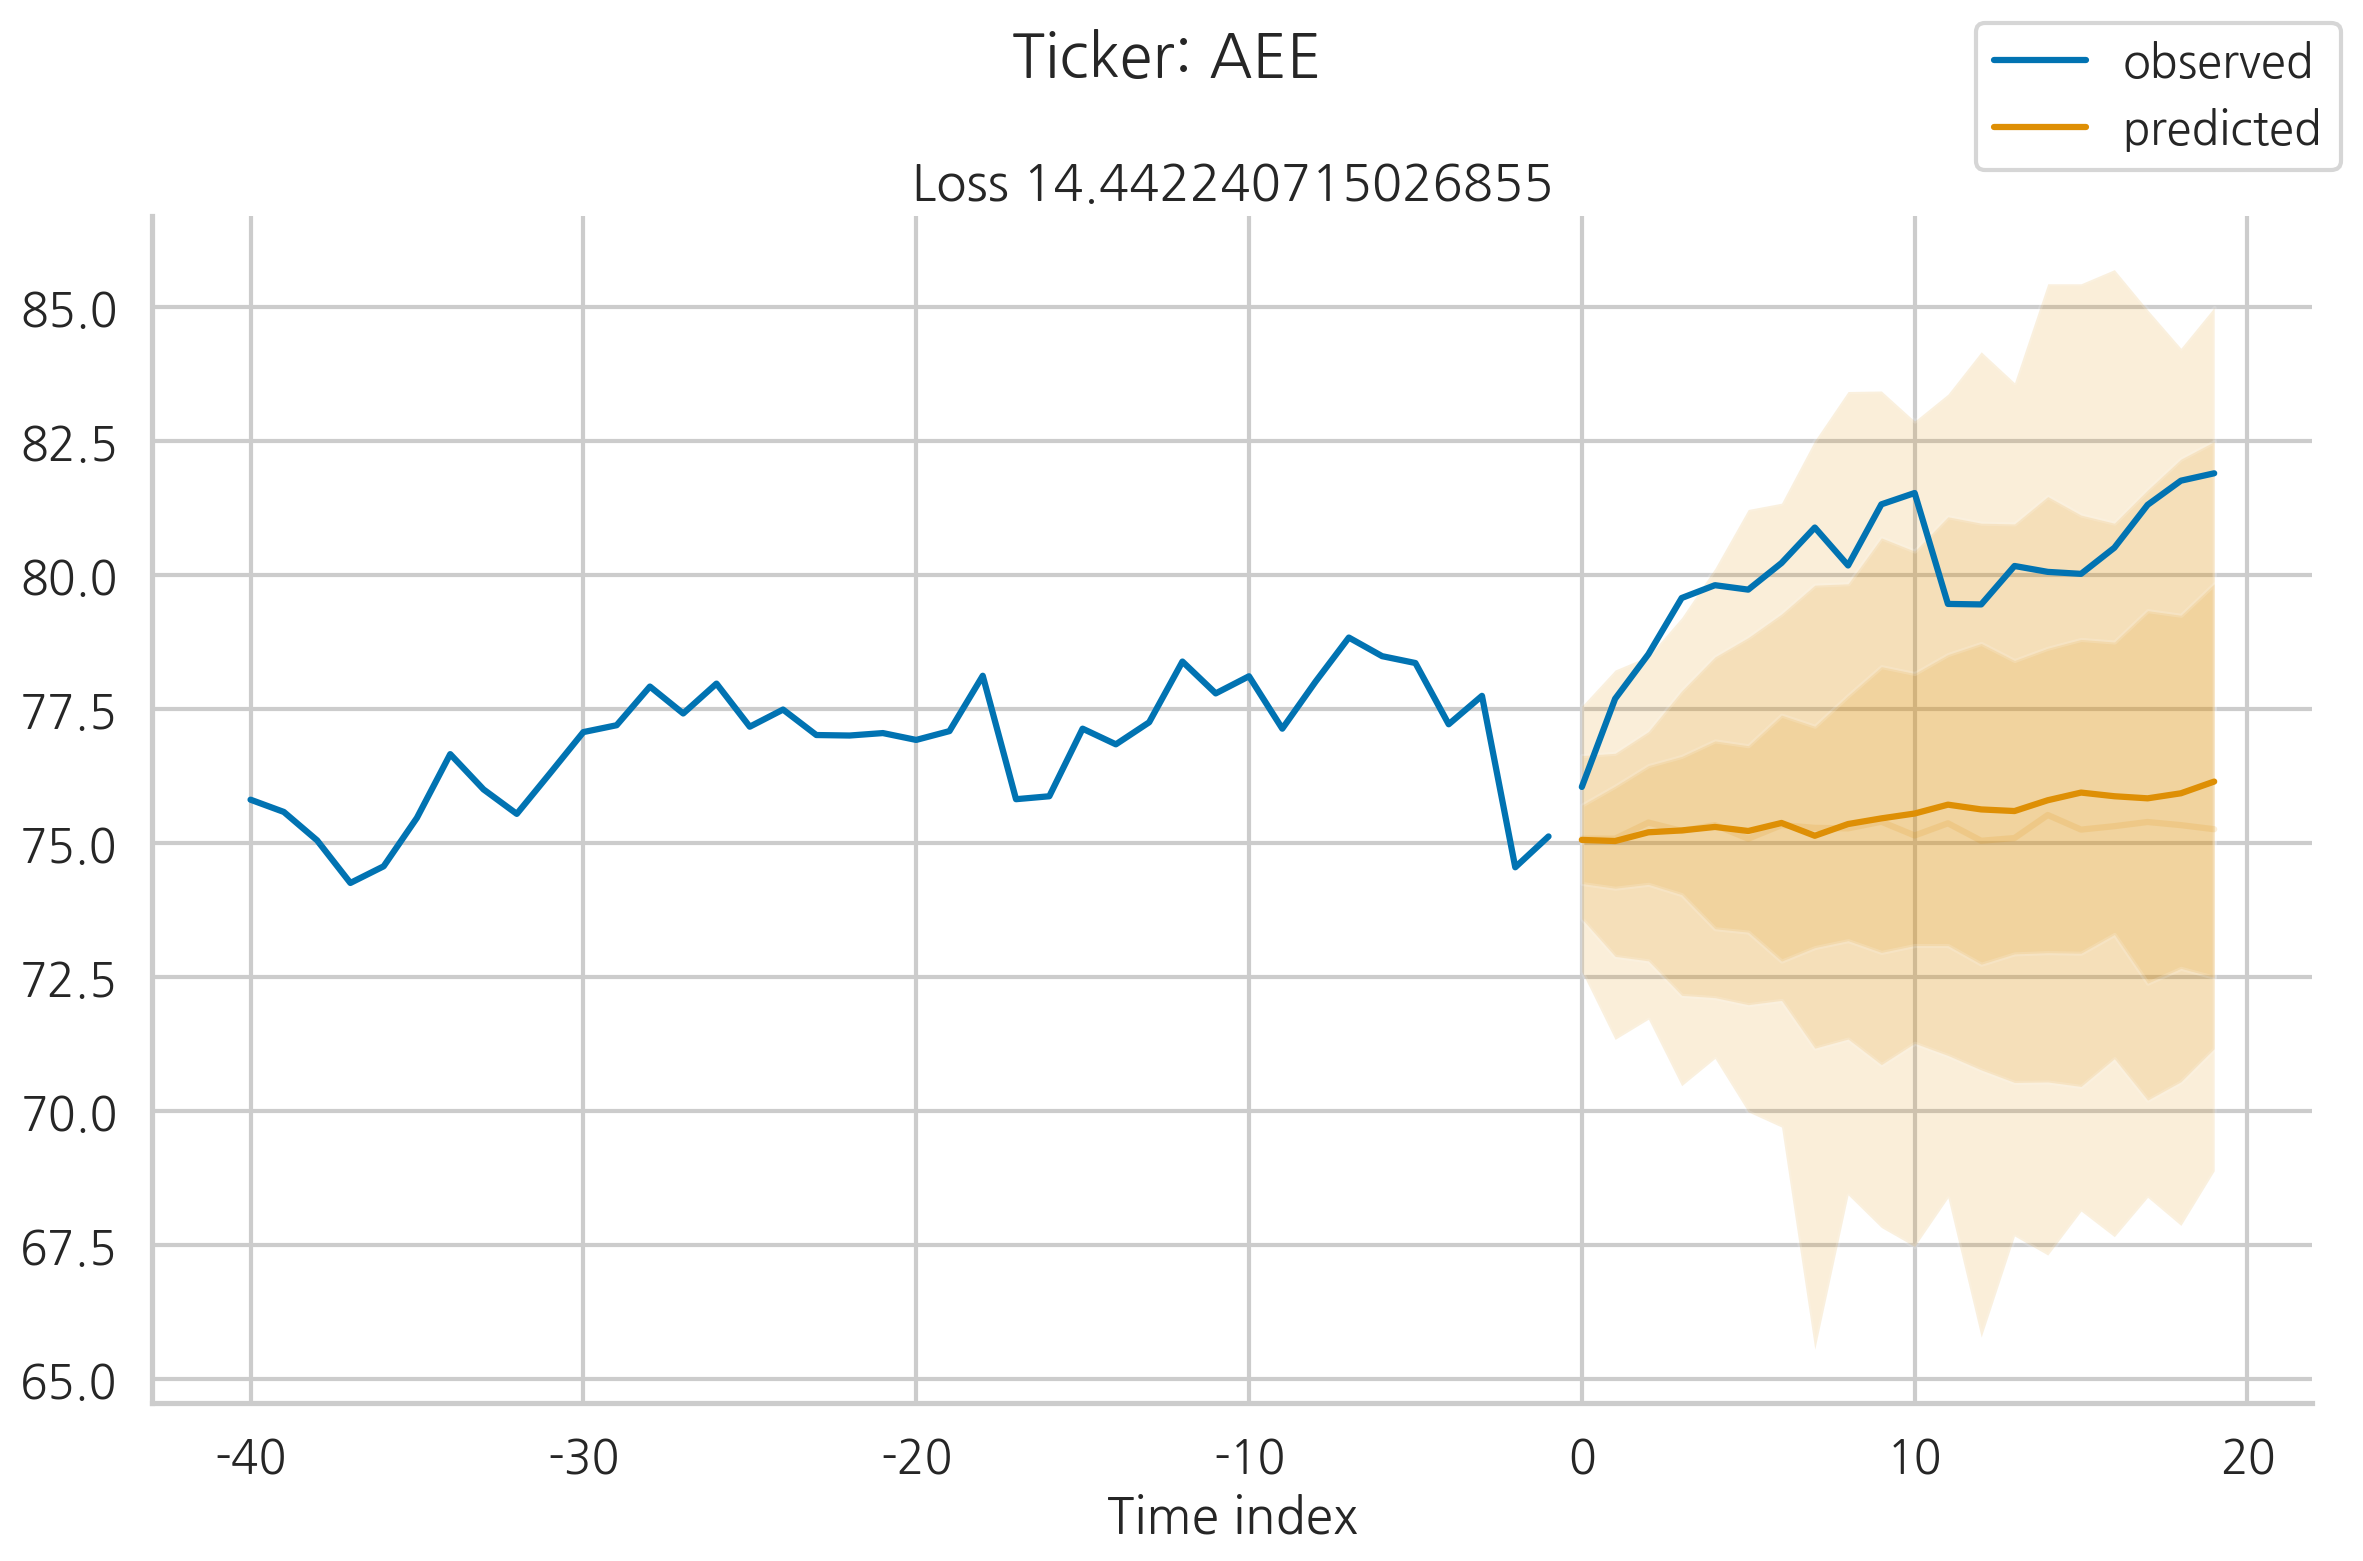

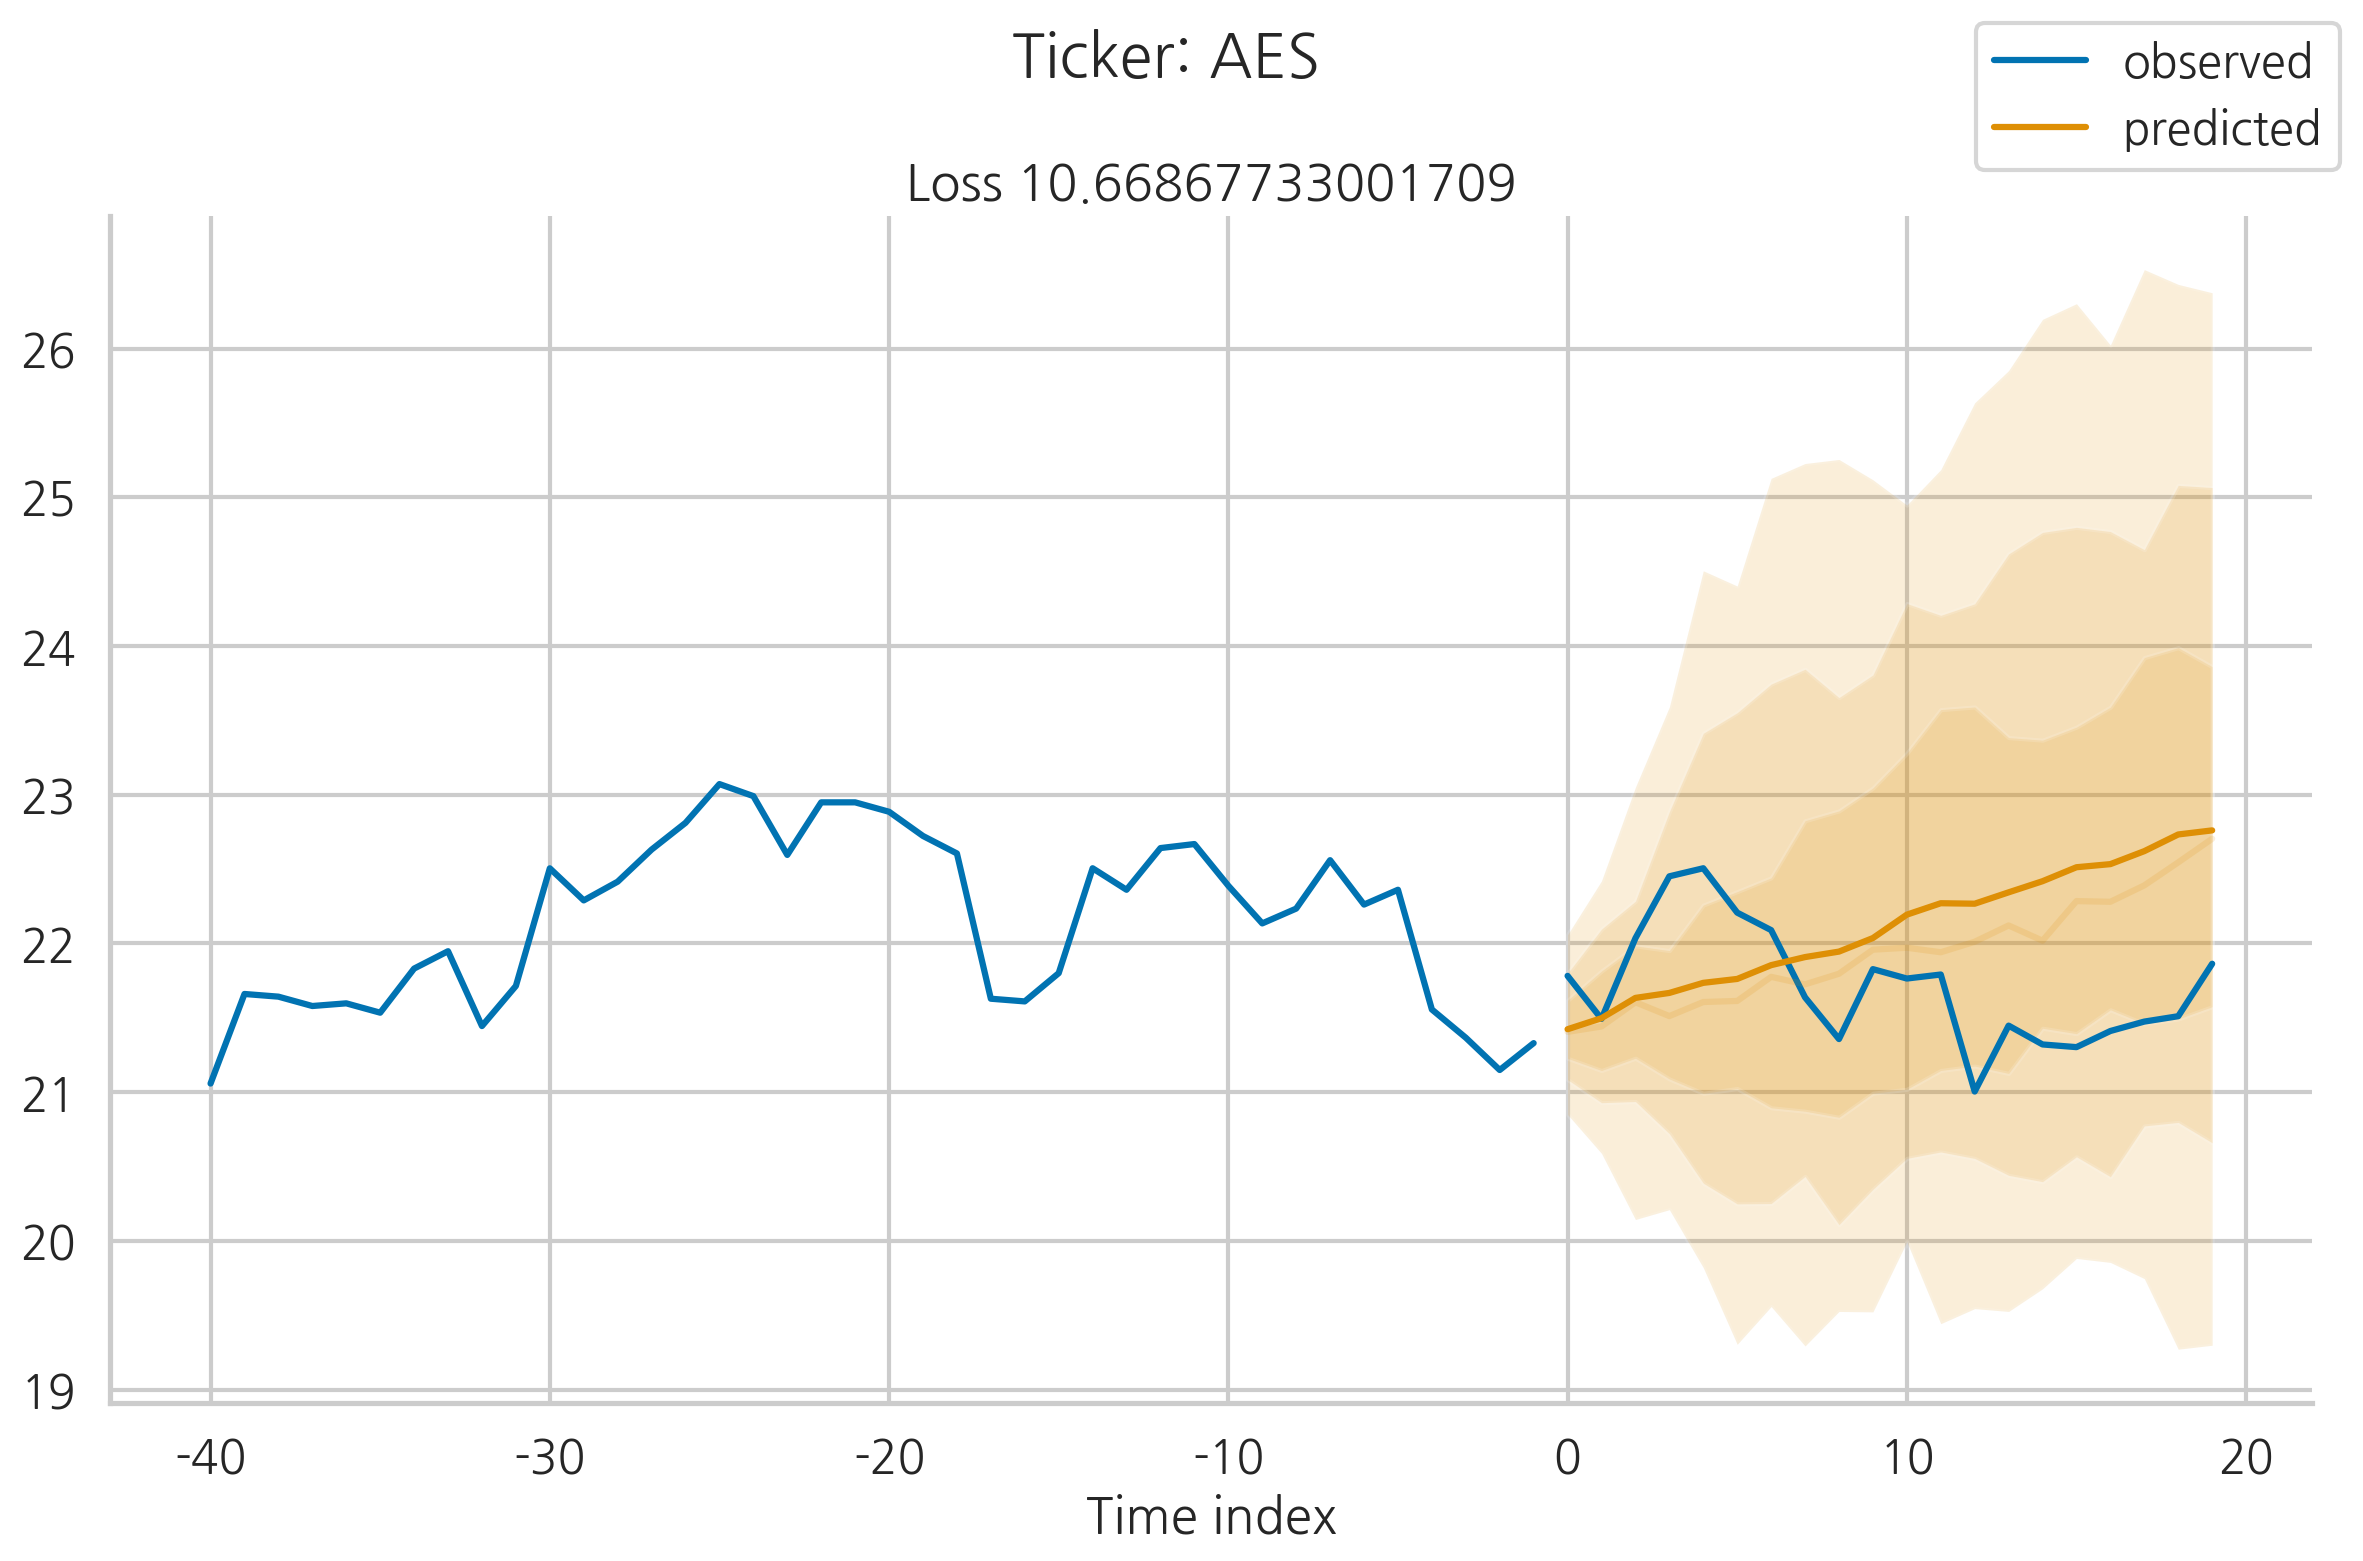

In [33]:
raw_predictions, x = best_model.predict(
    valid_dataloader, 
    mode="raw", 
    return_x=True, 
    n_samples=100
)

tickers = valid_set.x_to_index(x)["ticker"]

for idx in range(5):
    best_model.plot_prediction(
        x, raw_predictions, idx=idx, add_loss_to_title=True
    )
    plt.suptitle(f"Ticker: {tickers.iloc[idx]}")

    plt.tight_layout()
    sns.despine()
    # plt.savefig(f"images/figure_15_12_{idx}")

Figure 15.13: DeepAR’s forecast for the ADM stock 

The plots show the forecast for two stocks for the last 20 business days of 2021, together with the corresponding quantile estimates. While the forecasts do not perform that well, we can see that at the very least the actual values are within the provided quantile estimates. 

We will not spend more time evaluating the performance of the model and its forecasts, as the main idea was to present how the DeepAR model works and how to use it to generate the forecasts. However, we will mention a few potential improvements. First, we could have trained for more epochs, as we did not look into the model’s convergence. We have used early stopping, but it was not triggered while training. Second, we have used quite a few arbitrary values to define the network’s architecture. In a real-life scenario, we should use a hyperparameter optimization routine of our choice to identify the best values for our task at hand.

### There's more

1. Import the libraries:

In [16]:
from pytorch_forecasting.metrics import MultivariateNormalDistributionLoss
import seaborn as sns
import numpy as np

In [17]:
# df = generate_ar_data(
#     seasonality=10.0, 
#     timesteps=len(raw_df), 
#     n_series=len(selected_tickers), 
#     seed=42
# )
# df["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(df.time_idx, "D")
# df = df.astype(dict(series=str))
# df.columns = ["ticker", "time_idx", "price", "date"]
# df

2. Define the DataLoaders again, this time specifying the `batch_sampler`:

In [18]:
train_set = TimeSeriesDataSet(
    df[lambda x: x["time_idx"] <= training_cutoff],
    time_idx="time_idx",
    target="price",
    group_ids=["ticker"],
    static_categoricals=["ticker"],  
    time_varying_unknown_reals=["price"],
    max_encoder_length=MAX_ENCODER_LENGTH,
    max_prediction_length=MAX_PRED_LENGTH,
)

valid_set = TimeSeriesDataSet.from_dataset(
    train_set, df, min_prediction_idx=training_cutoff+1
)

train_dataloader = train_set.to_dataloader(
    train=True, 
    batch_size=BATCH_SIZE,
    batch_sampler="synchronized"
)
valid_dataloader = valid_set.to_dataloader(
    train=False, 
    batch_size=BATCH_SIZE, 
    batch_sampler="synchronized"
)

3. Define the DeepVAR model and find the learning rate:

Global seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Finding best initial lr: 100%|██████████| 100/100 [00:12<00:00,  8.25it/s]
Restoring states from the checkpoint path at /Users/eryk/Documents/eryk/python_for_finance_2nd_private/15_deep_learning_in_finance/.lr_find_738ad47e-9c6c-4cf2-845a-96c7059437c6.ckpt


Suggested learning rate: 8.912509381337456e-05


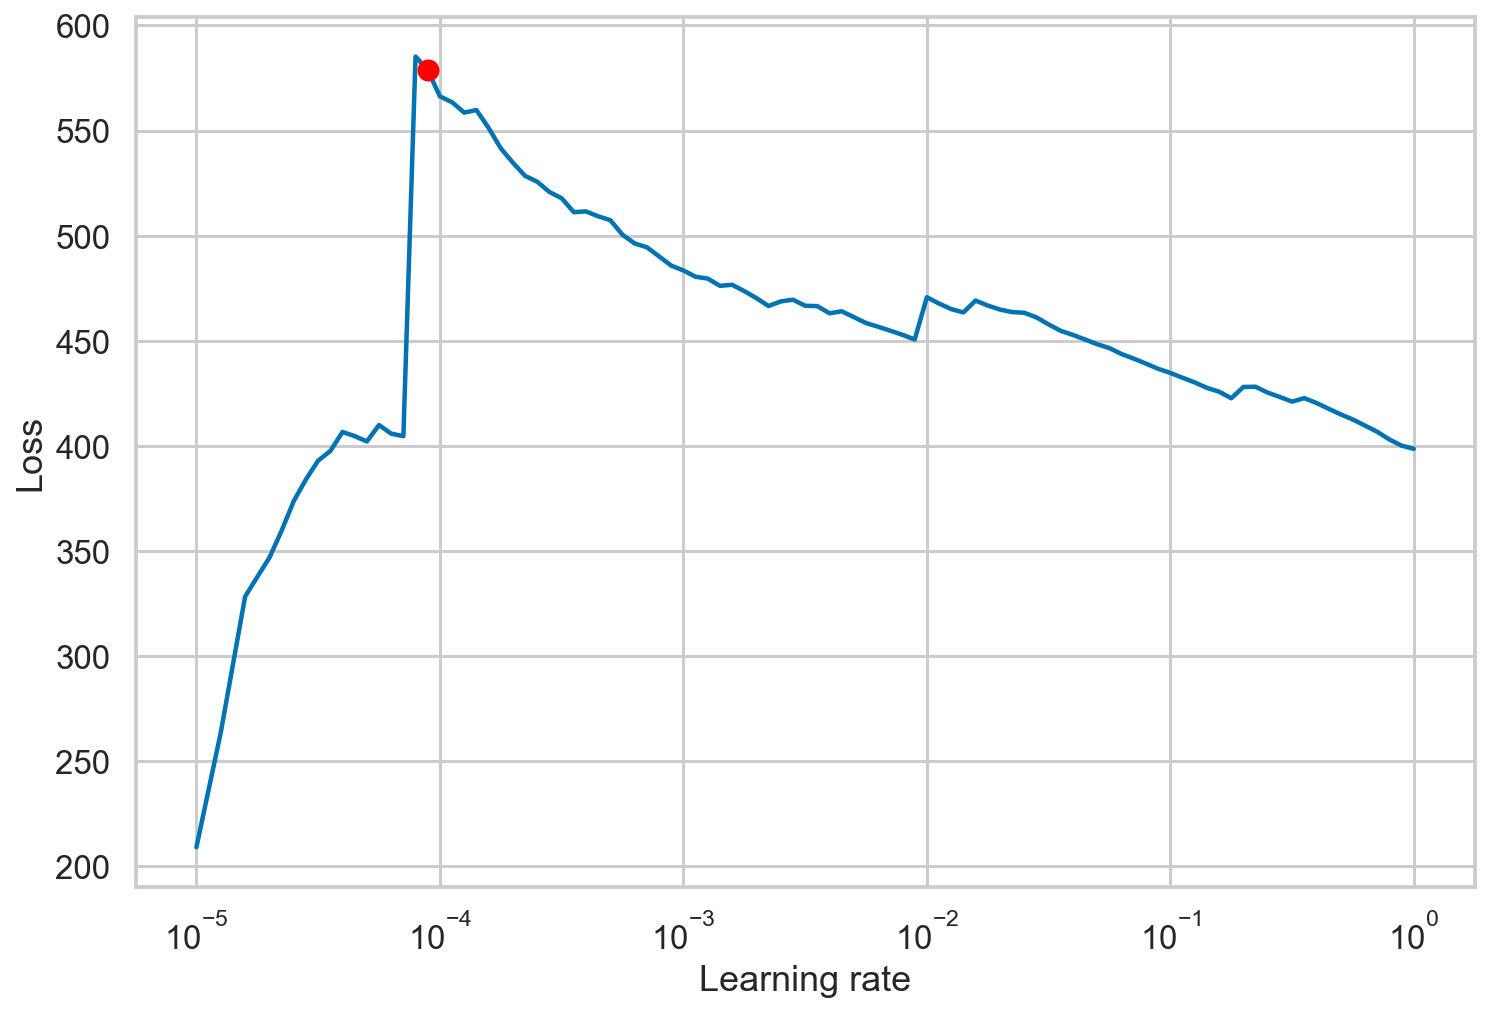

In [19]:
pl.seed_everything(42)

deep_var = DeepAR.from_dataset(
    train_set, 
    learning_rate=1e-2, 
    hidden_size=30, 
    rnn_layers=4,
    loss=MultivariateNormalDistributionLoss()
)

trainer = pl.Trainer(gradient_clip_val=1e-1)
res = trainer.tuner.lr_find(
    deep_var,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)

print(f"Suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)

4. Train the DeepVAR model using the selected learning rate:

In [20]:
pl.seed_everything(42)

deep_var.hparams.learning_rate = res.suggestion()

early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    min_delta=1e-4, 
    patience=10
)

trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback]
)

trainer.fit(
    deep_var,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)

Global seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 2.0 K 
3 | rnn                    | LSTM                               | 28.8 K
4 | distribution_projector | Linear                             | 372   
------------------------------------------------------------------------------
31.2 K    Trainable params
0         Non-trainable params
31.2 K    Total params
0.125     Total estimated model params size (MB)


Epoch 29: 100%|██████████| 427/427 [00:57<00:00,  7.43it/s, loss=222, v_num=1, train_loss_step=248.0, val_loss=196.0, train_loss_epoch=214.0]  

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 427/427 [00:57<00:00,  7.43it/s, loss=222, v_num=1, train_loss_step=248.0, val_loss=196.0, train_loss_epoch=214.0]


5. Extract the best DeepVAR model from a checkpoint:

In [21]:
best_model = DeepAR.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
)

6. Create the predictions for the validation set and plot 5 of them:

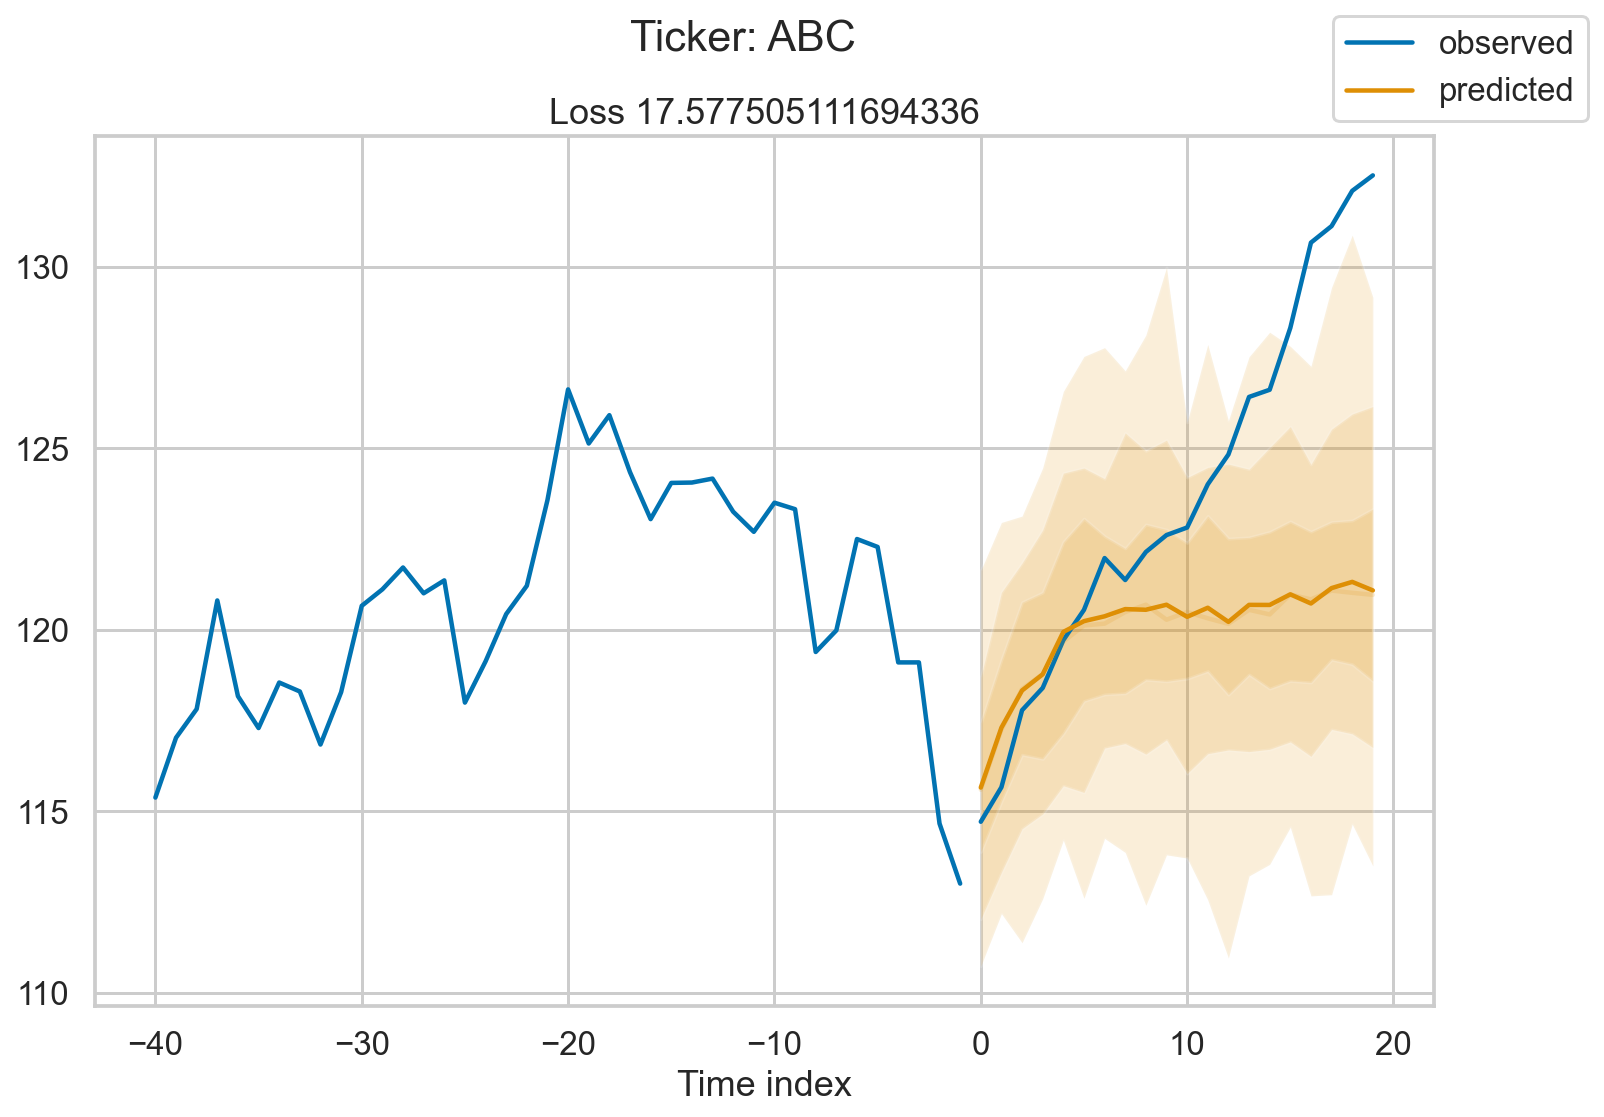

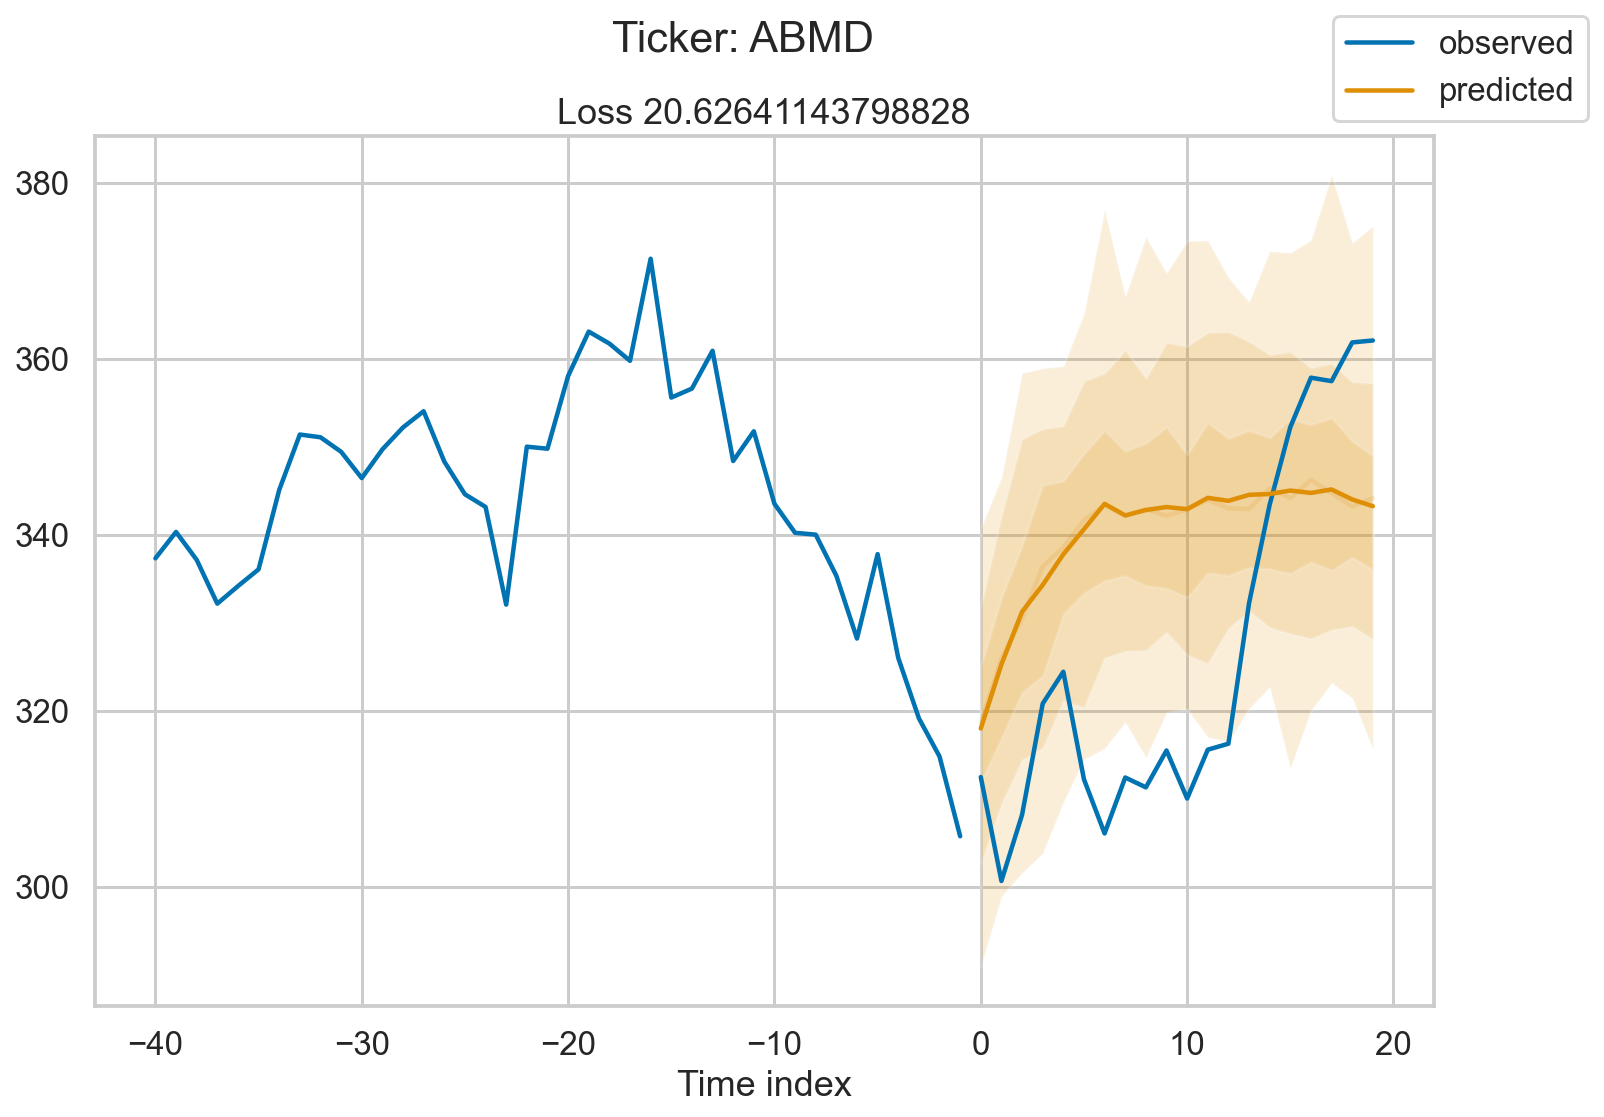

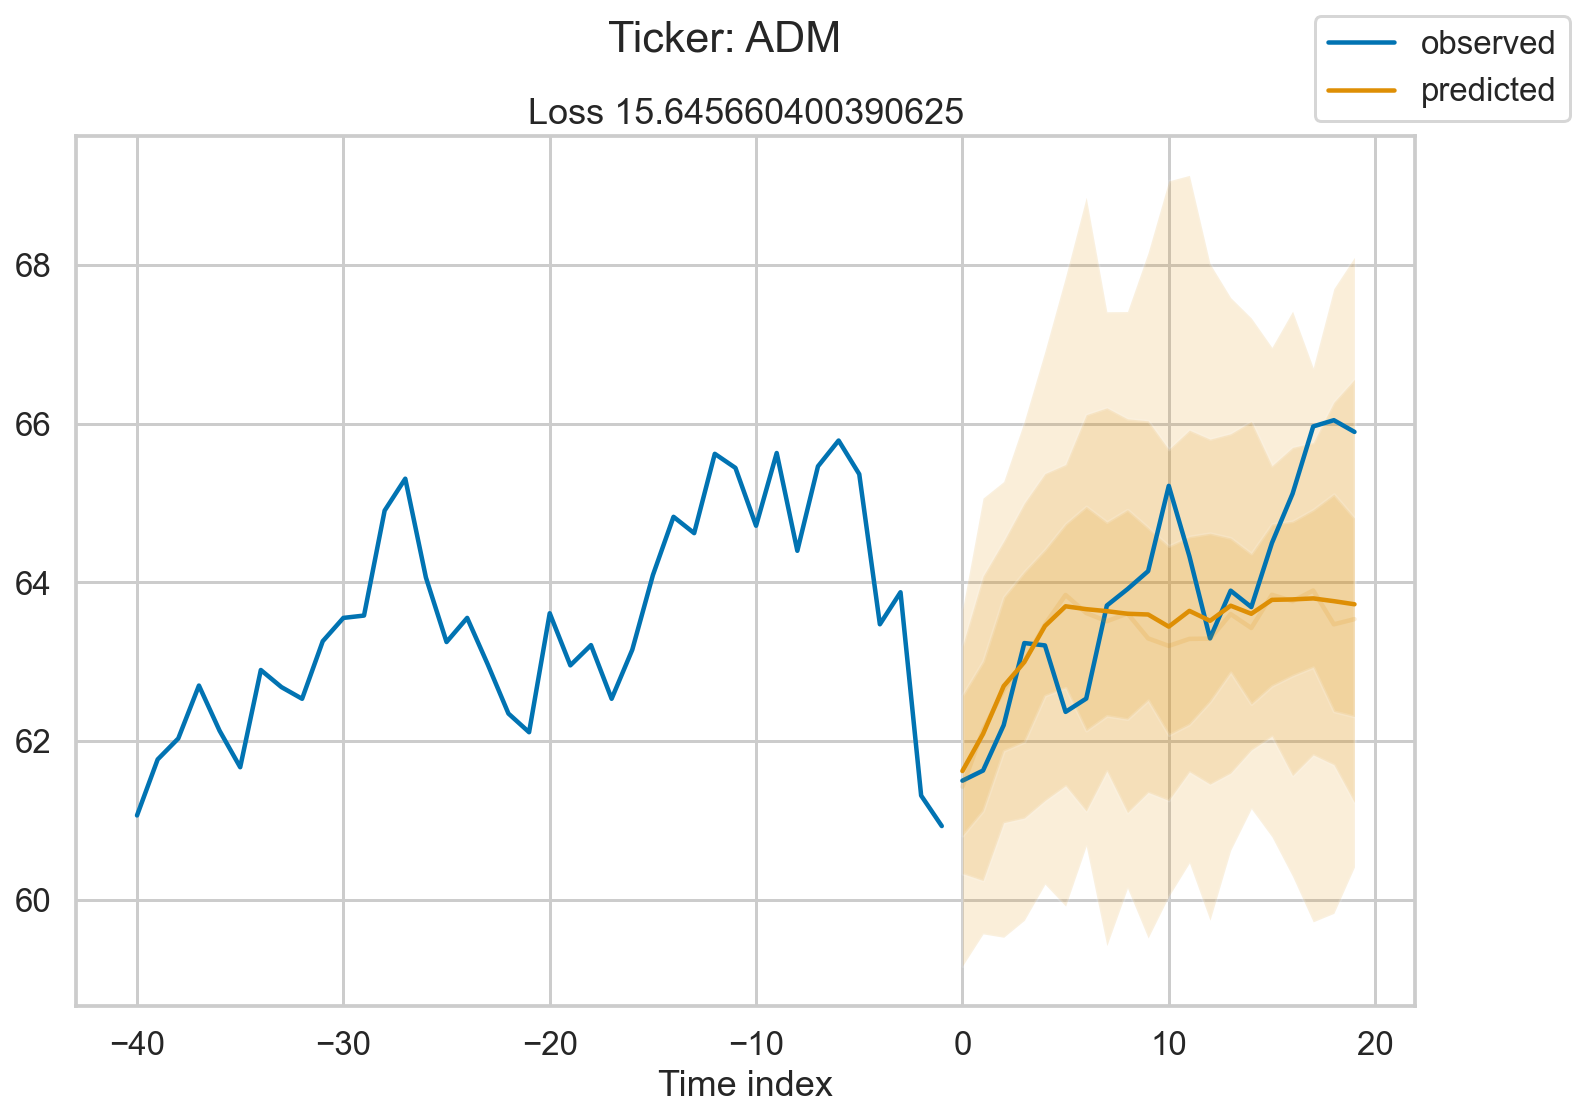

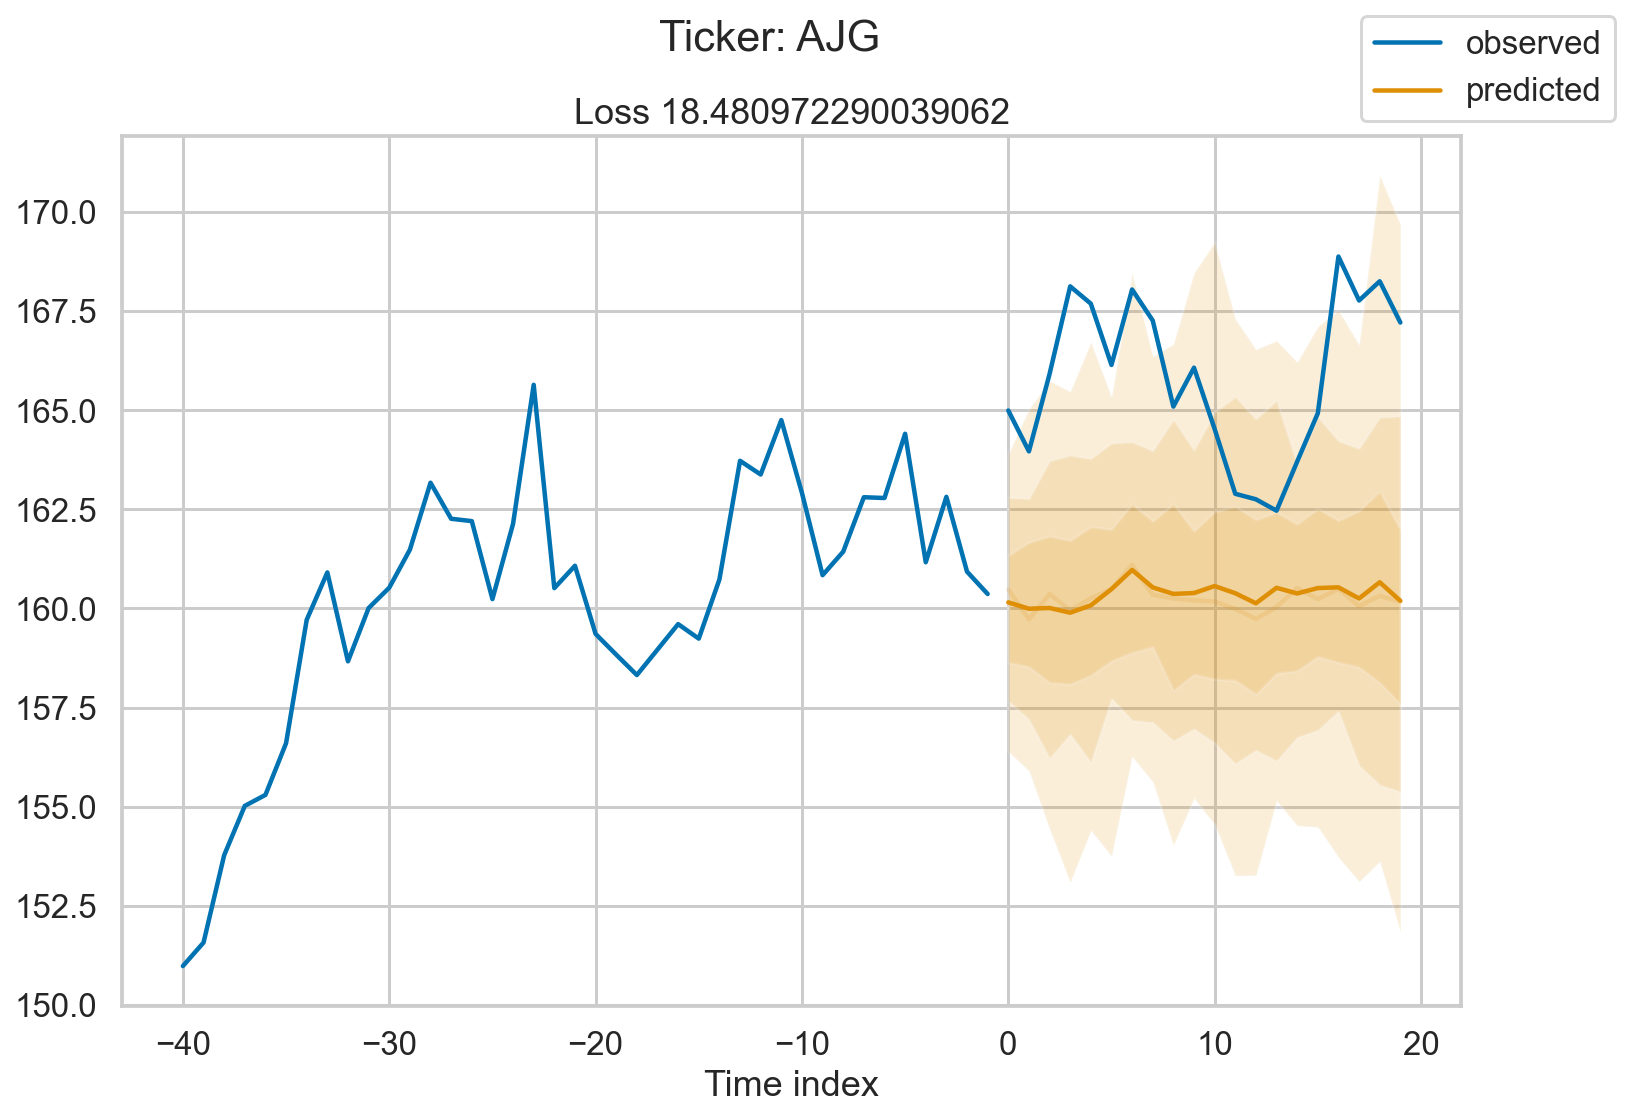

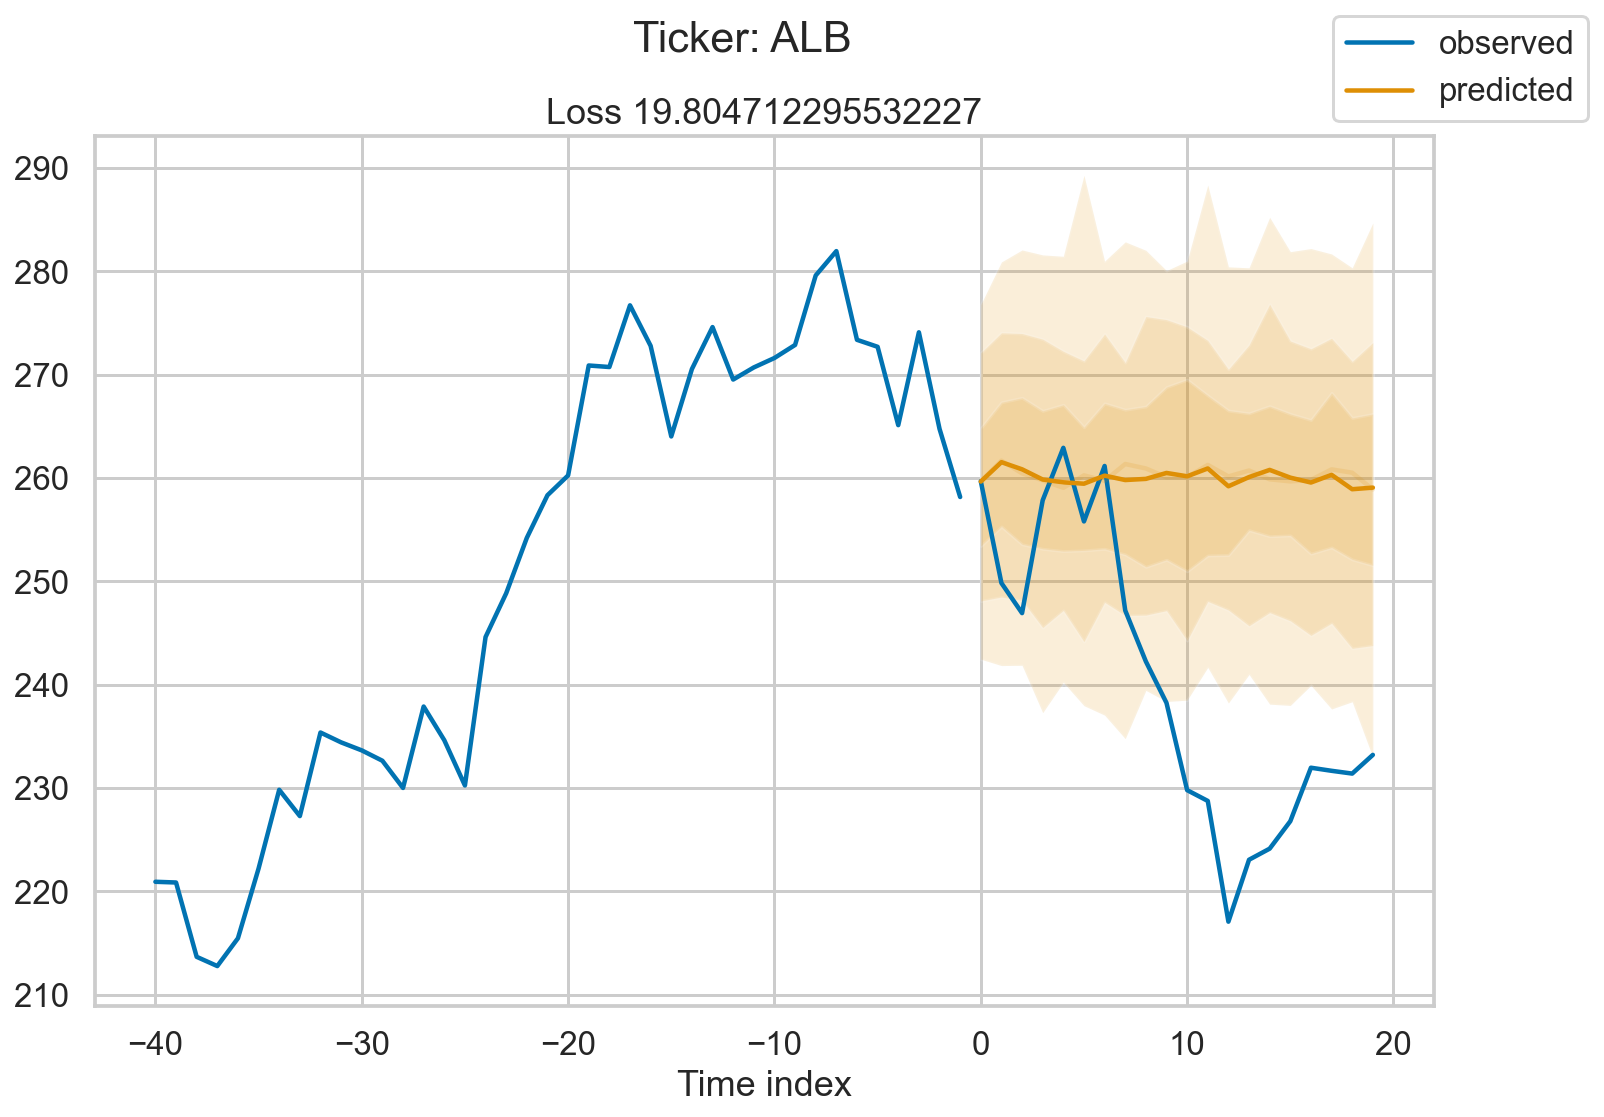

In [22]:
raw_predictions, x = best_model.predict(
    valid_dataloader, 
    mode="raw", 
    return_x=True, 
    n_samples=100
)
tickers = valid_set.x_to_index(x)["ticker"]

for idx in range(5):
    best_model.plot_prediction(
        x, raw_predictions, idx=idx, add_loss_to_title=True
    )
    plt.suptitle(f"Ticker: {tickers.iloc[idx]}")

7. Extract the correlation matrix:

In [23]:
preds = best_model.predict(valid_dataloader, 
                           mode=("raw", "prediction"), 
                           n_samples=None)
                           
cov_matrix = (
    best_model
    .loss
    .map_x_to_distribution(preds)
    .base_dist
    .covariance_matrix
    .mean(0)
)

# normalize the covariance matrix diagonal to 1.0
cov_diag_mult = (
    torch.diag(cov_matrix)[None] * torch.diag(cov_matrix)[None].T
)
corr_matrix = cov_matrix / torch.sqrt(cov_diag_mult)


8. Plot the correlation matrix:

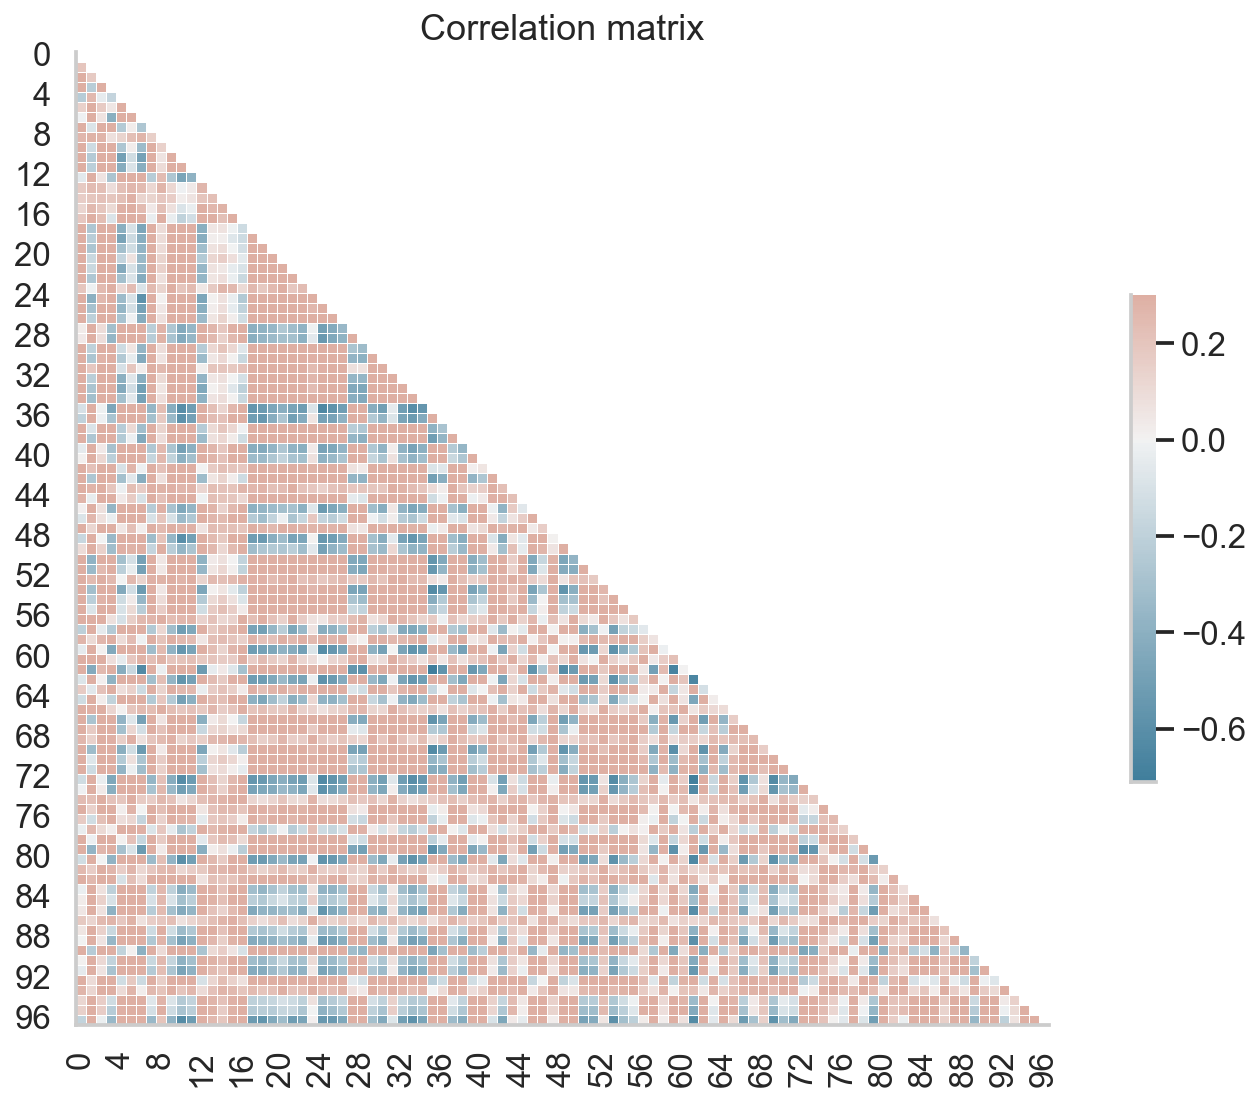

In [24]:
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fif, ax = plt.subplots()

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
    corr_matrix, mask=mask, cmap=cmap, 
    vmax=.3, center=0, square=True, 
    linewidths=.5, cbar_kws={"shrink": .5}
)

ax.set_title("Correlation matrix")

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_15_14")

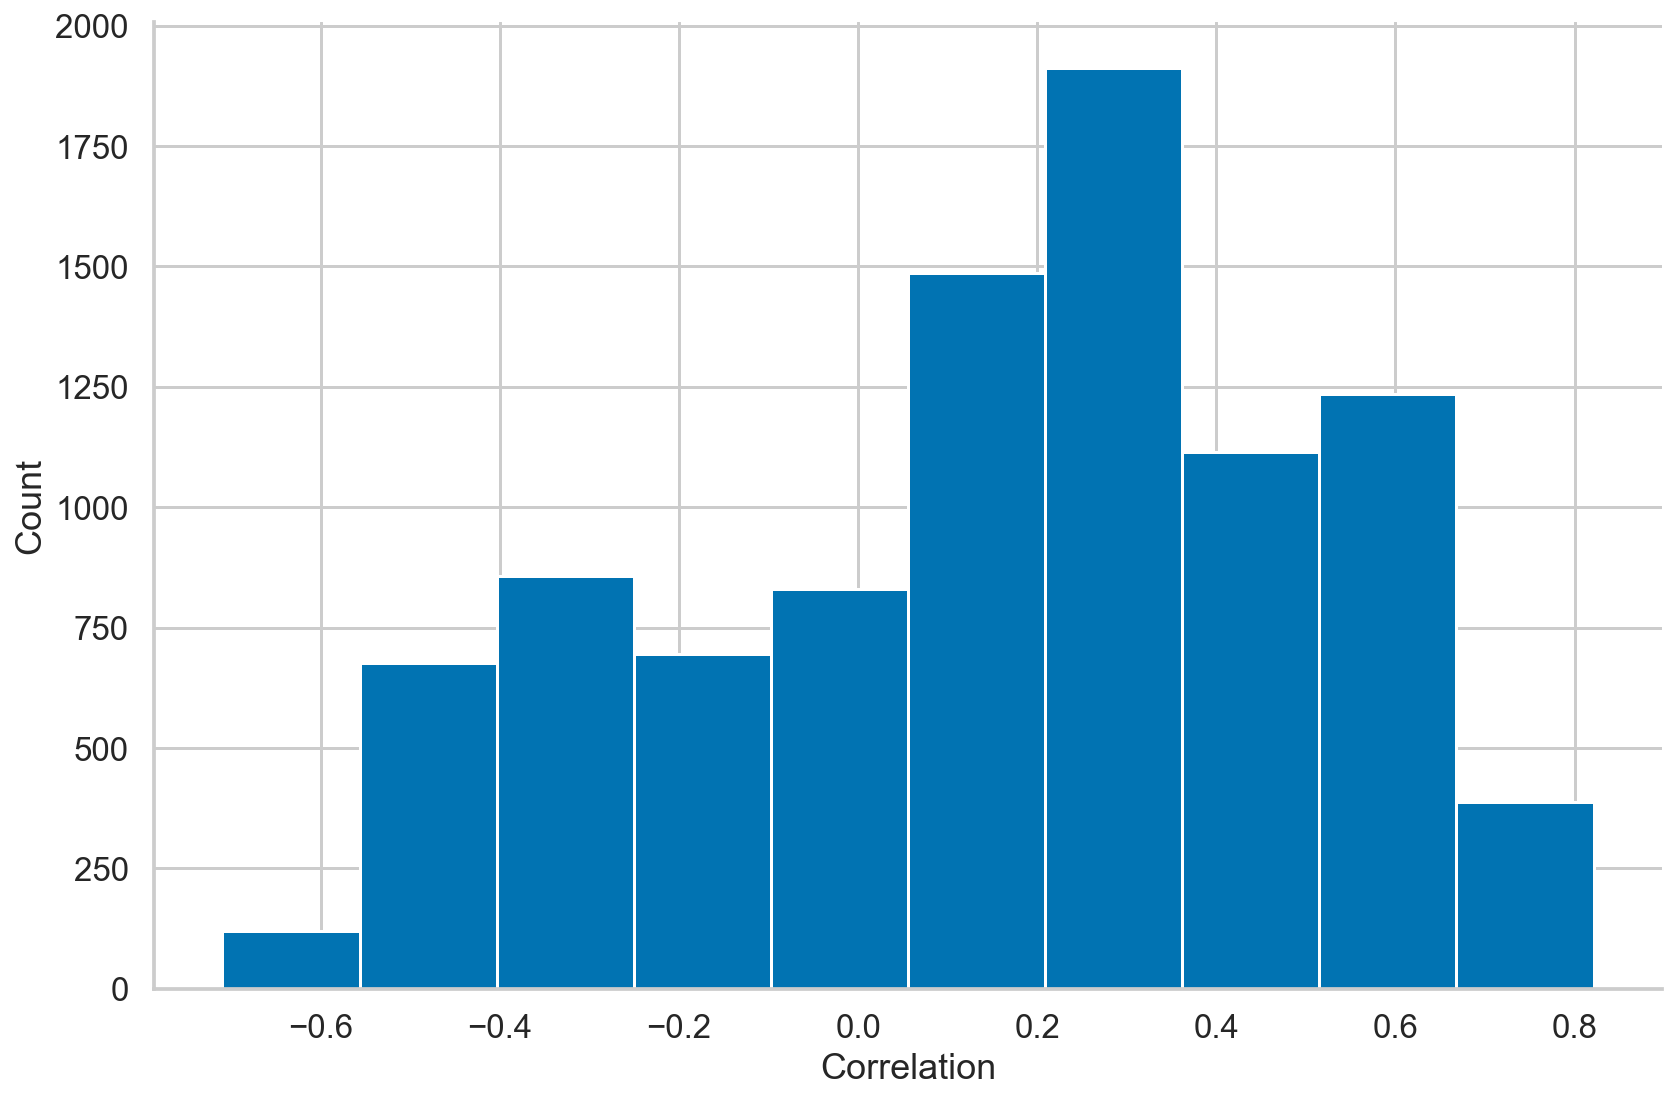

In [26]:
# distribution of off-diagonal correlations
plt.hist(corr_matrix[corr_matrix < 1].numpy())

plt.xlabel("Correlation")
plt.ylabel("Count")

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_15_15")

### See also

- Salinas, D., Flunkert, V., Gasthaus, J., & Januschowski, T. (2020). "DeepAR: Probabilistic forecasting with autoregressive recurrent networks", *International Journal of Forecasting*, 36(3): 1181-1191.  
- Salinas, D., Bohlke-Schneider, M., Callot, L., Medico, R., & Gasthaus, J. (2019). "High-dimensional multivariate forecasting with low-rank Gaussian copula processes". *Advances in Neural Information Processing Systems*, 32.

## 15.4 Time series forecasting with NeuralProphet

**NeuralProphet을 사용한 시계열 예측**

**Chapter 7, Machine Learning-Based Approaches to Time Series Forecasting**에서, 우리는 Meta(구 Facebook)가 만든 Prophet 알고리즘을 다뤘습니다. 이번 레시피에서는 해당 알고리즘의 확장판인 **NeuralProphet**을 살펴봅니다.

간략히 복습하자면, Prophet의 저자들은 해당 알고리즘이 뛰어난 성능, 해석 용이성, 그리고 사용의 간편성을 주요 장점으로 가지고 있다고 강조했습니다. NeuralProphet의 저자들 또한 Prophet의 모든 장점을 유지하면서, 정확도와 확장성을 개선하기 위한 새로운 구성 요소를 추가하는 접근 방식을 취했습니다.

원래 Prophet 알고리즘에 대한 비판은, 이를 일반화 선형 모델에 기반한 엄격한 파라메트릭 구조를 가졌다는 점과 국지적 패턴에 맞추기에는 적응력이 부족한 **커브 피터(curve-fitter)** 유형의 알고리즘이라는 점이었습니다.

전통적으로, 시계열 모델은 미래 값을 예측하기 위해 시계열의 지연 값(lagged values)을 사용합니다. Prophet의 창시자들은 시계열 예측을 곡선 맞춤 문제로 재구성했으며, 알고리즘은 추세의 함수 형태를 찾으려 시도합니다.

다음은 NeuralProphet에 추가된 주요 기능을 간략히 요약한 내용입니다:

- NeuralProphet은 Prophet 명세에 **자기회귀(autoregressive) 항**을 도입합니다.
- 자기회귀는 **AutoRegressive Network (AR-Net)**를 통해 포함됩니다. AR-Net은 시계열 신호에서 자기회귀 과정을 모방하도록 훈련된 신경망입니다. 기존 AR 모델과 AR-Net의 입력은 동일하지만, AR-Net은 훨씬 더 큰 규모에서 작동할 수 있습니다.
- NeuralProphet은 Prophet 알고리즘에 사용된 **Stan** 대신 **PyTorch**를 백엔드로 사용합니다. 이를 통해 더 빠른 훈련 속도와 기타 이점을 얻을 수 있습니다.
- 지연 회귀 변수(특징)는 **피드포워드 신경망**을 통해 모델링됩니다.
- 알고리즘은 사용자 정의 손실 및 메트릭과 함께 작동할 수 있습니다.
- 이 라이브러리는 정규화를 광범위하게 사용하며, 모델의 대부분 구성 요소(추세, 계절성, 공휴일, AR 항 등)에 이를 적용할 수 있습니다. 특히 AR 항의 경우, 빠르게 증가하는 훈련 시간을 걱정하지 않고 더 많은 지연 값을 사용할 수 있습니다.

사실, NeuralProphet은 AR 항에 대해 몇 가지 구성을 지원합니다:
- **Linear AR**: 단일 계층 신경망으로, 활성화 함수 없이 특정 예측 단계로의 특정 지연 값을 회귀합니다. 간단한 구조 덕분에 해석이 매우 용이합니다.
- **Deep AR**: 이 구성에서는 AR 항이 지정된 은닉층 수와 ReLU 활성화 함수를 가진 완전 연결 신경망으로 모델링됩니다. 해석 가능성이 떨어지고 훈련 시간이 길어지며 복잡도가 증가하지만, 종종 더 높은 예측 정확도를 달성합니다.
- **Sparse AR**: 특정 시점의 더 많은 값을 포함한 AR 항과 정규화 항을 결합합니다.

언급된 모든 구성은 대상(target)과 설명 변수(covariates)에 적용할 수 있습니다.

요약하자면, NeuralProphet은 다음과 같은 구성 요소로 구성됩니다:
- **추세(Trend)**
- **계절성(Seasonality)**
- **공휴일 및 특수 이벤트(Holidays and special events)**
- **자기회귀(Autoregression)**
- **지연 회귀(Lagged regression)**: 피드포워드 신경망을 사용해 내부적으로 설명 변수의 지연 값을 모델링합니다.
- **미래 회귀(Future regression)**: 이벤트나 공휴일처럼, 미래에 알거나 주어진 값으로 알고 있는 회귀 변수를 포함합니다.

이 레시피에서는, 2010년부터 2021년까지의 S&P 500 주가 데이터를 사용해 NeuralProphet의 몇 가지 구성을 맞춤 설정합니다. 이전 레시피와 유사하게, 자산 가격 시계열을 선택한 이유는 데이터 접근성과 일일 빈도 때문입니다. 주가를 정확히 예측하는 것은 매우 어렵거나 불가능할 수 있으므로, 이번 작업은 NeuralProphet 알고리즘을 활용하는 과정을 보여주는 데 초점을 맞추고 있습니다.

### How to do it...

1. Import the libraries:

In [4]:
import yfinance as yf
import pandas as pd
from neuralprophet import NeuralProphet
from neuralprophet.utils import set_random_seed
from neuralprophet.utils import set_log_level

/home/restful3/anaconda3/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


2. Download the historical prices of the S&P 500 index and prepare the DataFrame for modeling with NeuralProphet:

라이브러리를 가져온 후, 우리는 2010년부터 2021년까지의 S&P 500 지수의 일별 주가를 다운로드합니다. 조정 종가만 유지하고, Prophet 및 NeuralProphet에서 인식할 수 있는 포맷으로 DataFrame을 변환합니다. 여기서 시간 열은 `ds`로, 타겟 시계열은 `y`로 명명합니다.

In [5]:
df = yf.download("^GSPC",
                 start="2010-01-01",
                 end="2021-12-31")
df = df[["Adj Close"]].reset_index(drop=False)
df.columns = ["ds", "y"]

[*********************100%***********************]  1 of 1 completed


3. Create the train/test split:

**Step 3**에서는 테스트 세트의 크기를 60으로 설정하고, DataFrame을 학습 세트와 테스트 세트로 분할합니다.

> NeuralProphet은 훈련 중 검증 세트를 사용하는 것도 지원합니다. 이를 **fit** 메서드를 호출할 때 추가할 수 있습니다.

In [6]:
TEST_LENGTH = 60
df_train = df.iloc[:-TEST_LENGTH]
df_test = df.iloc[-TEST_LENGTH:]

4. Train the default Prophet model and plot the evaluation metrics:

**Step 4**에서는 기본값에 가까운 NeuralProphet 모델을 초기화합니다. 우리가 조정한 유일한 하이퍼파라미터는 `changepoints_range`입니다. 기본값인 0.9에서 0.95로 값을 증가시킵니다. 이는 모델이 데이터의 첫 95%에서 변경점을 식별할 수 있게 합니다. 나머지 5%는 조정되지 않은 상태로 남습니다.

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/restful3/anaconda3/envs/nlp/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

WARNING - (py.warnings._showwarnmsg) - /home/restful3/anaconda3/envs/nlp/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

Finding best initial lr: 100%|██████████| 237/237 [00:01<00:00, 169.68it/s]


Training: |          | 0/? [00:18<?, ?it/s, v_num=7, train_loss=0.00164, reg_loss=0.000, MAE=63.90, RMSE=94.40, Loss=0.00163, RegLoss=0.000]


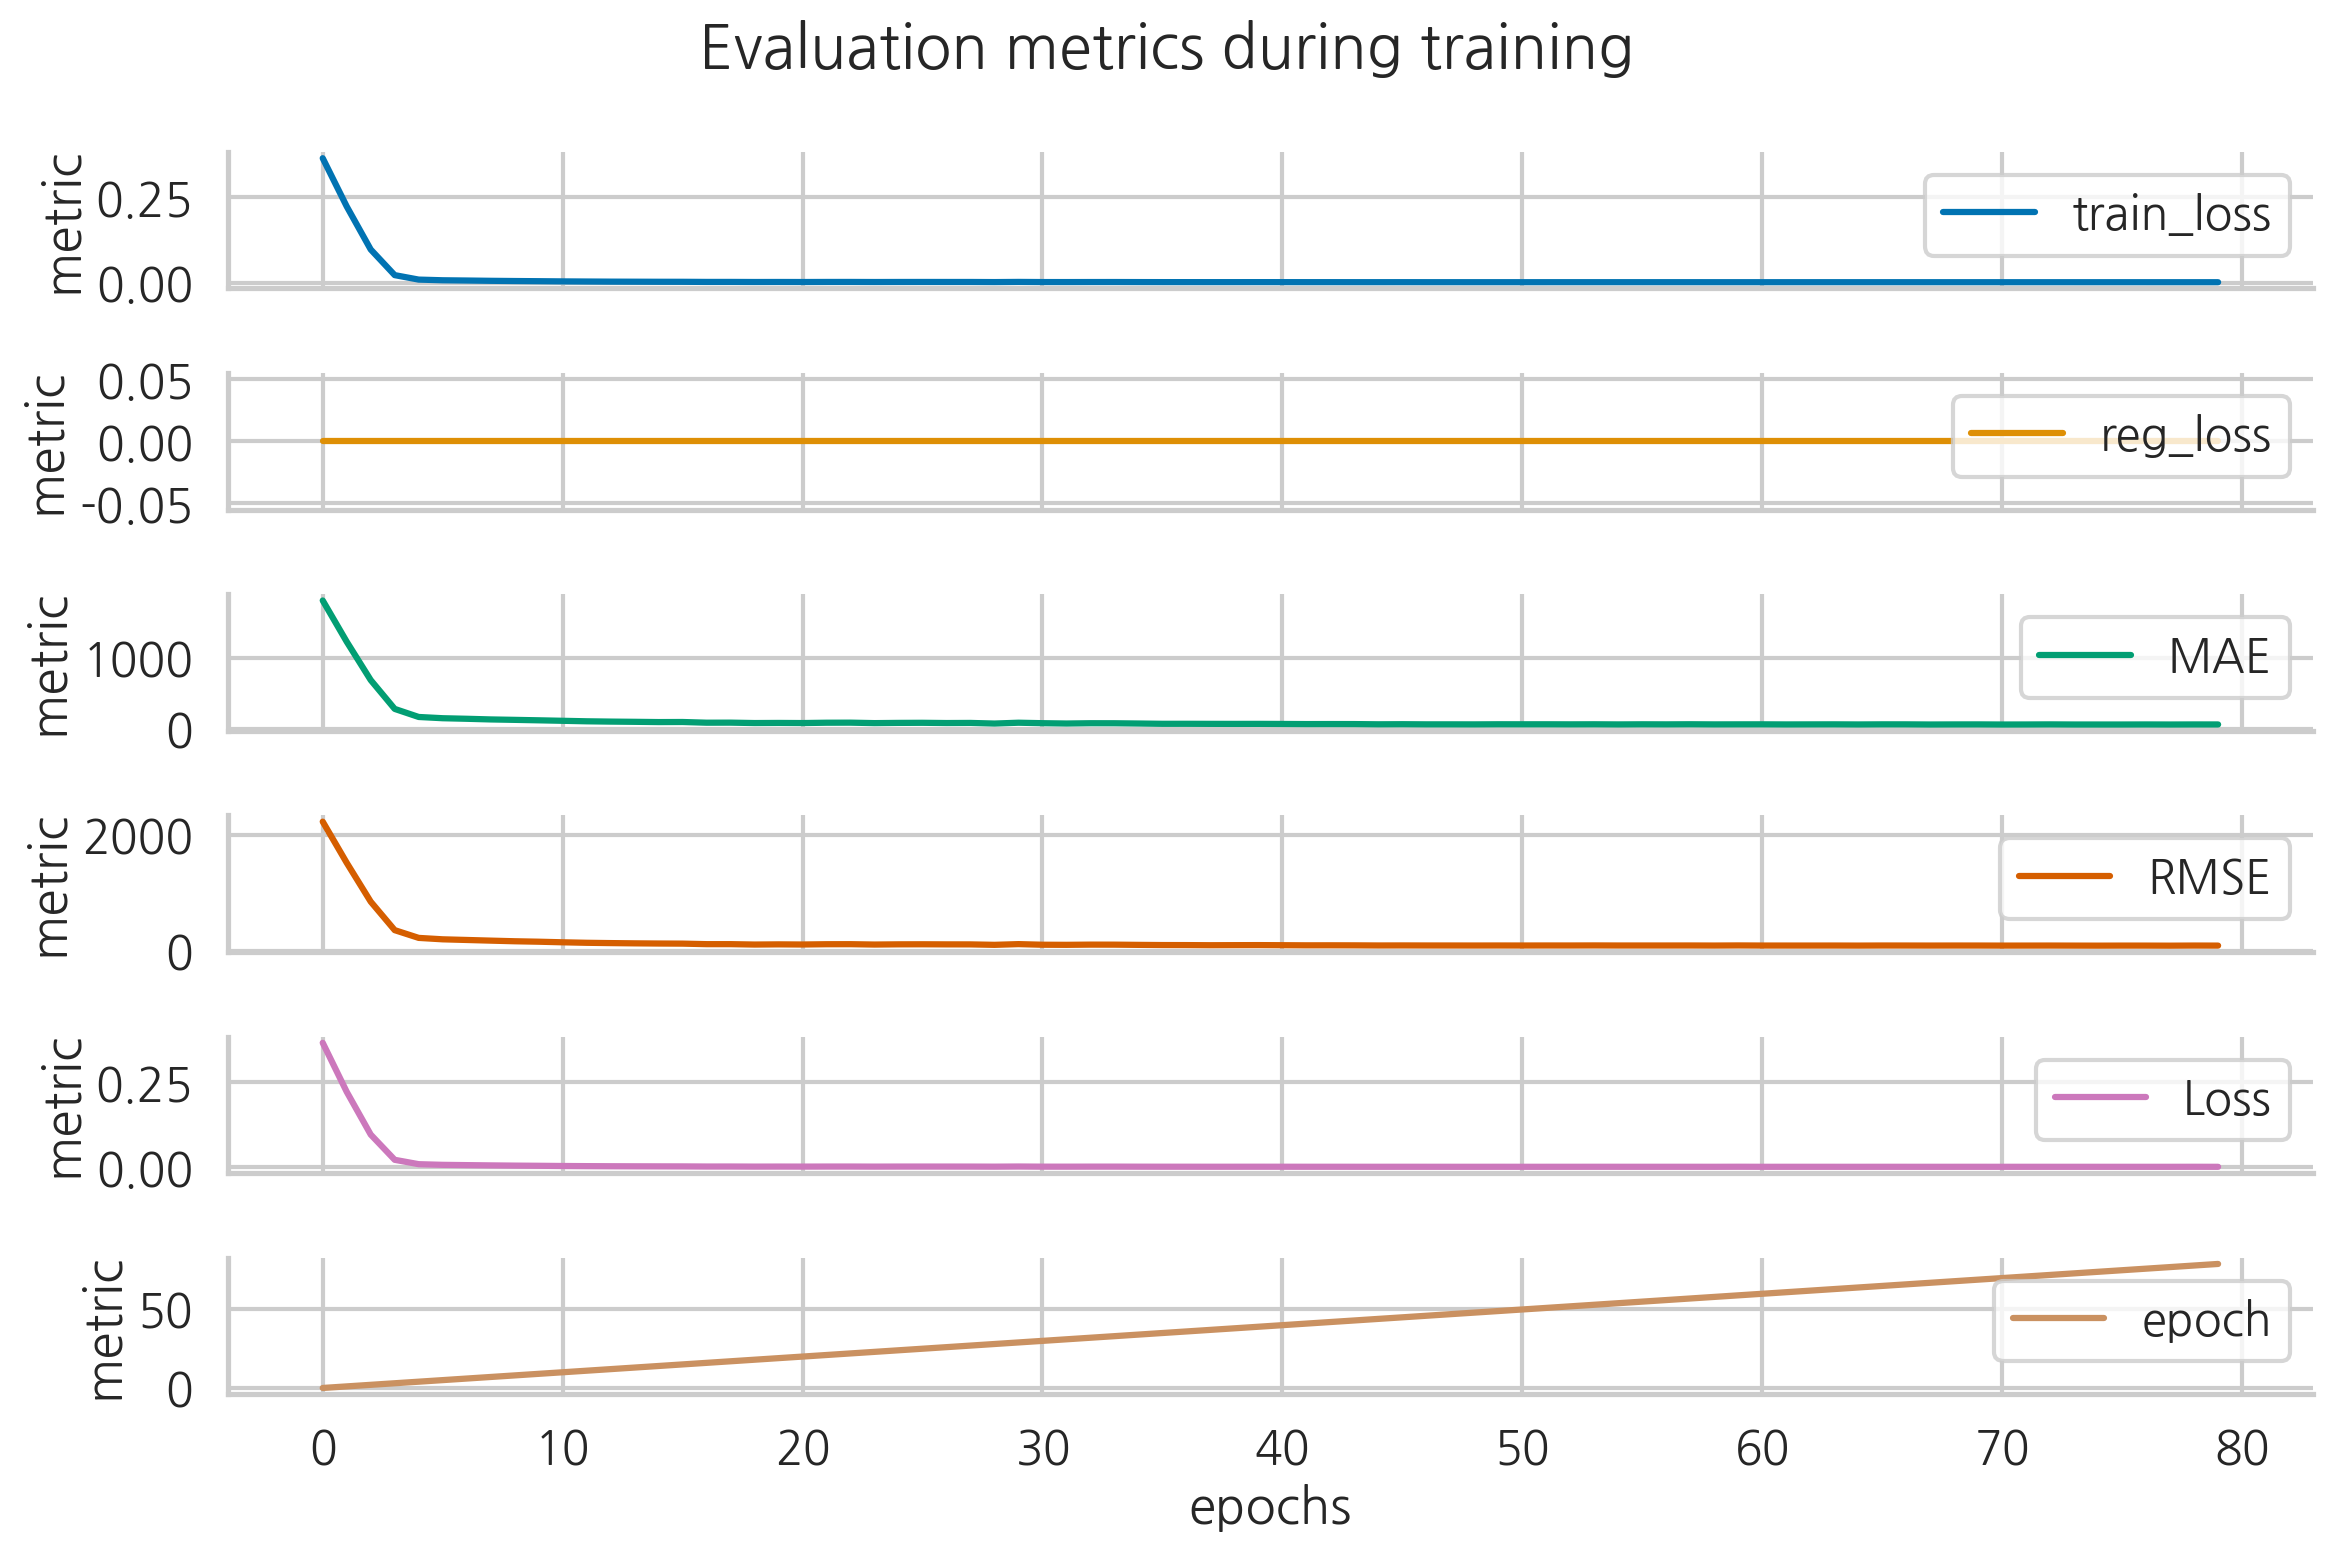

In [7]:
from matplotlib.pyplot import xlabel


set_random_seed(42)
set_log_level(log_level="ERROR")
model = NeuralProphet(changepoints_range=0.95)
metrics = model.fit(df_train, freq="B")

(
    metrics
    .drop(columns=["RegLoss"])
    .plot(title="Evaluation metrics during training", 
          subplots=True,
          xlabel="epochs",
          ylabel="metric")
)

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_15_16")

5. Calculate the predictions and plot the fit:

**Step 5**에서는 **predict** 메서드를 사용해 전체 시계열을 입력으로 하여 예측값을 계산합니다. 이렇게 하면, 학습 데이터에 대한 적합값(샘플 내 적합값)과 테스트 세트에 대한 샘플 외 예측값을 얻습니다. 이 시점에서, Prophet 라이브러리에서 친숙한 **make_future_dataframe** 메서드를 사용할 수도 있습니다.

Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 364.44it/s]


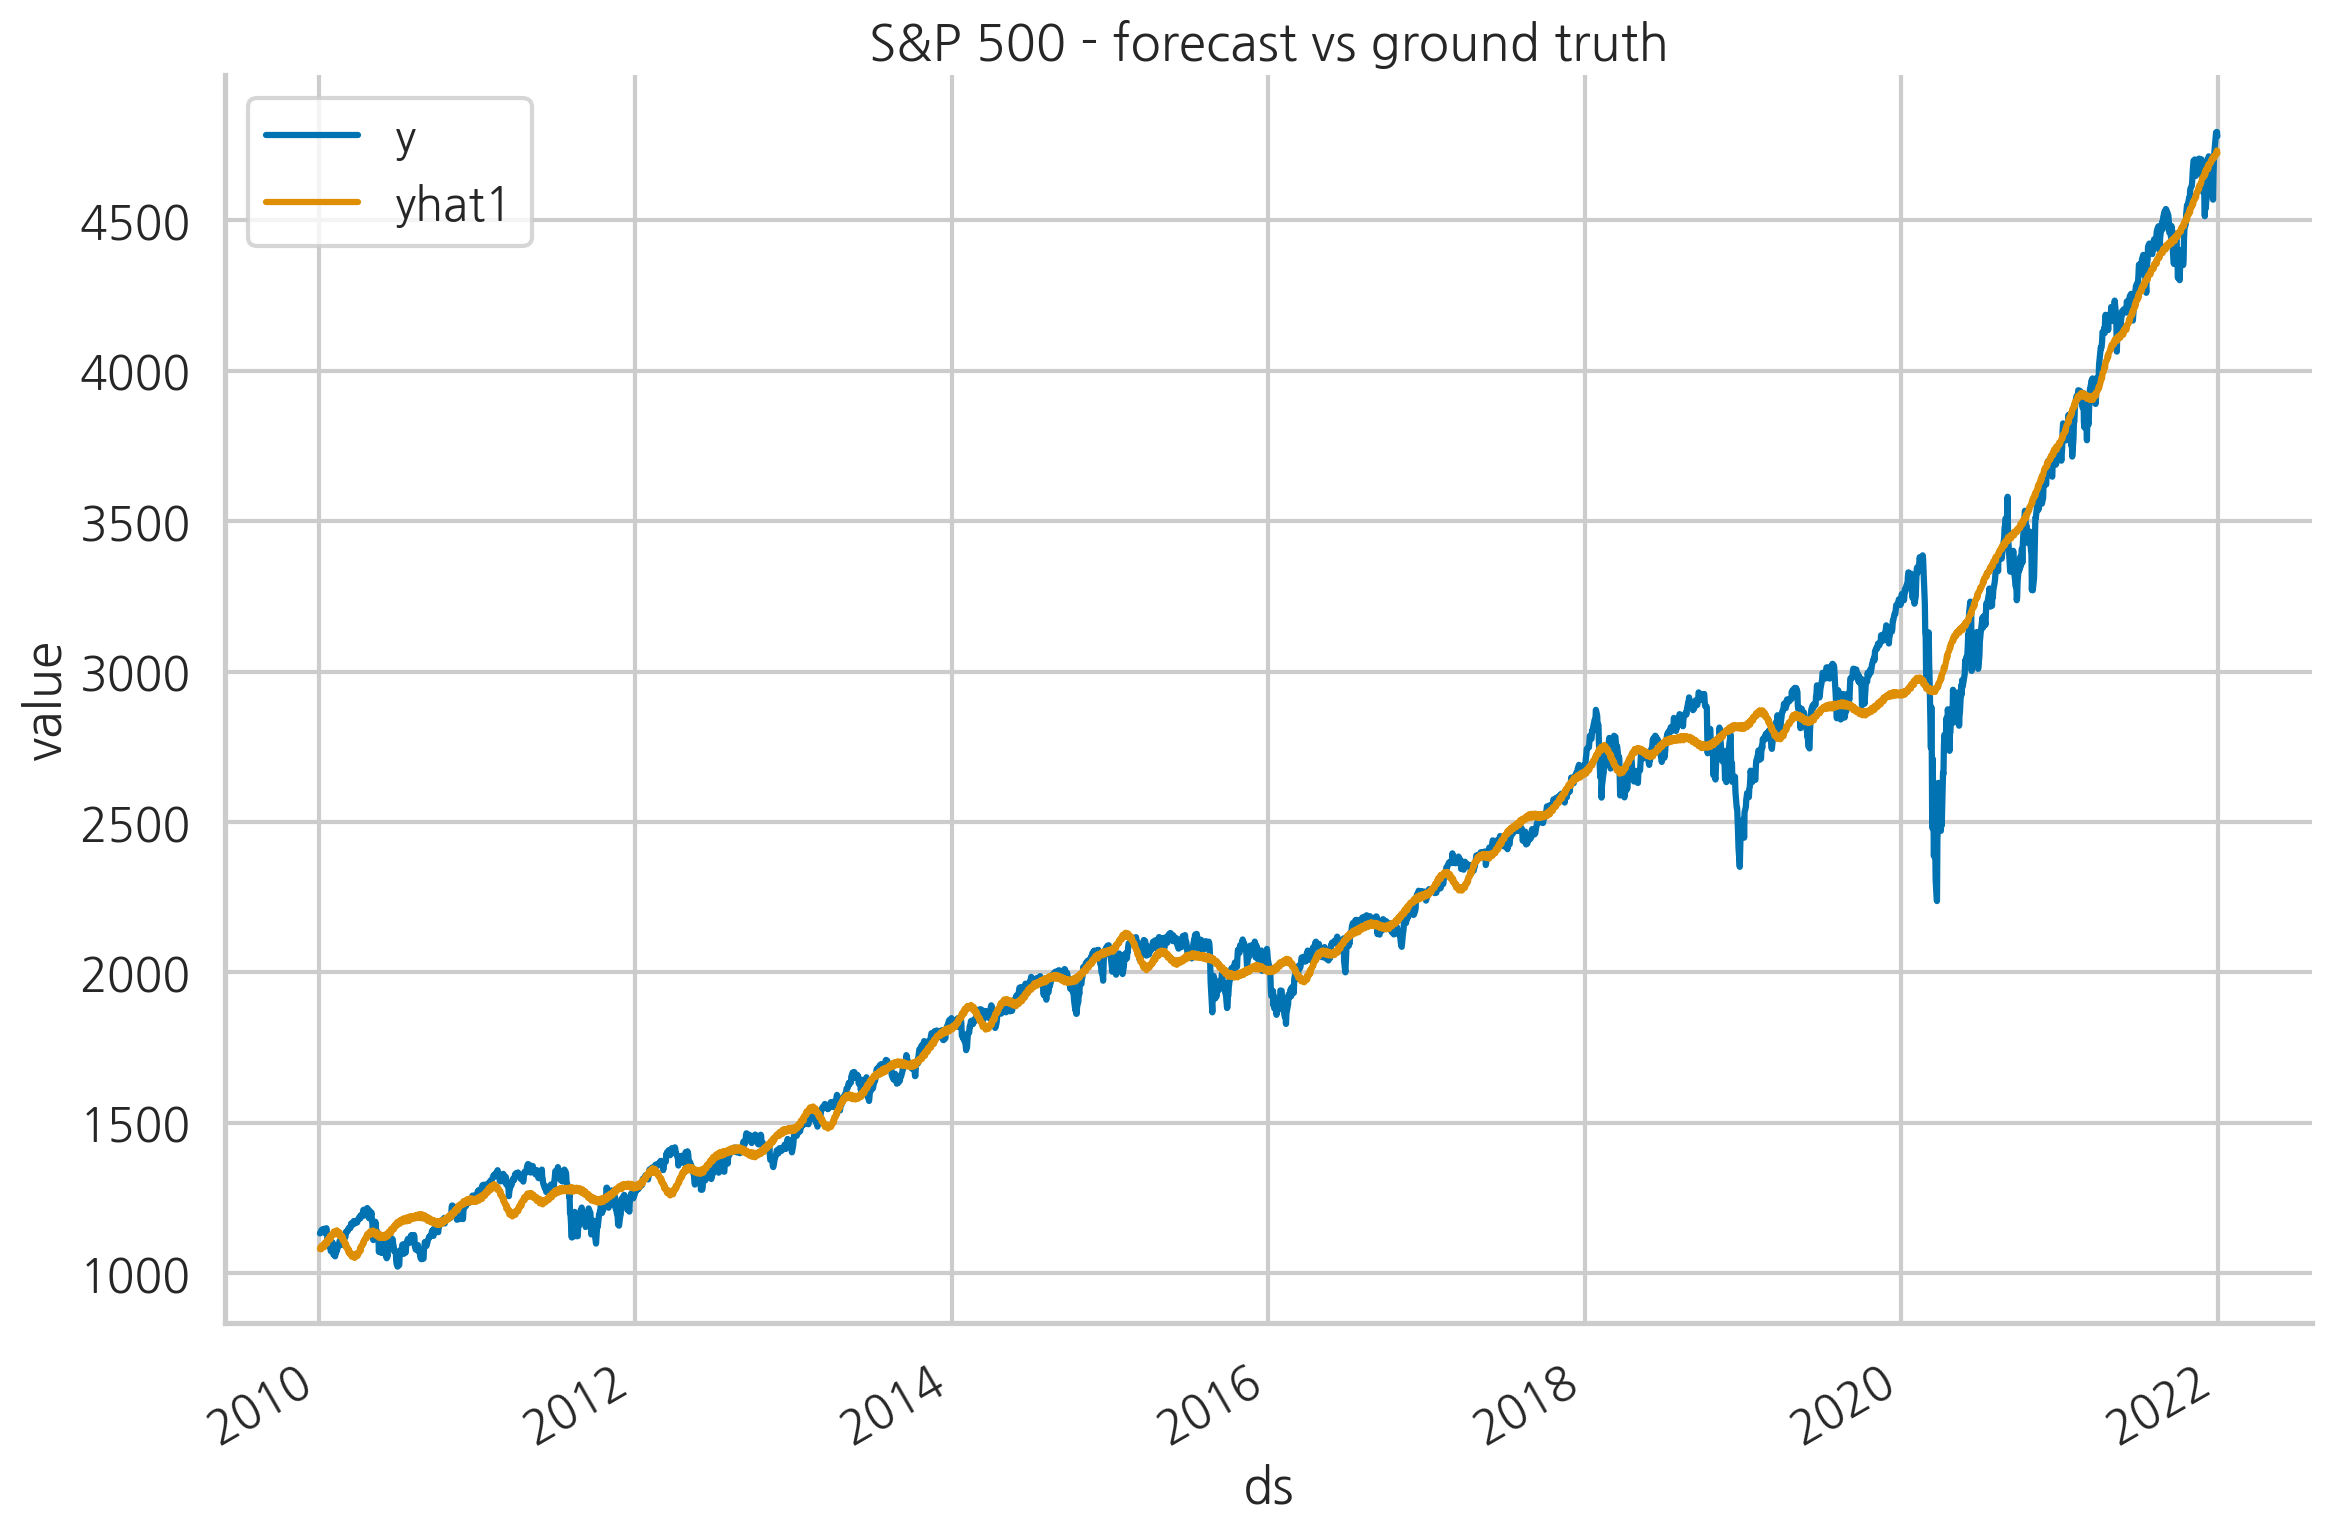

In [8]:
pred_df = model.predict(df)

pred_df.plot(x="ds", y=["y", "yhat1"], 
             title="S&P 500 - forecast vs ground truth",
             ylabel="value");

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_15_17")

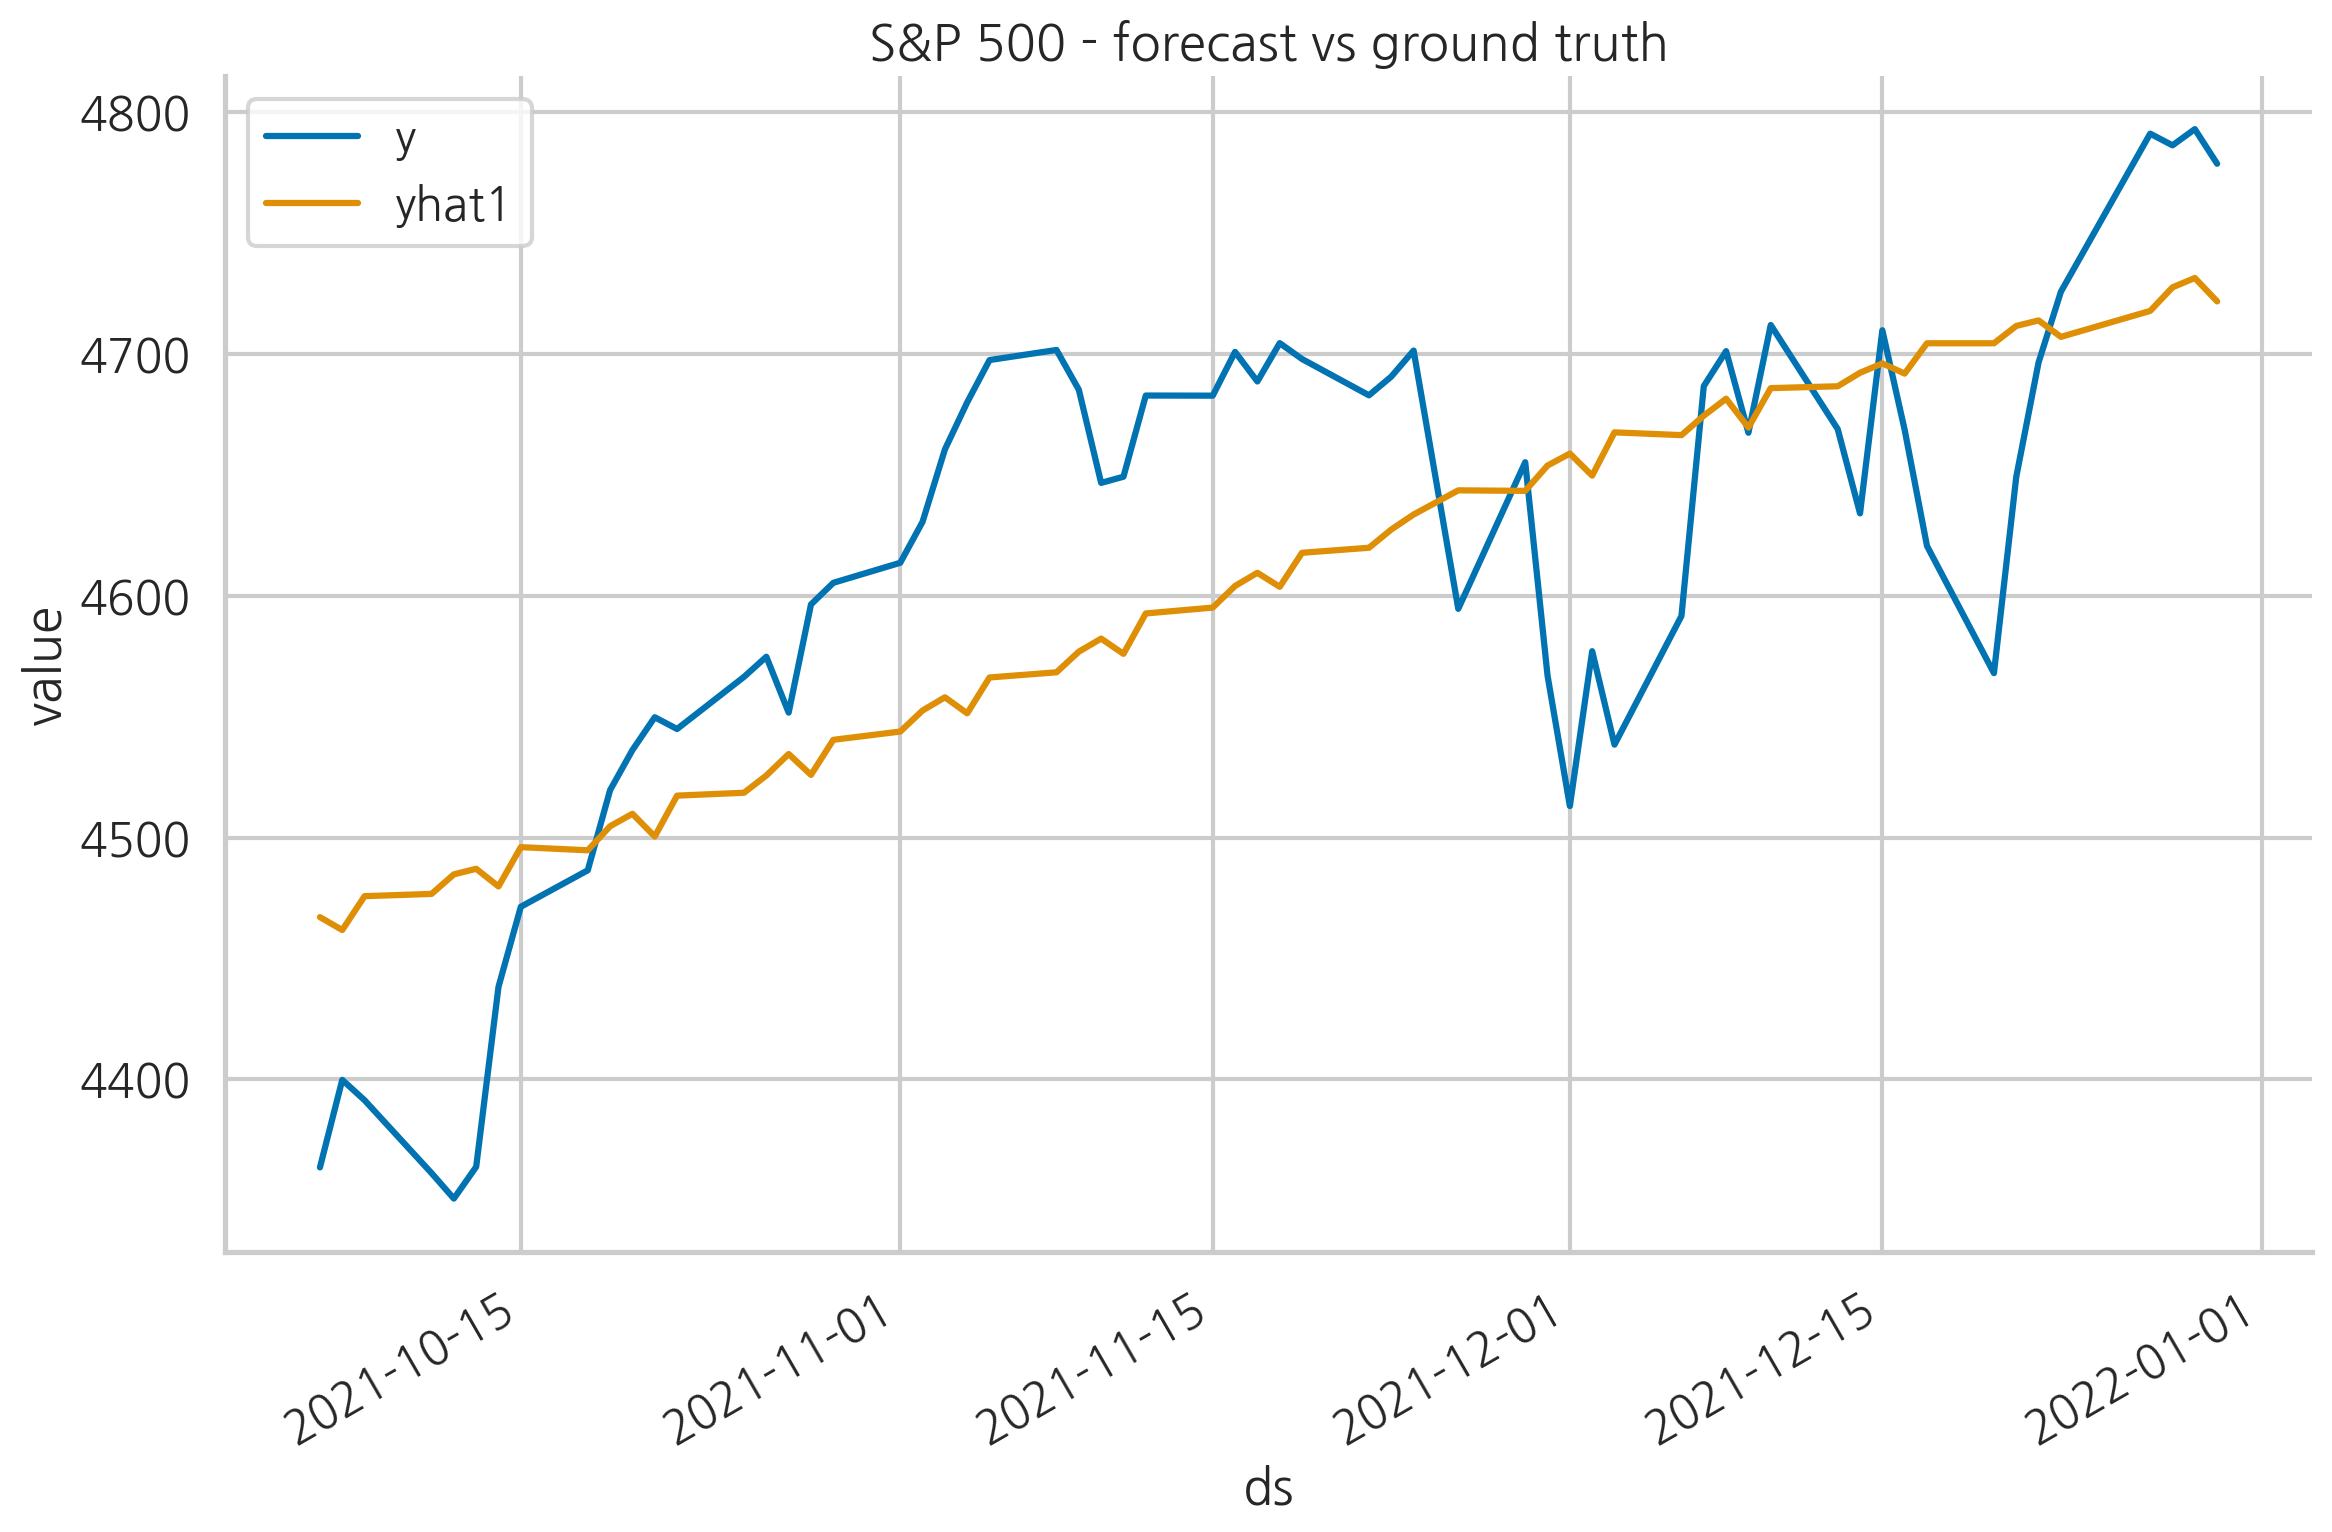

In [9]:
(
    pred_df
    .iloc[-TEST_LENGTH:]
    .plot(x="ds", y=["y", "yhat1"], 
          title="S&P 500 - forecast vs ground truth",
          ylabel="value")
);

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_15_18")

In [10]:
model.test(df_test)

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.90it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │   0.0011784556554630399   │
│          MAE_val          │     66.6054916381836      │
│         RMSE_val          │     76.86257934570312     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

MAE_val   RMSE_val  Loss_test  RegLoss_test
0  66.605492  76.862579   0.001178           0.0

6. Add the AR components to NeuralProphet:

**Step 6**에서는 선형 AR 항을 추가합니다. **n_lags** 인수를 사용하여 고려할 지연 값의 수를 지정합니다. 추가적으로, AR 항의 정규화를 설정하기 위해 **ar_reg**를 1로 설정합니다. 값을 제공하지 않으면, 라이브러리는 학습률 범위 테스트를 사용해 최적값을 찾습니다.

> AR 항의 정규화 값을 설정할 때(라이브러리 내 모든 정규화에 적용), 0은 정규화를 사용하지 않음을 의미합니다. 작은 값(예: 0.001~1)은 약한 정규화를 의미하며, 큰 값(예: 1~100)은 0이 아닌 계수의 수를 크게 제한합니다.

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/restful3/anaconda3/envs/nlp/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 49. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

Finding best initial lr: 100%|██████████| 237/237 [00:01<00:00, 166.05it/s]


Training: |          | 0/? [00:18<?, ?it/s, v_num=8, train_loss=0.00117, reg_loss=0.000914, MAE=24.30, RMSE=37.10, Loss=0.00117, RegLoss=0.000914] 
Epoch 80: 100%|██████████| 80/80 [00:29<00:00,  2.71it/s]   


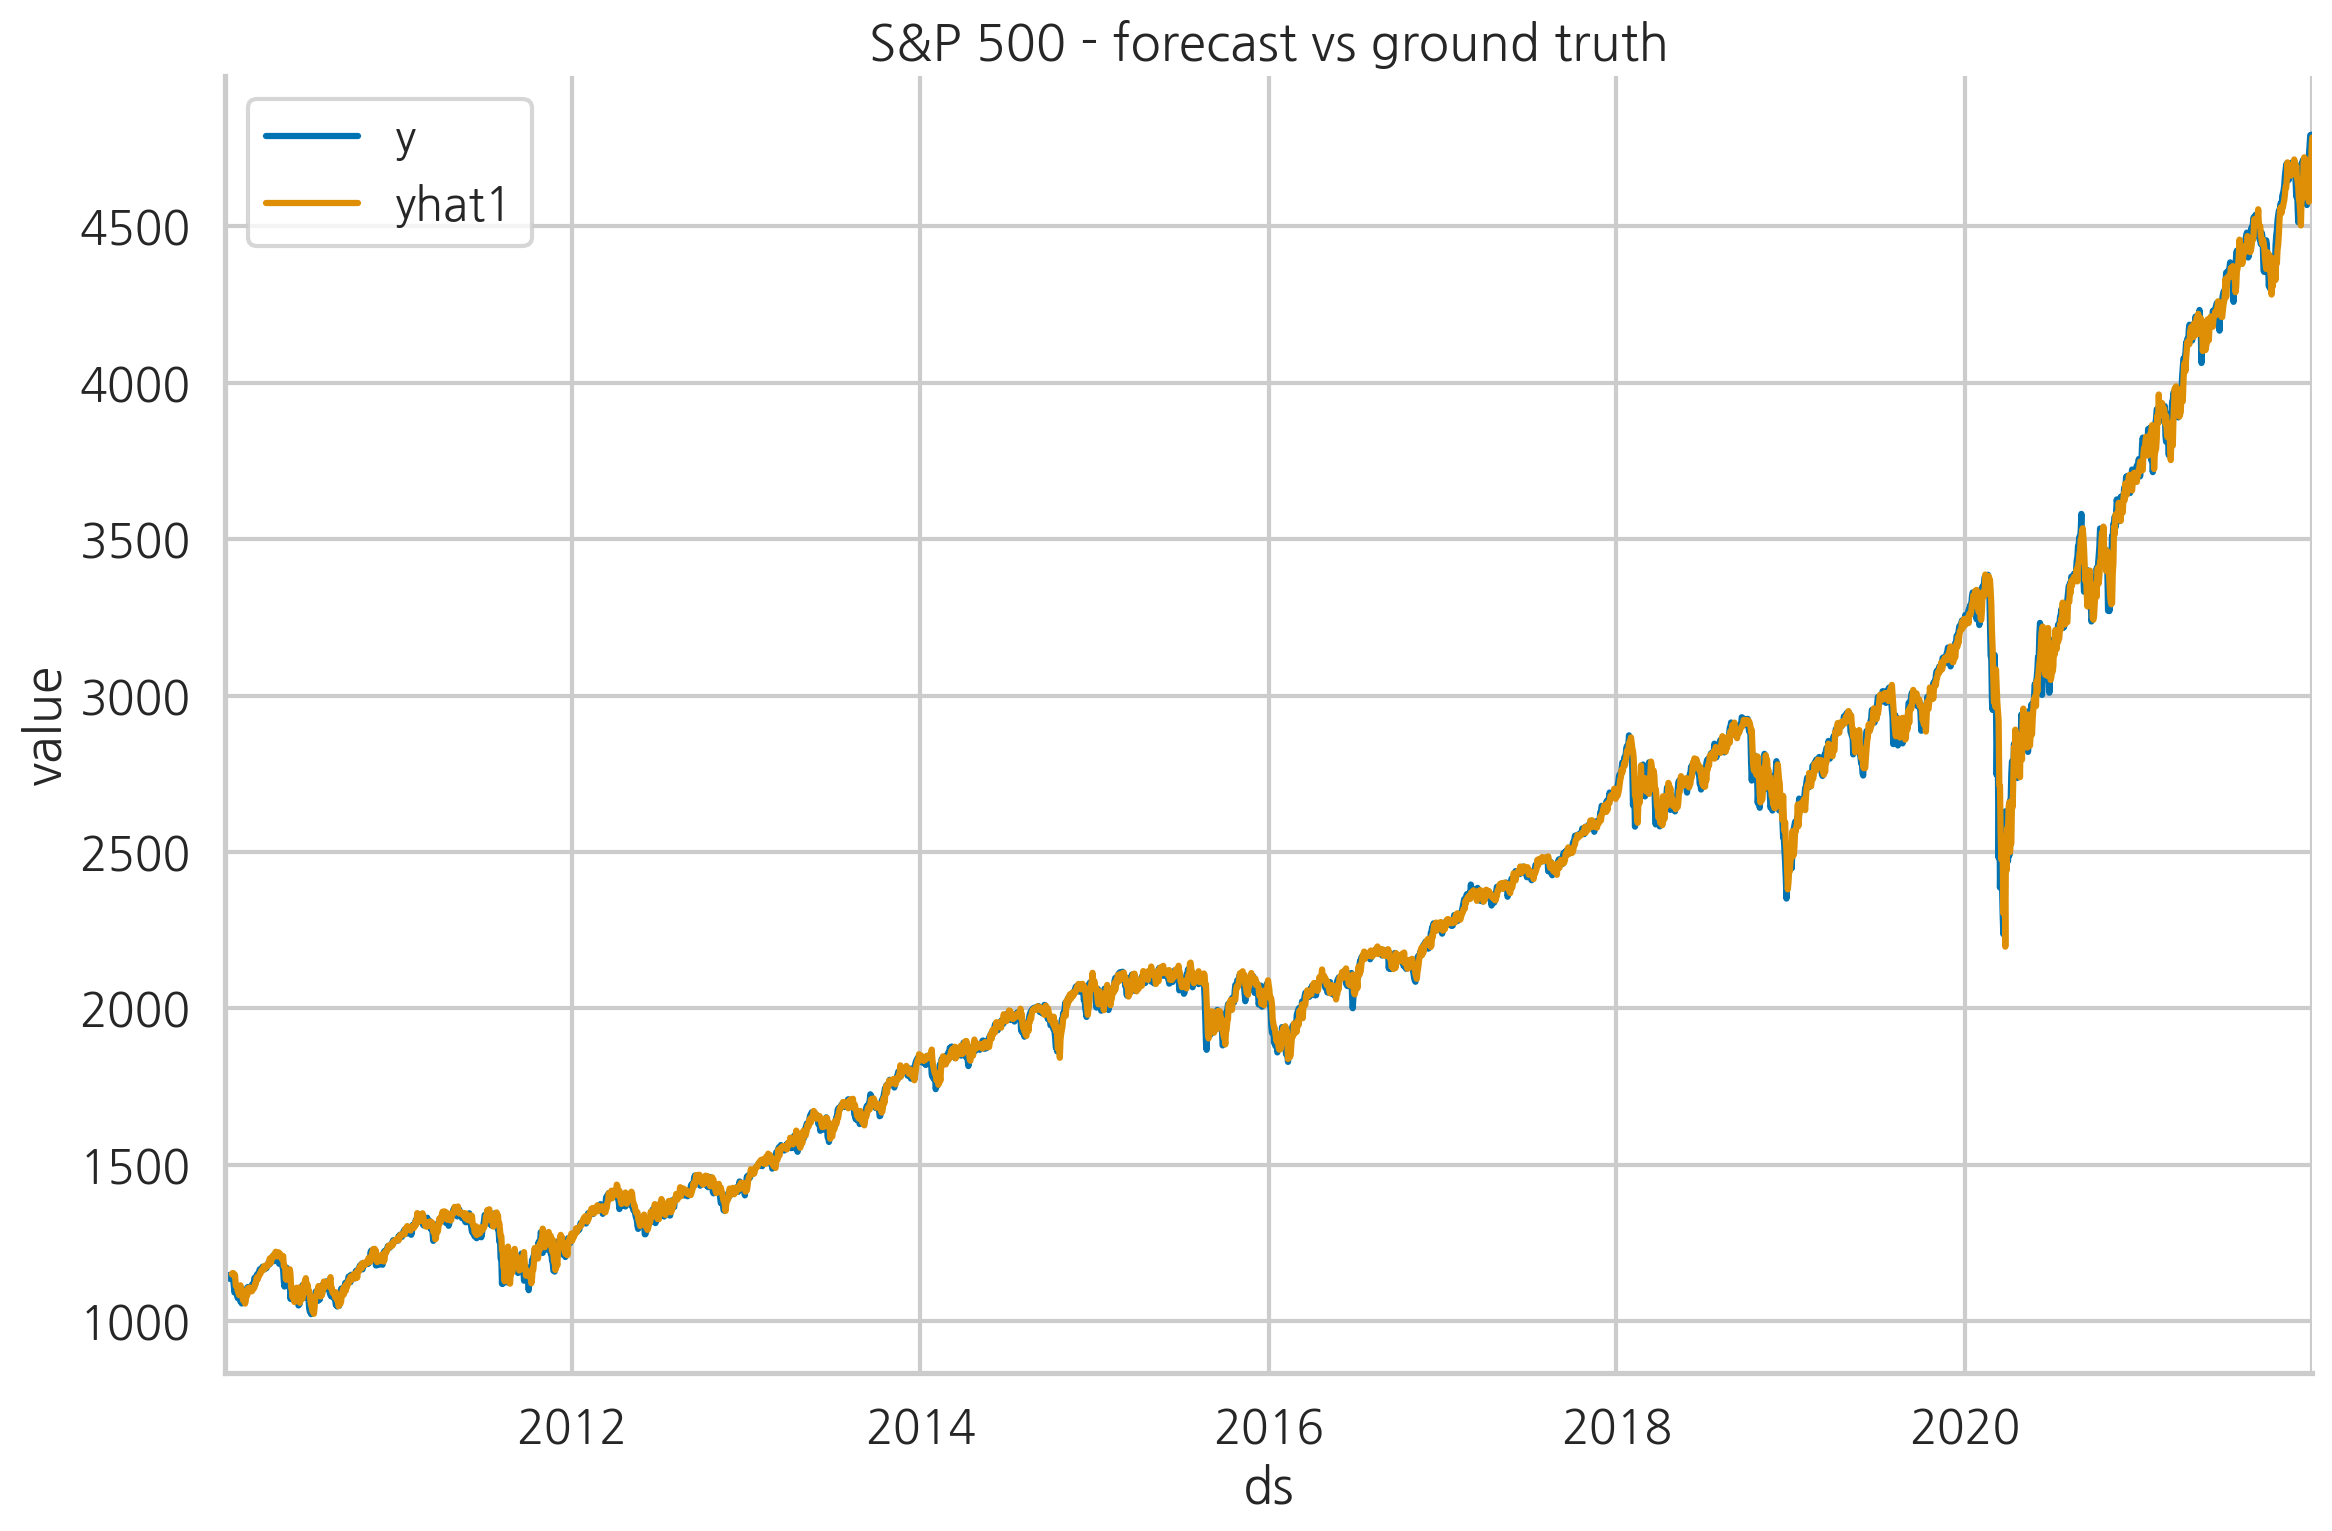

In [11]:
set_random_seed(42)
set_log_level(log_level="ERROR")
model = NeuralProphet(
    changepoints_range=0.95,
    n_lags=10,
    ar_reg=1,
)
metrics = model.fit(df_train, freq="B")

pred_df = model.predict(df)
pred_df.plot(x="ds", y=["y", "yhat1"], 
             title="S&P 500 - forecast vs ground truth",
             ylabel="value");

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_15_19")

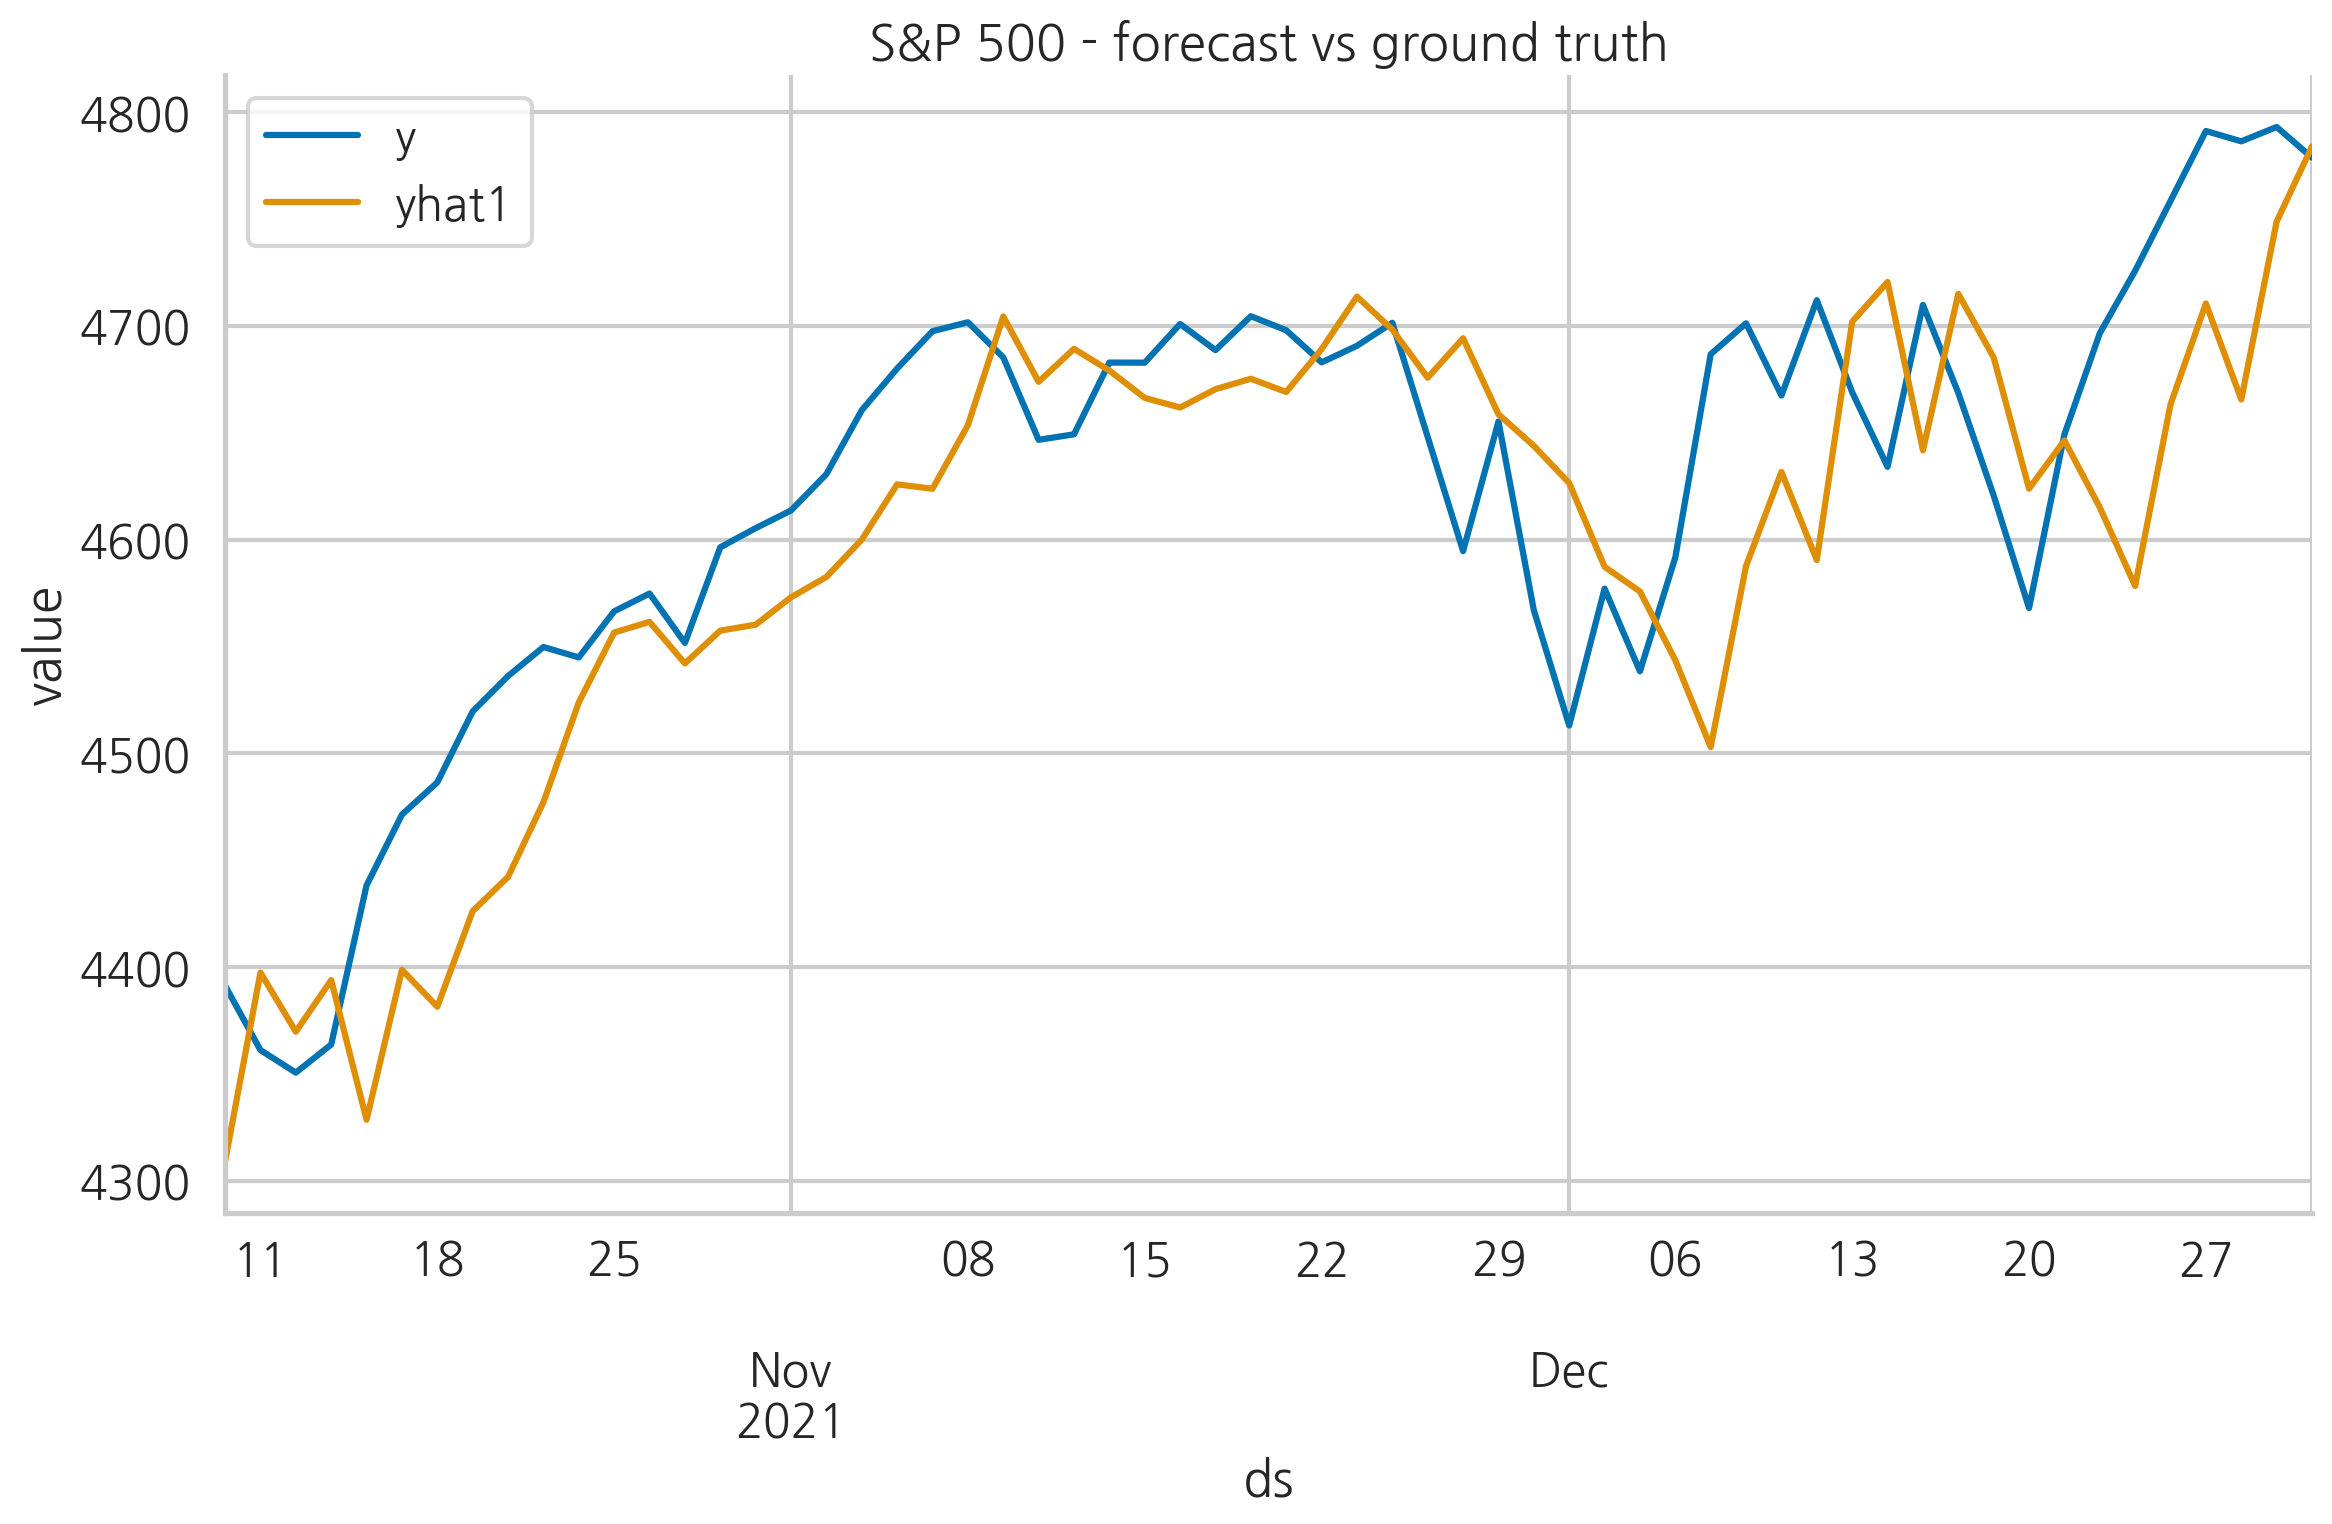

In [12]:
(
    pred_df
    .iloc[-TEST_LENGTH:]
    .plot(x="ds", y=["y", "yhat1"], 
          title="S&P 500 - forecast vs ground truth",
          ylabel="value")
);

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_15_20")

7. Add the AR-Net to NeuralProphet:

**Step 7**에서는 AR 항의 사용을 선형 AR에서 AR-Net으로 확장합니다. **Step 6**에서 사용한 다른 하이퍼파라미터는 그대로 유지하되, 몇 개의 은닉층을 사용할지(예: **num_hidden_layers**)와 그 크기(예: **d_hidden**)를 지정합니다.

In [19]:
# set_random_seed(42)
# set_log_level(log_level="ERROR")
# model = NeuralProphet(
#     changepoints_range=0.95,
#     n_lags=10,
#     ar_reg=1,
#     num_hidden_layers=3,
#     d_hidden=32,
# )
# metrics = model.fit(df_train, freq="B")

# pred_df = model.predict(df)

# (
#     pred_df
#     .iloc[-TEST_LENGTH:]
#     .plot(x="ds", y=["y", "yhat1"], 
#           title="S&P 500 - forecast vs ground truth",
#           ylabel="value")
# );

# plt.tight_layout()
# sns.despine()
# # plt.savefig("images/figure_15_21")

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 237/237 [00:01<00:00, 204.28it/s]


Training: |          | 0/? [00:18<?, ?it/s, v_num=9, train_loss=0.00117, reg_loss=0.000914, MAE=24.30, RMSE=37.10, Loss=0.00117, RegLoss=0.000914] 
Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 401.58it/s]


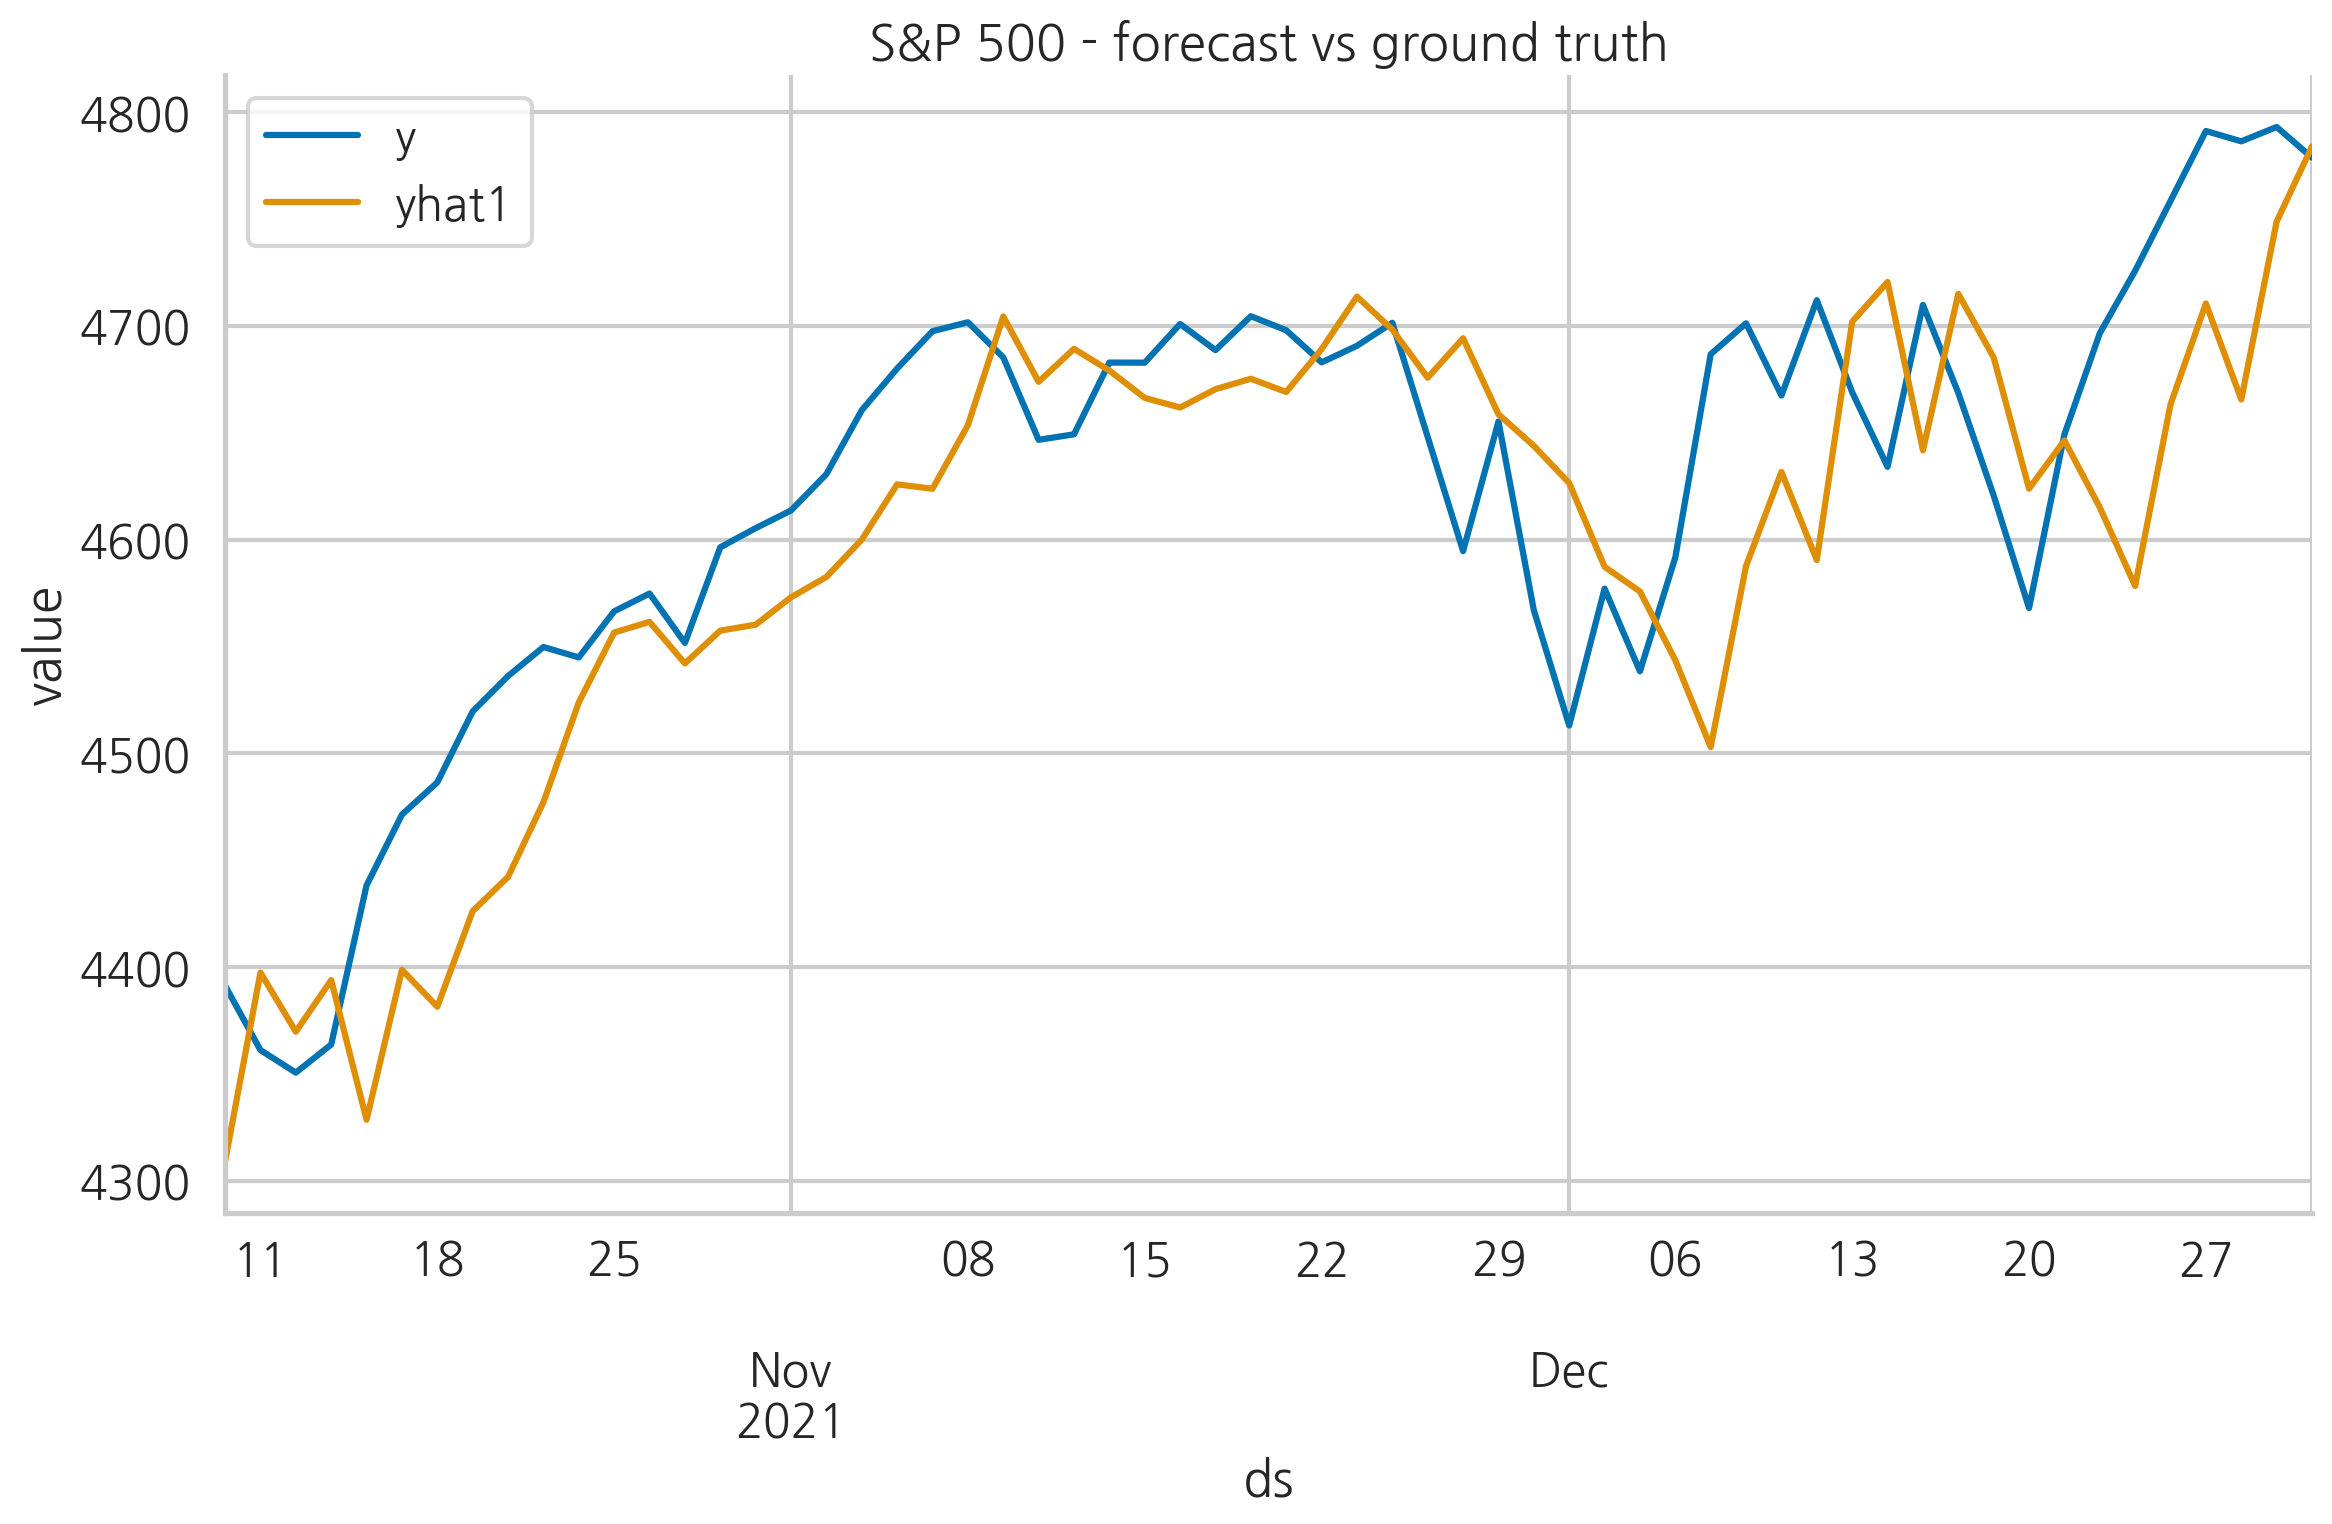

In [18]:
set_random_seed(42)
set_log_level(log_level="ERROR")
model = NeuralProphet(
    changepoints_range=0.95,
    n_lags=10,
    ar_reg=1
)
metrics = model.fit(df_train, freq="B")

pred_df = model.predict(df)

(
    pred_df
    .iloc[-TEST_LENGTH:]
    .plot(x="ds", y=["y", "yhat1"], 
          title="S&P 500 - forecast vs ground truth",
          ylabel="value")
);

plt.tight_layout()
sns.despine()

In [20]:
model.test(df_test)

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.54it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │   0.0017696134746074677   │
│          MAE_val          │    51.688148498535156     │
│         RMSE_val          │     65.49998474121094     │
│       RegLoss_test        │   0.000913470343220979    │
└───────────────────────────┴───────────────────────────┘

MAE_val   RMSE_val  Loss_test  RegLoss_test
0  51.688148  65.499985    0.00177      0.000913

8. Plot the components and parameters of the model:

마지막 단계에서는 **plot_components** 메서드를 사용해 NeuralProphet의 구성 요소를 시각화하고, **plot_parameters** 메서드를 사용해 모델의 파라미터를 시각화합니다.

In [66]:
# for plotting only, as there is some issue with the AR plot
# after plotting the components we can revert to the settings at the top of the Notebook
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [67]:
model.plot_components(model.predict(df_train));

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_15_22")

Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 206.19it/s]

ERROR - (NP.plotly.plot_components) - plotly-resampler is not installed. Please install it to use the resampler.


In [23]:
model.plot_parameters();

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_15_23")

ERROR - (NP.plotly.plot_parameters) - plotly-resampler is not installed. Please install it to use the resampler.


### There's more

1. Add holidays to the model:

In [37]:
# set_random_seed(42)
# set_log_level(log_level="ERROR")
# model = NeuralProphet(
#     changepoints_range=0.95,
#     n_lags=10,
#     ar_reg=1,
#     num_hidden_layers=3,
#     d_hidden=32,
# )

# model = model.add_country_holidays(
#     "US", lower_window=-1, upper_window=1
# )
# metrics = model.fit(df_train, freq="B")

In [34]:
pred_df = model.predict(df_train)
model.plot_components(pred_df)

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_15_24")

Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 193.33it/s]

ERROR - (NP.plotly.plot_components) - plotly-resampler is not installed. Please install it to use the resampler.


In [28]:
model.plot_parameters();

ERROR - (NP.plotly.plot_parameters) - plotly-resampler is not installed. Please install it to use the resampler.


2. Create a 10-day ahead multi-step forecast:

In [13]:
set_random_seed(42)
set_log_level(log_level="ERROR")
model = NeuralProphet(
    n_lags=10,
    n_forecasts=10,
    ar_reg=1,
    learning_rate=0.01
)
metrics = model.fit(df_train, freq="B")
pred_df = model.predict(df)
pred_df.tail()

ds            y        yhat1   residual1        yhat2  \
3126 2021-12-24  4758.489990  4650.537109 -107.952881  4658.835938   
3127 2021-12-27  4791.189941  4678.010742 -113.179199  4684.404785   
3128 2021-12-28  4786.350098  4733.727051  -52.623047  4726.821777   
3129 2021-12-29  4793.060059  4743.061035  -49.999023  4752.594238   
3130 2021-12-30  4778.729980  4739.231934  -39.498047  4743.820801   

       residual2        yhat3   residual3        yhat4   residual4  ...  \
3126  -99.654053  4628.593262 -129.896729  4628.078125 -130.411865  ...   
3127 -106.785156  4667.214355 -123.975586  4644.814941    -146.375  ...   
3128   -59.52832  4719.004395  -67.345703  4654.171875 -132.178223  ...   
3129   -40.46582  4732.162598  -60.897461  4711.364746  -81.695312  ...   
3130   -34.90918  4716.883789  -61.846191  4736.578125  -42.151855  ...   

              ar4          ar5          ar6          ar7          ar8  \
3126  3135.196533  3184.866943  3190.829102  3203.072998  3161.448975   
3127    3152.4646  3068.444092  3219.397217  3183.488525  3173.246338   
3128  3160.530518  3120.293457  3135.982178  3160.213867  3240.533203   
3129  3217.064453   3193.08374  3127.438965  3115.985596  3198.358643   
3130  3242.431152  3233.673828  3179.129639  3142.590088  3121.921387   

              ar9         ar10        trend season_yearly season_weekly  
3126  3186.029541  3196.741699   1177.05127     -3.653834    319.484009  
3127  3146.842773  3235.819336  1177.903931     -3.819474    318.265717  
3128  3186.236328  3165.561279   1178.18811     -3.757542    319.211151  
3129  3185.796875  3191.491699  1178.472412     -3.634705     319.46283  
3130  3162.443604  3235.914551  1178.756592     -3.450272    318.840424  

[5 rows x 35 columns]

In [14]:
# set_random_seed(42)
pred_df = model.predict(df, raw=True, decompose=False)
pred_df.tail().round(2)

ds        step0        step1        step2        step3  \
3116 2021-12-24  4650.540039  4684.399902  4719.000000  4711.359863   
3117 2021-12-27  4678.009766  4726.819824  4732.160156  4736.580078   
3118 2021-12-28  4733.729980  4752.589844  4716.879883  4745.649902   
3119 2021-12-29  4743.060059  4743.819824  4702.350098  4733.750000   
3120 2021-12-30  4739.229980  4752.520020  4730.939941  4760.689941   

            step4        step5        step6        step7        step8  \
3116  4727.819824  4667.189941  4714.819824  4683.540039  4706.020020   
3117  4733.509766  4689.540039  4733.549805  4748.560059  4753.779785   
3118  4740.490234  4727.629883  4744.220215  4767.180176  4777.370117   
3119  4747.859863  4734.129883  4760.209961  4742.779785  4779.910156   
3120  4776.040039  4763.520020  4772.279785  4735.459961  4766.009766   

            step9  
3116  4724.060059  
3117  4767.770020  
3118  4781.660156  
3119  4803.180176  
3120  4802.129883

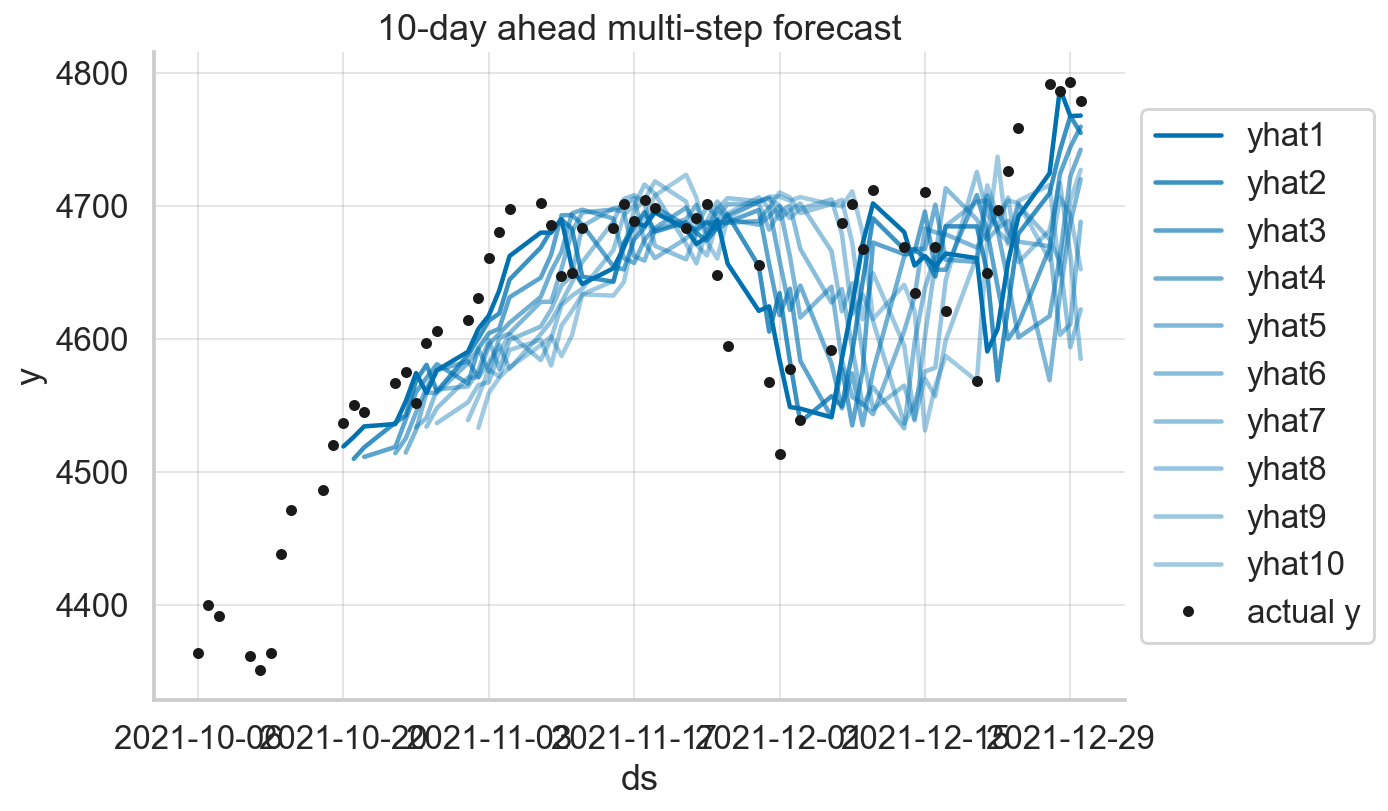

In [10]:
pred_df = model.predict(df_test)
model.plot(pred_df)
ax = plt.gca()
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("10-day ahead multi-step forecast")

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_15_27")

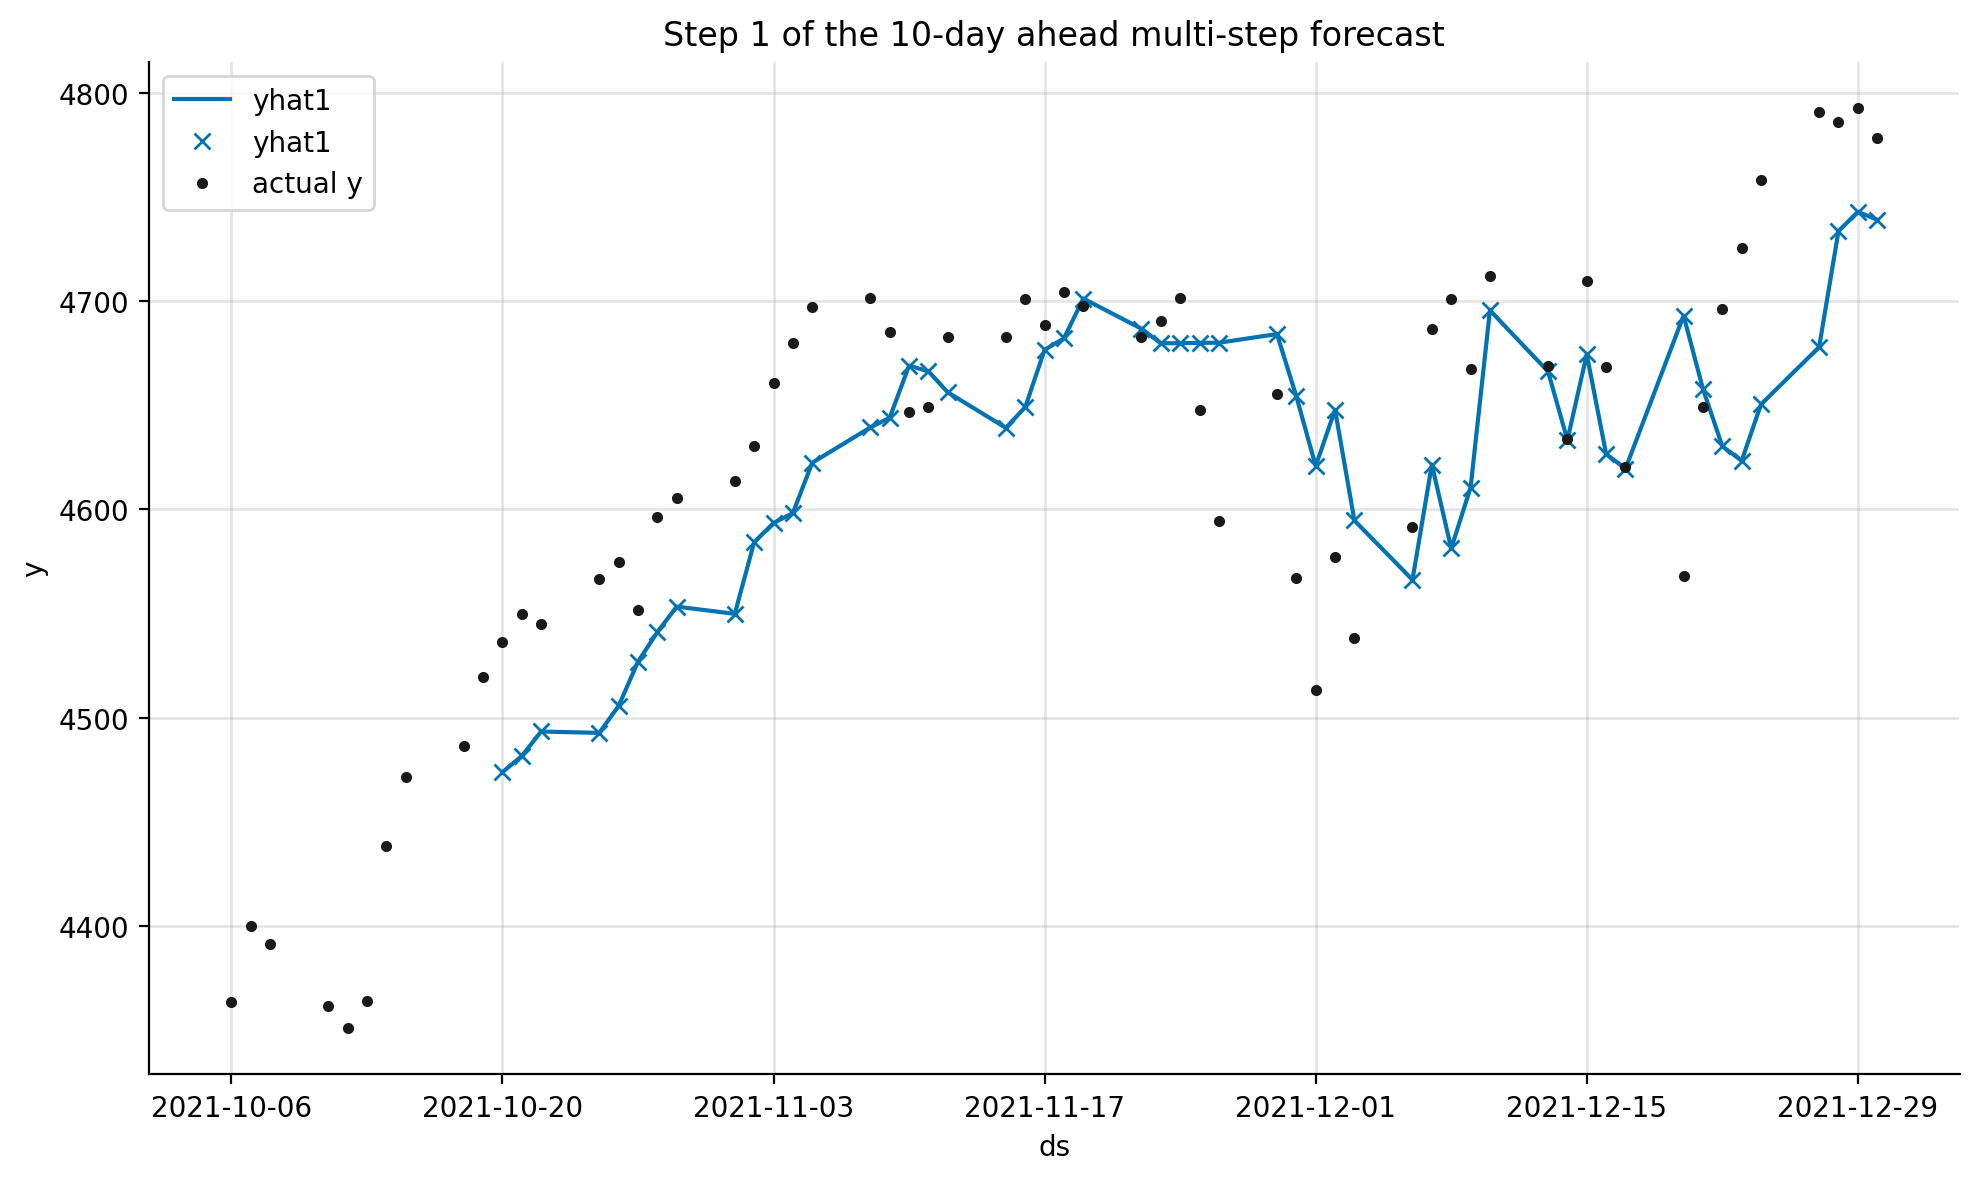

In [23]:
model = model.highlight_nth_step_ahead_of_each_forecast(1)
model.plot(pred_df)
ax = plt.gca()
ax.set_title("Step 1 of the 10-day ahead multi-step forecast")

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_15_28")

### See also

- Triebe, O., Laptev, N., & Rajagopal, R. (2019). AR-net: A simple autoregressive neural network for time-series. arXiv preprint arXiv:1911.12436.
- Triebe, O., Hewamalage, H., Pilyugina, P., Laptev, N., Bergmeir, C., & Rajagopal, R. (2021). Neuralprophet: Explainable forecasting at scale. arXiv preprint arXiv:2111.15397.


## Summary

이 장에서는 딥러닝을 사용해 테이블형 데이터와 시계열 데이터를 처리하는 방법을 탐구했습니다. 처음부터 신경망을 직접 구축하는 대신, 대부분의 복잡한 작업을 처리해 주는 현대적인 Python 라이브러리를 사용했습니다.

이미 언급했듯이, 딥러닝은 새로운 신경망 아키텍처가 매일같이 발표될 정도로 빠르게 발전하고 있는 분야입니다. 따라서 한 장에서 모든 내용을 다루기는 어렵습니다. 그렇기 때문에 이번에는 딥러닝에서 중요한 일부 인기 있는 접근 방식 및 라이브러리를 소개하며, 여러분이 직접 탐구할 수 있도록 안내합니다.


### 테이블형 데이터

다음은 테이블형 데이터를 처리하는 데 유용한 관련 논문 및 Python 라이브러리 목록입니다:

#### 추가 읽을거리:
- Huang, X., Khetan, A., Cvitkovic, M., & Karnin, Z. (2020). Tabtransformer: Tabular data modeling using contextual embeddings. arXiv preprint arXiv:2012.06678.
- Popov, S., Morozov, S., & Babenko, A. (2019). Neural oblivious decision ensembles for deep learning on tabular data. arXiv preprint arXiv:1909.06312.

#### 라이브러리:
- **pytorch_tabular**: 이 라이브러리는 테이블형 데이터를 위한 딥러닝 모델을 사용하는 프레임워크를 제공합니다. TabNet, TabTransformer, FT Transformer 및 카테고리 임베딩을 포함한 피드포워드 신경망 모델을 제공합니다.
- **pytorch-widedeep**: Google의 Wide and Deep 알고리즘에 기반한 라이브러리로, 테이블형 데이터에 딥러닝을 사용할 수 있도록 지원하며, 텍스트 및 이미지를 해당 테이블형 데이터와 결합하는 기능도 제공합니다.

### 시계열 데이터

이 장에서는 DeepAR 및 NeuralProphet을 사용한 딥러닝 기반 시계열 예측 접근 방식을 다뤘습니다. 추가적으로 시계열 데이터를 분석하고 예측하는 데 유용한 다음의 자료를 살펴보기를 권장합니다:

#### 추가 읽을거리:
- Chen, Y., Kang, Y., Chen, Y., & Wang, Z. (2020). Probabilistic forecasting with temporal convolutional neural network. Neurocomputing, 399: 491-501.
- Gallicchio, C., Micheli, A., & Pedrelli, L. (2018). Design of deep echo state networks. Neural Networks, 103: 33-47.
- Kazemi, S. M., Goel, R., Eghbal, S., Ramanan, J., Sahota, J., Thakur, S., ... & Brubaker, M. A. (2019). Time2vec: Learning a vector representation of time. arXiv preprint arXiv:1907.05321.
- Lea, C., Flynn, M. D., Vidal, R., Reiter, A., & Hager, G. D. (2017). Temporal convolutional networks for action segmentation and detection. *In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition*, 156-165.
- Lim, B., Arık, S. Ö., Loeff, N., & Pfister, T. (2021). Temporal fusion transformers for interpretable multi-horizon time series forecasting. *International Journal of Forecasting*, 37(4): 1748-1764.
- Oreshkin, B. N., Carpov, D., Chapados, N., & Bengio, Y. (2019). N-BEATS: Neural basis expansion analysis for interpretable time series forecasting. arXiv preprint arXiv:1905.10437.

#### 라이브러리:
- **tsai**: PyTorch와 fastai 위에 구축된 딥러닝 라이브러리입니다. 분류, 회귀, 예측, 결측값 보완과 같은 다양한 시계열 관련 작업에 중점을 둡니다. LSTM 및 GRU와 같은 전통적인 접근 방식 외에도 ResNet, InceptionTime, TabTransformer, Rocket과 같은 최첨단 아키텍처를 구현합니다.
- **gluonts**: 확률론적 시계열 모델링을 위한 Python 라이브러리로, DeepAR, DeepVAR, N-BEATS, Temporal Fusion Transformer, WaveNet 등과 같은 다양한 모델을 포함합니다.
- **darts**: ARIMA에서 딥러닝 모델까지 다양한 통계적 및 딥러닝 기반 시계열 예측 모델을 포함하는 다재다능한 라이브러리입니다. N-BEATS, Temporal Fusion Transformer, 시계열 합성곱 신경망과 같은 모델도 포함합니다.


### 다른 분야

이 장에서는 딥러닝이 테이블형 데이터와 시계열 예측에 적용된 사례를 보여주었습니다. 하지만 이 외에도 많은 사용 사례와 최근의 발전이 있습니다. 예를 들어, **FinBERT**는 재무 텍스트의 감성을 분석하는 데 사용되는 사전 훈련된 NLP 모델입니다. 이를 통해 다양한 금융 텍스트, 예를 들어 실적 발표 회의록 등을 분석할 수 있습니다.

한편, 우리는 최근의 생성적 적대 신경망(Generative Adversarial Networks)을 사용하여 모델을 위한 합성 데이터를 생성하는 데에도 활용할 수 있습니다. 아래에는 금융 분야에서 딥러닝을 더 탐구하기 위한 흥미로운 시작점을 소개합니다:

#### 추가 읽을거리:
- Araci, D. (2019). **Finbert: Financial sentiment analysis with pre-trained language models**. arXiv preprint arXiv:1908.10063.
- Cao, J., Chen, J., Hull, J., & Poulos, Z. (2021). **Deep hedging of derivatives using reinforcement learning**, *The Journal of Financial Data Science*, 3(1): 10-27.
- Xie, J., Grishchik, R., & Farhadi, A. (2016). **Unsupervised deep embedding for clustering analysis**. In *International conference on machine learning*, 478-487. PMLR.
- Yoon, J., Jarrett, D., & Van der Schaar, M. (2019). **Time-series generative adversarial networks**. *Advances in neural information processing systems*, 32.

#### 라이브러리:
- **tensorstrade**: 거래 에이전트를 훈련, 평가 및 배포하는 강화 학습 프레임워크를 제공합니다.
- **FinRL**: 금융 컨텍스트에서 강화 학습을 적용하는 다양한 애플리케이션으로 구성된 생태계입니다. 여기에는 암호화폐 거래, 고빈도 거래 등 최첨단 알고리즘들이 포함됩니다.
- **ydata-synthetic**: 합성 데이터 생성에 유용한 라이브러리로, TimeGAN과 같은 최신 생성 모델을 사용하여 테이블형, 관계형 및 시계열 데이터를 생성할 수 있습니다.
- **sdv**: Synthetic Data Vault의 약자이며, 합성 데이터를 생성하는 데 유용한 라이브러리입니다. 테이블형, 관계형 및 시계열 데이터를 생성하는 데 도움을 줍니다.
- **transformers**: 다양한 사전 훈련된 트랜스포머 모델에 접근할 수 있는 Python 라이브러리입니다(예: FinBERT). 텍스트와 이미지뿐만 아니라 다양한 최첨단 ML/DL 모델도 포함됩니다.
- **autogluon**: 테이블형 데이터에 대한 AutoML을 제공하는 라이브러리입니다. 사용자는 이 라이브러리를 통해 ML/DL 모델을 구축하고 훈련시킬 수 있습니다.
